In [8]:
import cv2
pid = "001"
VIDEO_PATHS = {
    "Hallway": f"./VideoTest/{pid}_Hallway.mp4",
    "Outside": f"./VideoTest/{pid}_Outside.mp4",
    "Elevator1": f"./VideoTest/{pid}_Elevator1.mp4",
    "Elevator2": f"./VideoTest/{pid}_Elevator2.mp4",
    "Hall": f"./VideoTest/{pid}_Hall.mp4"
}
cap = cv2.VideoCapture(VIDEO_PATHS["Hallway"])
cap.set(cv2.CAP_PROP_POS_MSEC, 5000)  # Set start time to 5000 milliseconds (5 seconds)
ok, frame = cap.read()
print(ok)

True


In [ ]:
import os
import pandas as pd
from pathlib import Path
import subprocess

# ============ 사용자 설정 ============
RAW_ROOT = r"D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\raw"
OUT_ROOT = r"D:\LabRoom\SDPhysiology\videoset"
MAPPING_CSV = r"D:\OneDrive\HubRoom\Projects\SD physiology\Data\mapping.csv"
SCENE_BASENAMES = [
    ("03_Elevator1", "Elevator1"),
    ("04_Outside", "Outside"),
    ("05_Hallway", "Hallway"),
    ("06_Elevator2", "Elevator2"),
    ("07_Hall", "Hall")
]
# ===================================

os.makedirs(OUT_ROOT, exist_ok=True)

# Load mapping (folder_name → ID)
df = pd.read_csv(MAPPING_CSV)
folder_col = df.columns[0]
id_col = df.columns[1]

# For preview
manifest = []

def find_video(src_folder: Path, base: str):
    """파일 존재 확인 후 실제 경로 반환"""
    for ext in ["mp4", "mkv", "avi", "mov", "m4v"]:
        p = src_folder / f"{base}.{ext}"
        if p.exists():
            return p
    return None

for _, row in df.iterrows():
    folder = str(row[folder_col]).strip()
    pid = str(row[id_col]).strip()
    pid_fmt = f"{int(pid):03d}" if pid.isdigit() else pid

    src_folder = Path(RAW_ROOT) / folder
    dst_folder = Path(OUT_ROOT) / pid_fmt
    dst_folder.mkdir(parents=True, exist_ok=True)

    print(f"\n=== {folder} → {pid_fmt} ===")
    for base_from, base_to in SCENE_BASENAMES:
        src = find_video(src_folder, base_from)
        if not src:
            print(f"⚠️  {base_from}.* not found in {src_folder}")
            continue

        dst = dst_folder / f"{pid_fmt}_{base_to}{src.suffix}"
        if dst.exists():
            print(f"⏭️  already exists: {dst.name}")
            continue

        # mklink /H (hard link)
        cmd = f'mklink /H "{dst}" "{src}"'
        try:
            subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(f"✅ Linked: {dst.name}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to link: {dst.name}\n{e.stderr.decode(errors='ignore')}")

        manifest.append({
            "pid": pid_fmt,
            "scene": base_to,
            "source": str(src),
            "link": str(dst)
        })

# Save manifest for verification
manifest_df = pd.DataFrame(manifest)
out_manifest = Path(OUT_ROOT) / "videoset_manifest.csv"
manifest_df.to_csv(out_manifest, index=False, encoding="utf-8-sig")
print(f"\n✅ Manifest saved to: {out_manifest}")



=== pyj0110 → 001 ===
⚠️  03_Elevator1.* not found in D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\raw\pyj0110
⚠️  04_Outside.* not found in D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\raw\pyj0110
⚠️  05_Hallway.* not found in D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\raw\pyj0110
⚠️  06_Elevator2.* not found in D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\raw\pyj0110
⚠️  07_Hall.* not found in D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\raw\pyj0110

=== yjm0001 → 002 ===
✅ Linked: 002_Elevator1.mp4
✅ Linked: 002_Outside.mp4
✅ Linked: 002_Hallway.mp4
✅ Linked: 002_Elevator2.mp4
✅ Linked: 002_Hall.mp4

=== jsj0109 → 003 ===
✅ Linked: 003_Elevator1.mp4
✅ Linked: 003_Outside.mp4
✅ Linked: 003_Hallway.mp4
✅ Linked: 003_Elevator2.mp4
✅ Linked: 003_Hall.mp4

=== lhg0205 → 004 ===
✅ Linked: 004_Elevator1.mp4
✅ Linked: 004_Outside.mp4
✅ Linked: 004_Hallway.mp4
✅ Linked: 004_Elevator2.mp4
✅ Linked: 004_Hall.mp4

=== kdh9908 → 005 ===
✅ Linked: 005_El

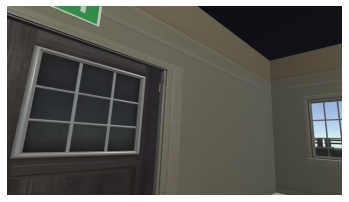

In [6]:
import matplotlib.pyplot as plt

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.axis("off")
plt.show()

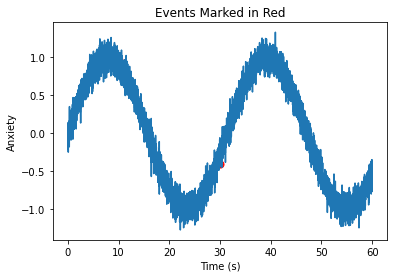

In [12]:
import matplotlib.pyplot as plt
import numpy as np

time = np.linspace(0, 60, 120*60)   # 1분 동안 120Hz
anxiety = np.sin(time/5) + np.random.randn(len(time))*0.1  # 그냥 테스트용

event_times = [10, 30, 45]

plt.plot(time, anxiety)
plt.scatter(event_times, [anxiety[int(t*120)] for t in event_times], color='red', s=50)
plt.xlabel("Time (s)")
plt.ylabel("Anxiety")
plt.title("Events Marked in Red")
plt.show()

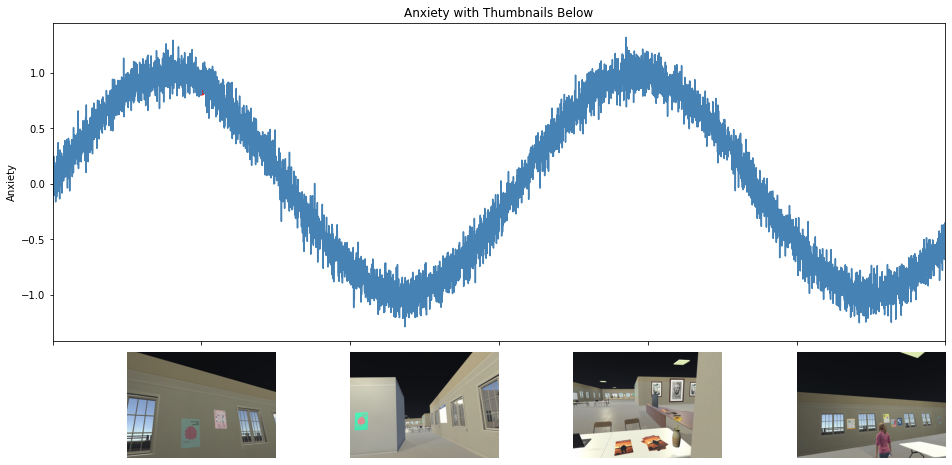

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) 예시 데이터
time = np.linspace(0, 60, 120*60)
anxiety = np.sin(time/5) + np.random.randn(len(time))*0.1
event_times = [10, 25, 40, 55]

# 2) 비디오에서 프레임 얻기 함수
def grab_frame(video_path, t_sec):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_MSEC, t_sec * 1000)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        return None
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# 예시 비디오 (테스트용으로 임시 파일 경로 넣어주세요!)
video_path = "./VideoTest/001_Hallway.mp4"

# 3) Figure 생성 (2줄짜리 그래프)
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(16, 8),
    gridspec_kw={'height_ratios': [3, 1]}
)
fig.subplots_adjust(hspace=0.05)

# 4) 위쪽: anxiety 그래프
ax1.plot(time, anxiety, color='steelblue')
ax1.set_ylabel("Anxiety")
ax1.set_xlim(0, 60)
ax1.set_title("Anxiety with Thumbnails Below")
ax1.set_xticklabels([])  # 아래에 있으니 X축 숫자 제거

# 이벤트 위치 표시
ax1.scatter(event_times, [anxiety[int(t*120)] for t in event_times], color='red', s=50)

# 5) 아래쪽: 썸네일 영역
ax2.set_xlim(0, 60)
ax2.set_ylim(0, 1)
ax2.axis("off")

for t in event_times:
    frame = grab_frame(video_path, t)
    if frame is not None:
        w = 10  # 이미지 너비(초 단위)
        x0 = t - w/2
        x1 = t + w/2
        ax2.imshow(frame, extent=[x0, x1, 0, 1], aspect='auto')

plt.show()

In [3]:

import math
# -------------------------------
# 유틸: 비디오 읽기(장면별 캐싱)
# -------------------------------
class SceneVideo:
    def __init__(self, path: str, pos="msec", offset: float = 0.0):
        self.path = path
        self.pos_mode = pos  # "msec" or "frame"
        self.offset = float(offset)
        self.cap = cv2.VideoCapture(path)
        if not self.cap.isOpened():
            raise RuntimeError(f"Cannot open video: {path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30.0
        self.nf  = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        self.dur = self.nf / self.fps if self.fps > 0 else None

    def __del__(self):
        try:
            if hasattr(self, "cap") and self.cap is not None:
                self.cap.release()
        except Exception:
            pass

    def _seek(self, t_sec: float) -> bool:
        if self.pos_mode == "msec":
            return self.cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, t_sec) * 1000.0)
        # frame 기반(고정 FPS일 때)
        f_idx = int(round(max(0.0, t_sec) * self.fps))
        f_idx = min(max(0, f_idx), max(0, self.nf - 1))
        return self.cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx)

    def read_at(self, t_scene_sec: float, nearest_if_fail=True):
        if t_scene_sec is None or math.isnan(t_scene_sec):
            return False, None
        t_eff = t_scene_sec + self.offset
        if self.dur is not None:
            t_eff = min(max(0.0, t_eff), max(0.0, self.dur - 1e-3))
        ok_seek = self._seek(t_eff)
        ok, frame = self.cap.read()
        if not ok or frame is None:
            if not nearest_if_fail:
                return False, None
            # 마지막 프레임 폴백
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, self.nf - 1))
            ok2, frame2 = self.cap.read()
            return ok2 and frame2 is not None, frame2
        return True, frame

class VideoBank:
    def __init__(self, scene_to_path: dict, offset_by_scene=None):
        self.items = {}
        self.offsets = offset_by_scene or {}
        for sc, p in scene_to_path.items():
            if not os.path.exists(p):
                # 경로 없으면 건너뛰기(출력 시 경고)
                continue
            self.items[sc] = SceneVideo(p, pos="msec", offset=float(self.offsets.get(sc, 0.0)))

    def read(self, scene: str, t_scene_sec: float):
        if scene not in self.items:
            return False, None
        return self.items[scene].read_at(t_scene_sec)

import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter


def _smooth_series(x, fs, med_win_s=0.5, sg_win_s=1.0, sg_poly=2):
    from scipy.ndimage import median_filter
    med_win = int(max(1, round(med_win_s * fs)))
    sg_win = int(max(3, round(sg_win_s * fs)) // 2 * 2 + 1)
    x_med = median_filter(x, med_win)
    return savgol_filter(x_med, sg_win, sg_poly)


def _merge_nearby(idx, vals, fs, merge_s=0.5):
    if len(idx) <= 1:
        return idx
    min_gap = merge_s * fs
    keep = [idx[0]]
    for i in idx[1:]:
        if i - keep[-1] > min_gap:
            keep.append(i)
        elif abs(vals[i]) > abs(vals[keep[-1]]):
            keep[-1] = i
    return np.array(keep, dtype=int)


def detect_events_adaptive_by_scene(
    df: pd.DataFrame,
    fs: float = 120.0,
    *,
    min_dist_s: float = 0.8,
    z_prom: float = 1.0,
    z_prom_peak = None,
    z_prom_low= None,
    z_height: float = 0.0,
    plateau_min_s: float = 0.20,
    wlen_s: float = 5.0,
    med_win_s: float = 0.5,
    sg_win_s: float = 1.0,
    sg_poly: int = 2,
    merge_s: float = 0.6,
    topk_per_scene: int = 1,
    topk_low_per_scene: int = 1,
    flat_thresh: float = 0.02,            # flatness threshold
    mandatory_interval_s: float = 10.0    # 변화 없을 때 강제 샘플링 주기
):
    """
    입력: df['time','scene','anxiety']
    flat 구간, plateau 시작/끝, 최고/최저점, mandatory interval 모두 포함한 이벤트 검출
    """
    out_rows = []

    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    for sc, g in df.groupby("scene", sort=False):
        y_raw = g["anxiety"].astype(float).values
        t_abs = g["time"].values
        t_rel = g["t_scene"].values
        idx_all = g.index.values

        # robust z
        med = np.median(y_raw)
        mad = np.median(np.abs(y_raw - med)) + 1e-9
        z = (y_raw - med) / (1.4826 * mad)
        z_s = _smooth_series(z, fs, med_win_s=med_win_s, sg_win_s=sg_win_s, sg_poly=sg_poly)

        distance = max(1, int(min_dist_s * fs))
        plateau_size = int(max(1, round(plateau_min_s * fs)))
        wlen = int(max(3, round(wlen_s * fs)))

        prom_pk = z_prom if z_prom_peak is None else z_prom_peak
        prom_low = z_prom if z_prom_low is None else z_prom_low

        pk_idx, pk_prop = find_peaks(z_s, prominence=prom_pk, height=z_height,
                                     distance=distance, plateau_size=plateau_size, wlen=wlen)
        vl_idx, vl_prop = find_peaks(-z_s, prominence=prom_low, height=z_height,
                                     distance=distance, plateau_size=plateau_size, wlen=wlen)

        pk_idx = _merge_nearby(pk_idx, z_s[pk_idx], fs, merge_s=merge_s)
        vl_idx = _merge_nearby(vl_idx, -z_s[vl_idx], fs, merge_s=merge_s)

        # ✅ plateau 구간 감지: flatness 기반
        dz = np.diff(y_raw)
        flat_mask = np.abs(dz) < flat_thresh
        if np.any(flat_mask):
            # True 덩어리 구간 start/end
            starts = np.where(np.diff(np.concatenate([[0], flat_mask.astype(int), [0]])) == 1)[0]
            ends = np.where(np.diff(np.concatenate([[0], flat_mask.astype(int), [0]])) == -1)[0]
            for s, e in zip(starts, ends):
                out_rows.append({
                    "scene": str(sc), "event": "flat_start",
                    "index": int(idx_all[s]),
                    "time": float(t_abs[s]), "t_scene": float(t_rel[s]),
                    "anxiety": float(y_raw[s]), "score": 0.0
                })
                out_rows.append({
                    "scene": str(sc), "event": "flat_end",
                    "index": int(idx_all[e-1]),
                    "time": float(t_abs[e-1]), "t_scene": float(t_rel[e-1]),
                    "anxiety": float(y_raw[e-1]), "score": 0.0
                })

        # ✅ peak → 시작점(상승 시작 프레임) 잡기
        for i in pk_idx:
            j = i
            while j > 1 and z_s[j-1] < z_s[j] and z_s[j-2] < z_s[j-1]:
                j -= 1
            out_rows.append({
                "scene": str(sc), "event": "peak",
                "index": int(idx_all[j]),
                "time": float(t_abs[j]), "t_scene": float(t_rel[j]),
                "anxiety": float(y_raw[j]), "score": float(z_s[i])
            })

        # ✅ low → 하강 끝 프레임 (즉 최저점 근처)
        for i in vl_idx:
            j = i
            while j < len(z_s)-2 and z_s[j+1] > z_s[j] and z_s[j+2] > z_s[j+1]:
                j += 1
            out_rows.append({
                "scene": str(sc), "event": "low",
                "index": int(idx_all[j]),
                "time": float(t_abs[j]), "t_scene": float(t_rel[j]),
                "anxiety": float(y_raw[j]), "score": float(-z_s[i])
            })

        # ✅ 최고점/최저점 보장
        i_max = np.argmax(y_raw)
        i_min = np.argmin(y_raw)
        out_rows.append({
            "scene": str(sc), "event": "max_point",
            "index": int(idx_all[i_max]),
            "time": float(t_abs[i_max]), "t_scene": float(t_rel[i_max]),
            "anxiety": float(y_raw[i_max]), "score": float(z_s[i_max])
        })
        out_rows.append({
            "scene": str(sc), "event": "min_point",
            "index": int(idx_all[i_min]),
            "time": float(t_abs[i_min]), "t_scene": float(t_rel[i_min]),
            "anxiety": float(y_raw[i_min]), "score": float(-z_s[i_min])
        })

        # ✅ mandatory sampling (10초마다 1개 이상)
        interval = int(mandatory_interval_s * fs)
        for k in range(0, len(y_raw), interval):
            out_rows.append({
                "scene": str(sc), "event": "mandatory",
                "index": int(idx_all[k]),
                "time": float(t_abs[k]), "t_scene": float(t_rel[k]),
                "anxiety": float(y_raw[k]), "score": 0.0
            })

    return pd.DataFrame(out_rows).sort_values(["scene", "time"]).reset_index(drop=True)

# -------------------------------
# 이벤트 테이블 구성
# -------------------------------
def rows_from_indices(name, idxs, props=None):
    rows = []
    for k, i in enumerate(idxs):
        rows.append({
            "index": int(i),
            "time": float(df.loc[i, "time"]),
            "t_scene": float(df.loc[i, "t_scene"]),
            "scene": str(df.loc[i, "scene"]),
            "event": name,
            "anxiety": float(df.loc[i, "anxiety"]),
            "prominence": float(props["prominences"][k]) if props is not None and "prominences" in props else np.nan
        })
    return rows


# -------------------------------
# 너무 많은 이벤트 → 대표만 선택
# -------------------------------
def select_events_for_thumbs(
    df_events: pd.DataFrame, fs: float,
    min_gap_s: float = 3.0, bin_secs: float = 10.0,
    max_per_scene: int = 8, max_total: int = 30
):
    if df_events.empty: 
        return df_events

    df = df_events.copy()

    # 중요도 점수: prominence가 있으면 그걸, 없으면 |Δy| 근사
    if "prominence" in df.columns and df["prominence"].notna().any():
        df["score"] = df["prominence"].fillna(0.0)
    else:
        dt = 1.0 / fs
        y = df["anxiety"].astype(float).values
        df["score"] = np.abs(np.gradient(y, dt))

    # 1) 가까운 이벤트 병합(같은 scene내)
    keep_idx = []
    for sc, g in df.groupby("scene", sort=False):
        last_t = -1e9
        for i, r in g.sort_values(["time", "score"], ascending=[True, False]).iterrows():
            if r["time"] - last_t >= min_gap_s:
                keep_idx.append(i)
                last_t = r["time"]
    df = df.loc[keep_idx].sort_values("time")

    # 2) 시간균형(빈당 최고 score 1개)
    df["bin"] = (df["time"] // bin_secs).astype(int)
    pick_idx = []
    for (sc, b), g in df.groupby(["scene", "bin"]):
        pick_idx.append(g["score"].idxmax())
    df = df.loc[pick_idx]

    # 3) 장면별 상한 + 전체 상한
    outs = []
    for sc, g in df.groupby("scene"):
        outs.append(g.sort_values("score", ascending=False).head(max_per_scene))
    out = pd.concat(outs, axis=0).sort_values(["scene", "time"])
    if len(out) > max_total:
        out = out.sort_values("score", ascending=False).head(max_total)
        out = out.sort_values(["scene", "time"])

    return out.drop(columns=["bin"], errors="ignore").reset_index(drop=True)


# -------------------------------
# 시각화: 위(anxiety) + 아래(썸네일 줄)
# -------------------------------
import matplotlib.pyplot as plt
import numpy as np

def plot_per_scene_with_strip(
    df, df_events, bank,
    scenes_order=None,
    thumb_width_secs=6.0,          # 썸네일 가로폭(장면 상대시간 기준)
    lanes_y=[0.05, 0.55],          # 썸네일 줄 배치(2줄 지그재그)
    strip_height_ratio=1,          # 위:아래 비율 [2,1]에서 아래(1) 값 — 1을 키우면 스트립이 더 두꺼워짐
    line_height_ratio=2,           # 위(라인) 영역 비율
    max_per_scene=12,              # 장면당 썸네일 상한
    figsize_per_scene=(16, 5.0),   # 장면당 (가로, 세로) in inches
    dpi=130,
    save_path=None
):
    """
    df: time, anxiety, scene (t_scene 없으면 자동생성)
    df_events: time/t_scene/scene/anxiety/thumb/score(optional)
    bank: VideoBank (scene→video)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2

    # --- 안전 복사 + t_scene 보정 ---
    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    ev = df_events.copy()  # ✅ 여기서 ev 정의
    if "t_scene" not in ev.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        ev["t_scene"] = ev.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    if scenes_order is None:
        scenes_order = [s for s in df["scene"].astype(str).unique()]

    n = len(scenes_order)
    W, H_unit = figsize_per_scene
    H = H_unit * n

    fig = plt.figure(figsize=(W, H), dpi=dpi)
    # 위:아래 비율 커스터마이즈
    gs = fig.add_gridspec(
        nrows=2*n, ncols=1,
        height_ratios=sum(([line_height_ratio, strip_height_ratio] for _ in range(n)), []),
        hspace=0.15
    )

    for idx, sc in enumerate(scenes_order):
        g = df[df["scene"].astype(str) == sc].copy()
        if g.empty:
            continue

        # 장면 시계열
        t = g["t_scene"].to_numpy()
        y = g["anxiety"].to_numpy()
        t0, t1 = float(t.min()), float(t.max())
        dur = max(1e-6, t1 - t0)

        # 장면 이벤트
        ev_sc = ev[ev["scene"].astype(str) == sc].copy()   # ✅ ev_sc 정의
        if len(ev_sc) > max_per_scene:
            key = "score" if "score" in ev_sc.columns else "anxiety"
            ev_sc = ev_sc.sort_values(key, ascending=False).head(max_per_scene).sort_values("t_scene")

        # 축 생성
        ax_line  = fig.add_subplot(gs[2*idx, 0])
        ax_strip = fig.add_subplot(gs[2*idx+1, 0])

        # --- 위: 라인 ---
        ax_line.plot(t, y, lw=1.2)
        # 썸네일 반폭만큼 패딩 → 가장자리 잘림 방지
        w = float(thumb_width_secs)
        # w = min(max(w, 0.04*dur), 0.20*dur)   # 장면 길이 대비 자동 제한
        pad = w/2.0
        ax_line.set_xlim(t0 - pad, t1 + pad)
        ax_line.set_ylabel("Anxiety")
        ax_line.set_title(f"{sc} (dur ≈ {dur:.1f}s)")
        if not ev_sc.empty:
            ax_line.scatter(ev_sc["t_scene"], ev_sc["anxiety"], s=30, c="red", zorder=3)
        ax_line.set_xticklabels([])

        from matplotlib.offsetbox import OffsetImage, AnnotationBbox

        # --- 아래: 썸네일 스트립 (고정 크기, 가장자리 안 잘리도록 패딩 유지) ---
        ax_strip.set_xlim(t0 - pad, t1 + pad)   # 위 라인과 동일한 xlim 유지(시간 정렬)
        ax_strip.set_ylim(0, 1)
        ax_strip.axis("off")

        thumb_zoom = 0.05   # 🔸썸네일 크기 (0.25~0.6 정도 조절)
        lanes_y = [0.25, 0.70]  # 🔸두 줄 지그재그 배치(세 줄 원하면 [0.15, 0.5, 0.85])

        for i, row in enumerate(ev_sc.itertuples(index=False)):
            img = getattr(row, "thumb", None)
            if img is None:
                ok, bgr = bank.read(row.scene, row.t_scene)
                if not ok or bgr is None:
                    continue
                img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

            # x는 '시간', y는 스트립 안의 고정 높이(지그재그)
            x = float(row.t_scene)
            y = lanes_y[i % len(lanes_y)]

            oi = OffsetImage(img, zoom=thumb_zoom)
            ab = AnnotationBbox(
                oi, (x, y),
                xycoords=("data", "axes fraction"),   # x는 데이터(시간), y는 축 비율(0~1)
                box_alignment=(0.5, 0.5),
                frameon=True,
                bboxprops=dict(edgecolor="white", linewidth=1)
            )
            ax_strip.add_artist(ab)

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"[SAVE] {save_path}")
    plt.show()


In [20]:
import matplotlib.transforms as mtransforms
# ================================
# 1) 이벤트 검출 (피크=진짜 최고점, 고점 우선)
# ================================
def detect_events_adaptive_by_scene_strict(
    df: pd.DataFrame,
    fs: float = 120.0,
    *,
    med_win_s: float = 0.5,
    sg_win_s: float = 1.0,
    sg_poly: int = 2,
    min_dist_s: float = 0.8,
    height_pct: float = 75.0,      # 상위 퍼센타일 컷(고점 위주)
    z_min_prom: float = 1.0,       # prominence 하한 (z 단위)
    plateau_min_s: float = 0.20,
    flat_thresh: float = 0.02,
    mandatory_interval_s: float = 10.0
):
    """
    입력: df['time','scene','anxiety'] (t_scene 없으면 여기서 만듭니다)
    출력: 이벤트 테이블 (peak는 '최고점' 위치에 찍힘), 각 행에 eid 포함
    """
    from scipy.signal import find_peaks
    from scipy.ndimage import median_filter
    import numpy as np
    import pandas as pd

    def _smooth_series(x, fs, med_win_s=0.5, sg_win_s=1.0, sg_poly=2):
        from scipy.signal import savgol_filter
        med_win = int(max(1, round(med_win_s * fs)))
        sg_win = int(max(3, round(sg_win_s * fs)) // 2 * 2 + 1)
        x_med = median_filter(x, med_win)
        return savgol_filter(x_med, sg_win, sg_poly)

    def _merge_nearby(idx, vals, fs, merge_s=0.6):
        if len(idx) <= 1:
            return idx
        min_gap = merge_s * fs
        keep = [idx[0]]
        for i in idx[1:]:
            if i - keep[-1] > min_gap:
                keep.append(i)
            elif abs(vals[i]) > abs(vals[keep[-1]]):
                keep[-1] = i
        return np.array(keep, dtype=int)

    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    rows = []
    eid = 1

    for sc, g in df.groupby("scene", sort=False):
        y = g["anxiety"].astype(float).to_numpy()
        t_abs = g["time"].to_numpy()
        t_rel = g["t_scene"].to_numpy()
        idx_all = g.index.to_numpy()

        # robust z
        med = np.median(y)
        mad = np.median(np.abs(y - med)) + 1e-9
        z = (y - med) / (1.4826 * mad)

        z_s = _smooth_series(z, fs, med_win_s=med_win_s, sg_win_s=sg_win_s, sg_poly=sg_poly)

        # 고점 위주 컷오프
        z_height = np.percentile(z_s, height_pct)
        distance = max(1, int(round(min_dist_s * fs)))

        # 진짜 피크(최고점) 위치
        pk_idx, pk_prop = find_peaks(
            z_s,
            height=z_height,
            prominence=z_min_prom,
            distance=distance
        )
        # 너무 가까운 피크 병합
        pk_idx = _merge_nearby(pk_idx, z_s, fs, merge_s=min_dist_s)

        # plateau(평탄) 구간(옵션): 시작/끝만 찍어 참고용
        dz = np.diff(y)
        flat_mask = np.abs(dz) < flat_thresh
        if np.any(flat_mask):
            starts = np.where(np.diff(np.concatenate([[0], flat_mask.astype(int), [0]])) == 1)[0]
            ends   = np.where(np.diff(np.concatenate([[0], flat_mask.astype(int), [0]])) == -1)[0]
            for s, e in zip(starts, ends):
                rows.append({
                    "eid": eid, "scene": str(sc), "event": "flat_start",
                    "index": int(idx_all[s]), "time": float(t_abs[s]),
                    "t_scene": float(t_rel[s]), "anxiety": float(y[s]), "score": 0.0
                }); eid += 1
                rows.append({
                    "eid": eid, "scene": str(sc), "event": "flat_end",
                    "index": int(idx_all[e-1]), "time": float(t_abs[e-1]),
                    "t_scene": float(t_rel[e-1]), "anxiety": float(y[e-1]), "score": 0.0
                }); eid += 1

        # 피크(최고점) 자체에 찍기
        for i in pk_idx:
            rows.append({
                "eid": eid, "scene": str(sc), "event": "peak",
                "index": int(idx_all[i]),
                "time": float(t_abs[i]), "t_scene": float(t_rel[i]),
                "anxiety": float(y[i]), "score": float(z_s[i])
            })
            eid += 1

        # 각 장면의 전역 최대/최소 보장(참고용)
        i_max = int(np.argmax(y)); i_min = int(np.argmin(y))
        rows.append({
            "eid": eid, "scene": str(sc), "event": "max_point",
            "index": int(idx_all[i_max]),
            "time": float(t_abs[i_max]), "t_scene": float(t_rel[i_max]),
            "anxiety": float(y[i_max]), "score": float(z_s[i_max])
        }); eid += 1
        rows.append({
            "eid": eid, "scene": str(sc), "event": "min_point",
            "index": int(idx_all[i_min]),
            "time": float(t_abs[i_min]), "t_scene": float(t_rel[i_min]),
            "anxiety": float(y[i_min]), "score": float(-z_s[i_min])
        }); eid += 1

        # mandatory sampling (변화 없을 때 대비용, 옵션)
        interval = int(max(1, round(mandatory_interval_s * fs)))
        for k in range(0, len(y), interval):
            rows.append({
                "eid": eid, "scene": str(sc), "event": "mandatory",
                "index": int(idx_all[k]),
                "time": float(t_abs[k]), "t_scene": float(t_rel[k]),
                "anxiety": float(y[k]), "score": 0.0
            }); eid += 1

    ev = pd.DataFrame(rows).sort_values(["scene", "time"]).reset_index(drop=True)
    return ev


# ================================
# 2) 대표 이벤트 선택(1:1 매칭 보존)
# ================================
def select_events_for_thumbs(
    df_events: pd.DataFrame, fs: float,
    min_gap_s: float = 3.0,
    bin_secs: float = 10.0,
    max_per_scene: int = 8,
    max_total: int = 30,
    only_event_types=("peak",)  # ← 기본은 ‘피크만’ 썸네일화
):
    if df_events.empty:
        return df_events

    df = df_events.copy()
    if only_event_types is not None:
        df = df[df["event"].isin(only_event_types)].copy()

    # 중요도 score: 높을수록 우선(이미 detect에서 score=z_s[peak])
    if "score" not in df.columns:
        df["score"] = 0.0

    # 1) 같은 scene 내 가까운 이벤트 병합(시간 우선, score 높은 것 우선)
    keep_idx = []
    for sc, g in df.groupby("scene", sort=False):
        last_t = -1e9
        for i, r in g.sort_values(["time", "score"], ascending=[True, False]).iterrows():
            if r["time"] - last_t >= min_gap_s:
                keep_idx.append(i)
                last_t = r["time"]
    df = df.loc[keep_idx].sort_values(["scene", "time"])

    # 2) 시간균형: 빈(bin) 내 최대 score 1개
    df["bin"] = (df["time"] // bin_secs).astype(int)
    pick_idx = []
    for (sc, b), g in df.groupby(["scene", "bin"]):
        pick_idx.append(g["score"].idxmax())
    df = df.loc[pick_idx]

    # 3) 장면별 상한 + 전체 상한
    outs = []
    for sc, g in df.groupby("scene", sort=False):
        outs.append(g.sort_values("score", ascending=False).head(max_per_scene))
    out = pd.concat(outs, axis=0).sort_values(["scene", "time"])
    if len(out) > max_total:
        out = out.sort_values("score", ascending=False).head(max_total)
        out = out.sort_values(["scene", "time"])

    # 정리
    out = out.drop(columns=["bin"], errors="ignore").reset_index(drop=True)
    return out


# ================================
# 3) 플로팅 (겹침 방지 3~4줄 lanes + 번호 매칭)
# ================================
def _assign_lanes(ev_sc, thumb_width_secs, n_lanes=4, lane_y=None):
    """
    ev_sc: t_scene 기준 정렬된 DataFrame
    thumb_width_secs: 한 썸네일의 가로폭(초)
    n_lanes: 사용 가능한 줄 수
    lane_y: 각 lane의 y 위치(axes fraction). None이면 균등 배치.
    """
    import numpy as np
    if lane_y is None:
        # 0.15 ~ 0.85 사이로 균등
        lane_y = np.linspace(0.15, 0.85, n_lanes)

    # 각 lane 마지막 x(=t_scene) 기억해서 겹침 방지
    last_x = np.full(n_lanes, -1e9, dtype=float)
    half = thumb_width_secs / 2.0
    lanes = []

    for row in ev_sc.itertuples(index=False):
        x = float(row.t_scene)
        placed = False
        for li in range(n_lanes):
            if x - last_x[li] >= thumb_width_secs * 0.95:  # 95% 이상 벌어지면 배치
                lanes.append((x, lane_y[li]))
                last_x[li] = x
                placed = True
                break
        if not placed:
            # 가장 빨리 가능해질 lane에 강제로 올림(최소 겹침 전략)
            li = int(np.argmin(last_x))
            lanes.append((x, lane_y[li]))
            last_x[li] = x
    return lanes


def plot_per_scene_with_strip_numbered(
    df, df_events, bank,
    scenes_order=None,
    thumb_width_secs=6.0,
    n_lanes=4,
    strip_height_ratio=1,
    line_height_ratio=2,
    max_per_scene=12,
    figsize_per_scene=(16, 5.5),
    dpi=130,
    save_path=None
):
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import cv2
    import numpy as np

    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    ev = df_events.copy()
    if "t_scene" not in ev.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        ev["t_scene"] = ev.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    if scenes_order is None:
        scenes_order = [s for s in df["scene"].astype(str).unique()]

    n = len(scenes_order)
    W, H_unit = figsize_per_scene
    H = H_unit * n

    fig = plt.figure(figsize=(W, H), dpi=dpi)
    gs = fig.add_gridspec(
        nrows=2*n, ncols=1,
        height_ratios=sum(([line_height_ratio, strip_height_ratio] for _ in range(n)), []),
        hspace=0.18
    )

    mapping_rows = []  # 콘솔용 매핑표

    for idx, sc in enumerate(scenes_order):
        g = df[df["scene"].astype(str) == sc].copy()
        if g.empty:
            continue

        t = g["t_scene"].to_numpy()
        y = g["anxiety"].to_numpy()
        t0, t1 = float(t.min()), float(t.max())
        dur = max(1e-6, t1 - t0)

        ev_sc = ev[ev["scene"].astype(str) == sc].copy()
        if len(ev_sc) > max_per_scene:
            key = "score" if "score" in ev_sc.columns else "anxiety"
            ev_sc = ev_sc.sort_values(key, ascending=False).head(max_per_scene).sort_values("t_scene")

        # 축 생성
        ax_line  = fig.add_subplot(gs[2*idx, 0])
        ax_strip = fig.add_subplot(gs[2*idx+1, 0])

        # 위: 라인 + 피크(빨간 점)
        ax_line.plot(t, y, lw=1.2)
        pad = thumb_width_secs / 2.0
        ax_line.set_xlim(t0 - pad, t1 + pad)
        ax_line.set_ylabel("Anxiety")
        ax_line.set_title(f"{sc} (dur ≈ {dur:.1f}s)")
        ax_line.set_xticklabels([])

        if not ev_sc.empty:
            ax_line.scatter(ev_sc["t_scene"], ev_sc["anxiety"], s=32, c="red", zorder=3)

        # 아래: 썸네일 스트립
        ax_strip.set_xlim(t0 - pad, t1 + pad)
        ax_strip.set_ylim(0, 1)
        ax_strip.axis("off")

        # lane 배치(겹침 방지)
        ev_sc = ev_sc.sort_values("t_scene").reset_index(drop=True)
        lane_xy = _assign_lanes(ev_sc, thumb_width_secs=thumb_width_secs, n_lanes=n_lanes)

        thumb_zoom = 0.055  # 썸네일 크기

        for (row, (x, y_frac)) in zip(ev_sc.itertuples(index=False), lane_xy):
            # 프레임 캡쳐
            img = getattr(row, "thumb", None)
            if img is None:
                ok, bgr = bank.read(row.scene, row.t_scene)
                if not ok or bgr is None:
                    continue
                img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

            # 썸네일 배치
            oi = OffsetImage(img, zoom=thumb_zoom)
            ab = AnnotationBbox(
                oi, (x, y_frac),
                xycoords=("data", "axes fraction"),
                box_alignment=(0.5, 0.5),
                frameon=True,
                bboxprops=dict(edgecolor="white", linewidth=1.0)
            )
            ax_strip.add_artist(ab)

            # 번호(badge) 표시: 썸네일/점 모두 같은 숫자
            eid = int(getattr(row, "eid", 0))
            # 썸네일 숫자
            ax_strip.text(
                x, min(0.97, y_frac + 0.09),
                f"{eid}",
                ha="center", va="center", fontsize=8,
                bbox=dict(facecolor="white", edgecolor="black", linewidth=0.6, boxstyle="round,pad=0.2")
            )
            # 라인 그래프 숫자
            ax_line.annotate(
                f"{eid}",
                xy=(row.t_scene, row.anxiety),
                xytext=(row.t_scene, row.anxiety + 0.03*(np.nanmax(y)-np.nanmin(y)+1e-6)),
                textcoords="data",
                ha="center", va="bottom", fontsize=8,
                bbox=dict(facecolor="white", edgecolor="black", linewidth=0.5, boxstyle="round,pad=0.15"),
                arrowprops=dict(arrowstyle="-", lw=0.5, color="gray")
            )

            # 콘솔용 매핑 저장
            mapping_rows.append({
                "eid": eid,
                "scene": row.scene,
                "t_scene": float(row.t_scene),
                "time": float(row.time),
                "anxiety": float(row.anxiety)
            })

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"[SAVE] {save_path}")
    plt.show()

    # 매핑표 출력(점-썸네일 1:1 확인용)
    if mapping_rows:
        map_df = pd.DataFrame(mapping_rows).sort_values(["scene","t_scene","eid"])
        print("\n[ID Mapping: peak point ↔ thumbnail]")
        print(map_df.to_string(index=False))
    return
def detect_events_peak_low_with_plateau(
    df: pd.DataFrame,
    fs: float = 120.0,
    *,
    min_dist_s: float = 0.8,
    height_pct_peak: float = 70.0,    # 피크 컷(퍼센타일)
    height_pct_low: float  = 30.0,    # 로우 컷(퍼센타일, -z 기준 아님)
    prom_z_min_peak: float = 0.9,     # prominence 하한(z)
    prom_z_min_low: float  = 0.9,
    plateau_min_s: float = 0.20,      # plateau 감지 최소 길이
    flat_dz_thresh: float = 0.02,     # 평탄성(optional) 참고용
    ensure_topk_peak: int = 5,        # 장면별 상위 K 피크 보장
    ensure_topk_low:  int = 3,
    med_win_s: float = 0.5,
    sg_win_s: float = 1.0,
    sg_poly: int = 2,
):
    """
    출력 컬럼: ['eid','scene','event','index','time','t_scene','anxiety','score']
      - event ∈ {'peak','low','max_point','min_point','flat_start','flat_end'}
      - plateau면 시작점(왼쪽 모서리) 인덱스에 찍습니다.
    """
    from scipy.signal import find_peaks, savgol_filter
    from scipy.ndimage import median_filter
    import numpy as np
    import pandas as pd

    def _smooth(x):
        med = int(max(1, round(med_win_s * fs)))
        sg  = int(max(3, round(sg_win_s * fs)) // 2 * 2 + 1)
        return savgol_filter(median_filter(x, med), sg, sg_poly)

    def _robust_z(y):
        med = np.median(y)
        mad = np.median(np.abs(y - med)) + 1e-9
        return (y - med) / (1.4826 * mad)

    def _plateau_start_idx(i, prop):
        # plateau면 left_edges[k], 아니면 i
        if "left_edges" in prop and "right_edges" in prop and len(prop["left_edges"]) == len(prop["peaks"]):
            # scipy >=1.11에서는 prop["peaks"]가 들어옵니다. 하위버전은 인덱스 순서를 그대로 가정.
            # 안전하게 길이 비교 후 처리
            k = np.where(prop["peaks"] == i)[0]
            if len(k):
                return int(prop["left_edges"][k[0]])
        if "left_edges" in prop and "plateau_sizes" in prop:
            # 일부 버전 호환: peaks 순서를 그대로 사용
            # (이 경우 위 분기가 작동하지 않으면 pk 루프에서 인덱스 k를 같이 넘기세요)
            pass
        return int(i)

    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    rows = []
    eid = 1
    distance = max(1, int(round(min_dist_s * fs)))
    plateau_size = int(max(1, round(plateau_min_s * fs)))

    for sc, g in df.groupby("scene", sort=False):
        y = g["anxiety"].astype(float).to_numpy()
        t = g["time"].to_numpy()
        ts = g["t_scene"].to_numpy()
        idx_all = g.index.to_numpy()

        z = _robust_z(y)
        z_s = _smooth(z)

        # 컷오프(피크/로우)
        h_pk = np.percentile(z_s, height_pct_peak)
        h_lo = np.percentile(z_s, height_pct_low)

        # ---- 피크(최고점) ----
        pk_idx, pk_prop = find_peaks(
            z_s, height=h_pk, prominence=prom_z_min_peak,
            distance=distance, plateau_size=plateau_size
        )
        # plateau 시작점으로 치환
        if len(pk_idx):
            # scipy 1.11+: peaks가 prop에 들어옴
            if "peaks" in pk_prop:
                starts = [ _plateau_start_idx(i, pk_prop) for i in pk_prop["peaks"] ]
            else:
                # 구버전: 순서로 매칭
                starts = []
                for k,i in enumerate(pk_idx):
                    if "left_edges" in pk_prop and len(pk_prop.get("left_edges",[]))==len(pk_idx) and pk_prop["plateau_sizes"][k]>1:
                        starts.append(int(pk_prop["left_edges"][k]))
                    else:
                        starts.append(int(i))
            pk_indices = np.array(starts, dtype=int)
        else:
            pk_indices = np.array([], dtype=int)

        # ---- 로우(최저점) ----
        lo_idx, lo_prop = find_peaks(
            -z_s, height=-h_lo, prominence=prom_z_min_low,
            distance=distance, plateau_size=plateau_size
        )
        if len(lo_idx):
            if "peaks" in lo_prop:
                starts_lo = [ _plateau_start_idx(i, lo_prop) for i in lo_prop["peaks"] ]
            else:
                starts_lo = []
                for k,i in enumerate(lo_idx):
                    if "left_edges" in lo_prop and len(lo_prop.get("left_edges",[]))==len(lo_idx) and lo_prop["plateau_sizes"][k]>1:
                        starts_lo.append(int(lo_prop["left_edges"][k]))
                    else:
                        starts_lo.append(int(i))
            lo_indices = np.array(starts_lo, dtype=int)
        else:
            lo_indices = np.array([], dtype=int)

        # ---- 상위K 보장(안전망) : anxiety 기준 topK 추가 ----
        if ensure_topk_peak > 0 and len(pk_indices) < ensure_topk_peak:
            topk = np.argsort(y)[::-1][:ensure_topk_peak]
            pk_indices = np.unique(np.concatenate([pk_indices, topk]))
        if ensure_topk_low > 0 and len(lo_indices) < ensure_topk_low:
            topk_lo = np.argsort(y)[:ensure_topk_low]
            lo_indices = np.unique(np.concatenate([lo_indices, topk_lo]))

        # 등록
        for i in np.sort(pk_indices):
            rows.append({"eid":eid,"scene":str(sc),"event":"peak",
                         "index":int(idx_all[i]), "time":float(t[i]), "t_scene":float(ts[i]),
                         "anxiety":float(y[i]), "score":float(z_s[i])}); eid+=1
        for i in np.sort(lo_indices):
            rows.append({"eid":eid,"scene":str(sc),"event":"low",
                         "index":int(idx_all[i]), "time":float(t[i]), "t_scene":float(ts[i]),
                         "anxiety":float(y[i]), "score":float(-z_s[i])}); eid+=1

        # 전역 최대/최소(참고용)
        imax, imin = int(np.argmax(y)), int(np.argmin(y))
        rows.append({"eid":eid,"scene":str(sc),"event":"max_point",
                     "index":int(idx_all[imax]),"time":float(t[imax]),"t_scene":float(ts[imax]),
                     "anxiety":float(y[imax]),"score":float(z_s[imax])}); eid+=1
        rows.append({"eid":eid,"scene":str(sc),"event":"min_point",
                     "index":int(idx_all[imin]),"time":float(t[imin]),"t_scene":float(ts[imin]),
                     "anxiety":float(y[imin]),"score":float(-z_s[imin])}); eid+=1

        # 평탄 참고용(옵션)
        dz = np.diff(y)
        flat_mask = np.abs(dz) < flat_dz_thresh
        if np.any(flat_mask):
            s = np.where(np.diff(np.r_[0,flat_mask.astype(int),0])==1)[0]
            e = np.where(np.diff(np.r_[0,flat_mask.astype(int),0])==-1)[0]
            for a,b in zip(s,e):
                rows.append({"eid":eid,"scene":str(sc),"event":"flat_start",
                             "index":int(idx_all[a]),"time":float(t[a]),"t_scene":float(ts[a]),
                             "anxiety":float(y[a]),"score":0.0}); eid+=1
                rows.append({"eid":eid,"scene":str(sc),"event":"flat_end",
                             "index":int(idx_all[b-1]),"time":float(t[b-1]),"t_scene":float(ts[b-1]),
                             "anxiety":float(y[b-1]),"score":0.0}); eid+=1

    return pd.DataFrame(rows).sort_values(["scene","time"]).reset_index(drop=True)
def select_events_for_thumbs_v2(
    df_events: pd.DataFrame,
    fs: float,
    *,
    include_types=("peak","low"),   # ← 피크와 최저점 모두
    min_gap_s: float = 2.0,
    bin_secs: float = 8.0,
    max_per_scene: int = 12,
    max_total: int = 80
):
    if df_events.empty:
        return df_events

    df = df_events[df_events["event"].isin(include_types)].copy()
    if df.empty:
        return df

    # 중요도: score(없으면 0)
    df["score"] = df.get("score", pd.Series(0.0, index=df.index))

    # 1) 같은 scene 내 가까운 이벤트 병합(시간 우선, score 높은 것 선택)
    keep = []
    for sc, g in df.groupby("scene", sort=False):
        last_t = -1e9
        for i,r in g.sort_values(["time","score"], ascending=[True,False]).iterrows():
            if r["time"] - last_t >= min_gap_s:
                keep.append(i); last_t = r["time"]
    df = df.loc[keep].sort_values(["scene","time"])

    # 2) 시간균형
    df["bin"] = (df["time"] // bin_secs).astype(int)
    idxs = []
    for (sc,b), g in df.groupby(["scene","bin"]):
        idxs.append(g["score"].idxmax())
    df = df.loc[idxs]

    # 3) 장면/전체 상한
    outs = []
    for sc, g in df.groupby("scene", sort=False):
        outs.append(g.sort_values("score", ascending=False).head(max_per_scene))
    out = pd.concat(outs).sort_values(["scene","time"])
    if len(out) > max_total:
        out = out.sort_values("score", ascending=False).head(max_total).sort_values(["scene","time"])

    return out.drop(columns=["bin"], errors="ignore").reset_index(drop=True)
def _assign_lanes_interval(ev_sc, width_s: float, n_lanes: int, lane_y=None):
    """
    구간 점유 기반 lane 배치: [x-half, x+half]가 겹치지 않게 위에서부터 배정
    """
    import numpy as np
    half = width_s * 0.5
    if lane_y is None:
        lane_y = np.linspace(0.18, 0.82, n_lanes)
    # 각 lane의 마지막 '끝점' 기록
    lane_last_end = np.full(n_lanes, -1e9, dtype=float)
    placements = []
    for row in ev_sc.itertuples(index=False):
        x = float(row.t_scene)
        placed = False
        for li in range(n_lanes):
            if x - half >= lane_last_end[li]:  # 충돌 없음
                placements.append((x, lane_y[li]))
                lane_last_end[li] = x + half
                placed = True
                break
        if not placed:
            # 가장 빨리 비는 줄에 강제 배치
            li = int(np.argmin(lane_last_end))
            placements.append((x, lane_y[li]))
            lane_last_end[li] = x + half
    return placements
def assign_lanes(
    ev_sc, width_s: float, n_lanes: int,
    lane_y=None,
    mode: str = "roundrobin",   # {"pack","roundrobin","zigzag"}
    sep: float = 1.0            # 충돌 여유 배수(=1이면 정확히 width_s)
):
    """
    ev_sc: t_scene 기준 정렬된 DataFrame
    width_s: 썸네일 가로폭(초)  → 충돌 판정에 사용
    n_lanes: 줄 개수
    lane_y: 각 줄의 y(axes fraction). None이면 위→아래 순으로 균등 배치.
    mode:
      - "pack"       : 기존 First-Fit (충돌 없으면 1번 줄만 씀)
      - "roundrobin" : 이벤트마다 0,1,2,... 줄로 순환 배치(충돌 시 다음 줄로 자동 이동)
      - "zigzag"     : 0→1→2→...→2→1→0 식으로 왕복 배치(충돌 시 다음 줄)
    sep : 충돌 여유 배수. 1.0이면 간격≥width_s, 0.9면 조금 더 촘촘히 허용
    """
    import numpy as np
    if lane_y is None:
        # 위에서 아래로 균등 (원하시면 순서 뒤집으세요)
        lane_y = np.linspace(0.82, 0.18, n_lanes)  # ⬅️ 위↘아래

    last_end = np.full(n_lanes, -1e9, dtype=float)
    half = 0.5 * width_s
    need_gap = sep * width_s
    out = []

    # 라운드로빈/지그재그용 인덱스 생성기
    def lane_iter():
        if mode == "roundrobin":
            k = 0
            while True:
                yield k % n_lanes
                k += 1
        elif mode == "zigzag":
            order = list(range(n_lanes)) + list(range(n_lanes-2, 0, -1))
            k = 0
            while True:
                yield order[k % len(order)]
                k += 1
        else:  # "pack"
            while True:
                yield from range(n_lanes)

    gen = lane_iter()

    for row in ev_sc.itertuples(index=False):
        x = float(row.t_scene)
        placed = False

        # 시작 lane 선택 (mode별 다름)
        tried = set()
        first_lane = next(gen)
        cand_order = [first_lane] + [i for i in range(n_lanes) if i != first_lane] if mode!="pack" else list(range(n_lanes))

        for li in cand_order:
            if li in tried: 
                continue
            tried.add(li)
            # 충돌 검사: [x-half, x+half]가 이전 끝점(last_end[li]) 이후여야 함
            if (x - half) >= (last_end[li] + (need_gap - width_s)):
                out.append((x, lane_y[li]))
                last_end[li] = x + half
                placed = True
                break

        if not placed:
            # 모든 줄이 충돌이면 가장 빨리 비는 줄에 강제
            li = int(np.argmin(last_end))
            out.append((x, lane_y[li]))
            last_end[li] = x + half

    return out
# --- figure/axes 픽셀 기준으로 lane당 적정 zoom 계산
def _auto_zoom(ax_strip, img_h_px, n_lanes, lane_margin=0.12):
    # axes 높이(px)
    bbox = ax_strip.get_window_extent().transformed(ax_strip.figure.dpi_scale_trans.inverted())
    ax_h_px = bbox.height * ax_strip.figure.dpi
    band_px = ax_h_px / n_lanes
    target_px = band_px * (1.0 - lane_margin)  # 위아래 여백
    z = target_px / max(1, img_h_px)
    return max(0.025, min(0.12, z))            # 안전 가드


def plot_per_scene_with_strip_numbered_v2(
    df, df_events, bank,
    scenes_order=None,
    thumb_width_secs=6.0,
    n_lanes=3,                        # ← 기본 3줄
    strip_height_ratio=1,
    line_height_ratio=2,
    max_per_scene=14,
    figsize_per_scene=(16, 5.8),
    dpi=130,
    save_path=None
):
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import numpy as np, cv2, pandas as pd

    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    ev = df_events.copy()
    if "t_scene" not in ev.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        ev["t_scene"] = ev.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    if scenes_order is None:
        scenes_order = [s for s in df["scene"].astype(str).unique()]

    n = len(scenes_order)
    W,Hs = figsize_per_scene
    H = Hs * n
    fig = plt.figure(figsize=(W, H), dpi=dpi)
    gs = fig.add_gridspec(
        nrows=2*n, ncols=1,
        height_ratios=sum(([line_height_ratio, strip_height_ratio] for _ in range(n)), []),
        hspace=0.20
    )

    mapping = []

    for idx, sc in enumerate(scenes_order):
        g = df[df["scene"].astype(str)==sc]
        if g.empty: continue

        t = g["t_scene"].to_numpy(); y = g["anxiety"].to_numpy()
        t0, t1 = float(t.min()), float(t.max()); pad = thumb_width_secs/2.0

        ev_sc = ev[ev["scene"].astype(str)==sc].copy()
        # 우선순위: score desc → t_scene asc
        key = "score" if "score" in ev_sc.columns else "anxiety"
        ev_sc = ev_sc.sort_values([key,"t_scene"], ascending=[False,True]).head(max_per_scene).sort_values("t_scene")

        ax_line  = fig.add_subplot(gs[2*idx,0])
        ax_strip = fig.add_subplot(gs[2*idx+1,0])
        trans_xy = mtransforms.blended_transform_factory(ax_strip.transData, ax_strip.transAxes)
        # ...
        # 첫 번째 썸네일의 높이를 이용해 zoom 산출 (모두 같은 해상도면 그대로 사용)
        sample_h = 240   # 기본값(없을 때)
        try:
            # 가능하면 실제 프레임 하나 읽어 높이 측정
            _tmp = None
            if len(ev_sc):
                ok, bgr = bank.read(ev_sc.iloc[0].scene, ev_sc.iloc[0].t_scene)
                if ok and bgr is not None:
                    _tmp = bgr
            if _tmp is not None:
                sample_h = _tmp.shape[0]
        except Exception:
            pass
        zoom = _auto_zoom(ax_strip, sample_h, n_lanes)


        # --- 위: 시계열 + 마커(피크=red, 로우=blue)
        ax_line.plot(t, y, lw=1.2)
        ax_line.set_xlim(t0-pad, t1+pad)
        ax_line.set_ylabel("Anxiety")
        ax_line.set_title(f"{sc} (dur≈{t1-t0:.1f}s)")
        ax_line.set_xticklabels([])

        if not ev_sc.empty:
            m_peak = ev_sc["event"].eq("peak")
            m_low  = ev_sc["event"].eq("low")
            ax_line.scatter(ev_sc.loc[m_peak,"t_scene"], ev_sc.loc[m_peak,"anxiety"], s=34, c="red",  zorder=3)
            ax_line.scatter(ev_sc.loc[m_low ,"t_scene"], ev_sc.loc[m_low ,"anxiety"], s=34, c="dodgerblue", zorder=3)

        # --- 아래: 썸네일 레이아웃(충돌 방지 N줄)
        ax_strip.set_xlim(t0-pad, t1+pad); ax_strip.set_ylim(0,1); ax_strip.axis("off")
        ev_sc = ev_sc.reset_index(drop=True)
        places = assign_lanes(
        ev_sc, width_s=thumb_width_secs, n_lanes=n_lanes,
        mode="zigzag",                 # ← roundrobin도 가능
        sep=2.0                        # 간격을 더 빡빡하게는 0.9~1.0
    )

        zoom = 0.055
        for (row, (x, y_frac)) in zip(ev_sc.itertuples(index=False), places):
            # lane 인덱스 추정(가장 가까운 y)
            li = int(np.argmin(np.abs(y_frac - np.linspace(0.82, 0.18, n_lanes))))
            # lane별로 아주 작은 시간 이동(표시는 동일해 보임)
            x_draw = x + (li - (n_lanes-1)/2)* (thumb_width_secs * 0.06)   # 6% 정도
            ab = AnnotationBbox(
                OffsetImage(img, zoom=zoom),
                (x_draw, y_frac),
                xycoords=trans_xy, box_alignment=(0.5,0.5),
                frameon=True, bboxprops=dict(edgecolor="white", linewidth=1.0)
            )
            ax_strip.add_artist(ab)

            # 번호 badge + 라벨 색상(피크=red/로우=blue)
            eid = int(getattr(row,"eid",0))
            badge_color = "red" if row.event=="peak" else ("dodgerblue" if row.event=="low" else "black")
            ax_strip.text(
                x, min(0.97, y_frac + 0.09), f"{eid}",
                transform=trans_xy,             # <-- 이것도 동일 변환
                ha="center", va="center", fontsize=8,
                bbox=dict(facecolor="white", edgecolor=badge_color,
                        linewidth=0.8, boxstyle="round,pad=0.2")
            )
            ax_line.annotate(f"{eid}", xy=(row.t_scene,row.anxiety),
                             xytext=(row.t_scene, row.anxiety + 0.04*(np.nanmax(y)-np.nanmin(y)+1e-6)),
                             textcoords="data", ha="center", va="bottom", fontsize=8,
                             bbox=dict(facecolor="white", edgecolor=badge_color, linewidth=0.6, boxstyle="round,pad=0.15"),
                             arrowprops=dict(arrowstyle="-", lw=0.6, color="gray"))

            mapping.append({"eid":eid,"scene":row.scene,"event":row.event,
                            "t_scene":float(row.t_scene),"time":float(row.time),
                            "anxiety":float(row.anxiety)})

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"[SAVE] {save_path}")
    plt.show()

    if mapping:
        md = pd.DataFrame(mapping).sort_values(["scene","t_scene","eid"])
        print("\n[ID Mapping] eid ↔ (scene, t_scene, event)")
        print(md.to_string(index=False))


In [ ]:
# ===========================
# DROP-IN REPLACEMENT (FULL)
# ===========================
import matplotlib.transforms as mtransforms

def assign_lanes(
    ev_sc, width_s: float, n_lanes: int,
    lane_y=None,
    mode: str = "zigzag",   # {"pack","roundrobin","zigzag"} 권장: "zigzag"
    sep: float = 1.0        # 충돌 여유 배수 (1.0 = 정확히 width_s)
):
    """
    ev_sc : t_scene 기준 정렬된 DataFrame (행에 t_scene 필수)
    width_s : 썸네일 가로폭(초) → 충돌 판정
    n_lanes : 줄 개수
    lane_y : 줄별 y(axes fraction). None이면 위→아래 균등
    mode   :
      - "pack"       : First-Fit (겹치지만 않으면 1줄만 쓸 수 있음)
      - "roundrobin" : 0,1,2,... 순환
      - "zigzag"     : 0→1→2→...→2→1→0 왕복 (기본)
    sep    : 충돌 여유. 0.9~1.0 정도 사용 권장
    return : [(x, y_frac)]  len == len(ev_sc)
    """
    import numpy as np

    if lane_y is None:
        lane_y = np.linspace(0.82, 0.18, n_lanes)  # 위→아래로 충분히 벌림

    last_end = np.full(n_lanes, -1e9, dtype=float)
    half = 0.5 * width_s
    need_gap = sep * width_s
    out = []

    # 라운드로빈/지그재그용 인덱스 생성기
    def lane_iter():
        if mode == "roundrobin":
            k = 0
            while True:
                yield k % n_lanes
                k += 1
        elif mode == "zigzag":
            order = list(range(n_lanes)) + list(range(n_lanes-2, 0, -1))
            k = 0
            while True:
                yield order[k % len(order)]
                k += 1
        else:  # "pack"
            while True:
                yield from range(n_lanes)

    gen = lane_iter()

    for row in ev_sc.itertuples(index=False):
        x = float(row.t_scene)
        placed = False

        # 시작 lane 선택 (mode별 다름)
        tried = set()
        first_lane = next(gen)
        cand = [first_lane] + [i for i in range(n_lanes) if i != first_lane] if mode!="pack" else list(range(n_lanes))

        for li in cand:
            if li in tried:
                continue
            tried.add(li)
            # [x-half, x+half] 구간이 이전 끝점 이후여야 충돌 없음
            if (x - half) >= (last_end[li] + (need_gap - width_s)):
                out.append((x, lane_y[li]))
                last_end[li] = x + half
                placed = True
                break

        if not placed:
            # 모든 줄이 충돌이면 가장 빨리 비는 줄에 강제
            li = int(np.argmin(last_end))
            out.append((x, lane_y[li]))
            last_end[li] = x + half

    return out



def plot_per_scene_with_strip_numbered_v3(
    df, df_events, bank,
    scenes_order=None,
    thumb_width_secs=6.0,
    n_lanes=3,                        # 기본 3줄
    strip_height_ratio=2,             # 스트립 높이 넉넉히
    line_height_ratio=2,
    max_per_scene=14,
    figsize_per_scene=(16, 6.0),
    dpi=130,
    save_path=None
):
    """
    - 라인 위: peak(빨강), low(파랑) 마커 + 번호
    - 아래 스트립: n_lanes 지그재그/라운드로빈 분산 + 번호 (라인과 1:1)
    - 썸네일 자동 zoom + 같은 시간대 약간의 계단식 x-offset
    - df_events는 최소 ['eid','scene','event','time','t_scene','anxiety'] 필요
    """
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import numpy as np, cv2, pandas as pd

    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    ev = df_events.copy()
    if "t_scene" not in ev.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        ev["t_scene"] = ev.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    if scenes_order is None:
        scenes_order = [s for s in df["scene"].astype(str).unique()]

    n = len(scenes_order)
    W, Hs = figsize_per_scene
    H = Hs * n
    fig = plt.figure(figsize=(W, H), dpi=dpi)
    gs = fig.add_gridspec(
        nrows=2*n, ncols=1,
        height_ratios=sum(([line_height_ratio, strip_height_ratio] for _ in range(n)), []),
        hspace=0.20
    )

    mapping = []

    for idx, sc in enumerate(scenes_order):
        g = df[df["scene"].astype(str) == sc].copy()
        if g.empty:
            continue

        t = g["t_scene"].to_numpy(); y = g["anxiety"].to_numpy()
        t0, t1 = float(t.min()), float(t.max()); pad = thumb_width_secs / 2.0

        # 이벤트(해당 장면) 우선순위: score desc → t_scene asc
        ev_sc = ev[ev["scene"].astype(str) == sc].copy()
        key = "score" if "score" in ev_sc.columns else "anxiety"
        ev_sc = ev_sc.sort_values([key, "t_scene"], ascending=[False, True]).head(max_per_scene)
        ev_sc = ev_sc.sort_values("t_scene").reset_index(drop=True)

        # 축 생성
        ax_line  = fig.add_subplot(gs[2*idx, 0])
        ax_strip = fig.add_subplot(gs[2*idx+1, 0])
        trans_xy = mtransforms.blended_transform_factory(ax_strip.transData, ax_strip.transAxes)

        # --- 위: 시계열 + 마커 ---
        ax_line.plot(t, y, lw=1.2)
        ax_line.set_xlim(t0 - pad, t1 + pad)
        ax_line.set_ylabel("Anxiety")
        ax_line.set_title(f"{sc} (dur≈{t1 - t0:.1f}s)")
        ax_line.set_xticklabels([])

        if not ev_sc.empty:
            mp = ev_sc["event"].eq("peak")
            ml = ev_sc["event"].eq("low")
            ax_line.scatter(ev_sc.loc[mp, "t_scene"], ev_sc.loc[mp, "anxiety"], s=36, c="red",        zorder=3)
            ax_line.scatter(ev_sc.loc[ml, "t_scene"], ev_sc.loc[ml, "anxiety"], s=36, c="dodgerblue", zorder=3)

        # --- 아래: 스트립 ---
        ax_strip.set_xlim(t0 - pad, t1 + pad); ax_strip.set_ylim(0, 1); ax_strip.axis("off")

        # 자동 zoom 계산 (가능하면 실제 프레임에서 높이 읽음)
        sample_h = 240
        try:
            _tmp = None
            if len(ev_sc):
                ok, bgr = bank.read(ev_sc.iloc[0].scene, ev_sc.iloc[0].t_scene)
                if ok and bgr is not None:
                    _tmp = bgr
            if _tmp is not None:
                sample_h = _tmp.shape[0]
        except Exception:
            pass
        zoom = _auto_zoom(ax_strip, sample_h, n_lanes, lane_margin=0.12)

        # lane 배치 + 약간의 계단식 x-offset
        places = assign_lanes(
            ev_sc, width_s=thumb_width_secs, n_lanes=n_lanes,
            mode="zigzag", sep=1.0
        )
        lane_y = np.linspace(0.82, 0.18, n_lanes)

        for (row, (x, y_frac)) in zip(ev_sc.itertuples(index=False), places):
            # 프레임 로드
            img = getattr(row, "thumb", None)
            if img is None:
                ok, bgr = bank.read(row.scene, row.t_scene)
                if not ok or bgr is None:
                    continue
                import cv2
                img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

            # lane 인덱스 추정 → x 계단식 오프셋 (시각적 겹침 완화)
            li = int(np.argmin(np.abs(y_frac - lane_y)))
            x_draw = x + (li - (n_lanes - 1)/2.0) * (thumb_width_secs * 0.06)

            # 썸네일
            ab = AnnotationBbox(
                OffsetImage(img, zoom=zoom),
                (x_draw, y_frac),
                xycoords=trans_xy,
                box_alignment=(0.5, 0.5),
                frameon=True,
                bboxprops=dict(edgecolor="white", linewidth=1.0)
            )
            ax_strip.add_artist(ab)

            # 번호(썸네일+라인 동일 번호)
            eid = int(getattr(row, "eid", 0))
            badge_color = "red" if row.event == "peak" else ("dodgerblue" if row.event == "low" else "black")

            ax_strip.text(
                x_draw, min(0.97, y_frac + 0.09), f"{eid}",
                transform=trans_xy,
                ha="center", va="center", fontsize=8,
                bbox=dict(facecolor="white", edgecolor=badge_color, linewidth=0.8, boxstyle="round,pad=0.2")
            )

            ax_line.annotate(
                f"{eid}",
                xy=(row.t_scene, row.anxiety),
                xytext=(row.t_scene, row.anxiety + 0.04*(np.nanmax(y)-np.nanmin(y)+1e-6)),
                textcoords="data",
                ha="center", va="bottom", fontsize=8,
                bbox=dict(facecolor="white", edgecolor=badge_color, linewidth=0.6, boxstyle="round,pad=0.15"),
                arrowprops=dict(arrowstyle="-", lw=0.6, color="gray")
            )

            mapping.append({
                "eid": eid, "scene": row.scene, "event": row.event,
                "t_scene": float(row.t_scene), "time": float(row.time),
                "anxiety": float(row.anxiety)
            })

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight", facecolor="white", edgecolor="white")
        print(f"[SAVE] {save_path}")
    plt.show()

    if mapping:
        import pandas as pd
        md = pd.DataFrame(mapping).sort_values(["scene", "t_scene", "eid"])
        print("\n[ID Mapping] eid ↔ (scene, t_scene, event)")
        print(md.to_string(index=False))


In [1]:
# ========================= PATCH START =========================
# 1) 썸네일 겹침 완화: 자동 줌 축소 상한/하한 조정 + lane 높이 확대
# ===============================================================

import matplotlib.transforms as mtransforms

def _auto_zoom(ax_strip, img_h_px: int, n_lanes: int, lane_margin: float = 0.18):
    """
    스트립 높이 대비 각 lane의 band 높이를 넉넉히 잡아 이미지가 겹치지 않도록 zoom을 낮춤.
    lane_margin(기존 0.12→0.18), zoom 상한(기존 0.12→0.08), 하한(0.03→0.02)
    """
    bbox = ax_strip.get_window_extent().transformed(ax_strip.figure.dpi_scale_trans.inverted())
    ax_h_px = bbox.height * ax_strip.figure.dpi
    band_px = ax_h_px / max(1, n_lanes)
    target_px = band_px * (1.0 - lane_margin)
    z = target_px / max(1, img_h_px)
    return max(0.02, min(0.08, z))


def _assign_lanes_interval(ev_sc, width_s: float, n_lanes: int, lane_y=None, sep=1.35, mode="zigzag"):
    """
    lane 간 세로 간격 확대(기본 0.82~0.18 → 0.92~0.08), x 충돌 회피 강화(sep 1.0→1.35).
    """
    import numpy as np
    if lane_y is None:
        lane_y = np.linspace(0.92, 0.08, n_lanes)  # 더 넓게 벌림
    last_end = np.full(n_lanes, -1e9, dtype=float)
    half = width_s/2.0
    need = sep*width_s

    def order_gen():
        if mode == "roundrobin":
            k=0
            while True: 
                yield k % n_lanes
                k += 1
        else:  # zigzag
            order = list(range(n_lanes)) + list(range(n_lanes-2,0,-1))
            k=0
            while True:
                yield order[k % len(order)]
                k += 1

    gen = order_gen()
    out=[]

    # 밀도 적응을 위해 이벤트 시각 배열 준비
    ts = ev_sc["t_scene"].to_numpy(dtype=float)
    # 최소 간격(가장 가까운 이웃) 추정용
    def local_sep_factor(x, ts, base_sep, w=3):
        # 가장 가까운 이웃 간격
        d = np.min(np.abs(ts - x) + 1e-9)
        # 간격이 좁을수록 factor↑ (1.0~2.0 클립)
        f = np.clip((width_s / max(d, 1e-6)), 1.0, 2.0)
        return base_sep * float(f)

    for r in ev_sc.itertuples(index=False):
        x = float(r.t_scene); placed=False
        # 이벤트 국소 밀도에 따라 need 조정
        sep_i = local_sep_factor(x, ts, base_sep=sep)
        need_i = sep_i * width_s

        first = next(gen)
        cand=[first]+[i for i in range(n_lanes) if i!=first]
        for li in cand:
            if (x-half) >= (last_end[li] + (need_i-width_s)):
                out.append((x, lane_y[li])); last_end[li]=x+half; placed=True; break
        if not placed:
            li = int(np.argmin(last_end))
            out.append((x, lane_y[li])); last_end[li]=x+half

    return out, lane_y



# ========================= 이벤트 검출 핵심 수정 =========================
# 2) peak/rise_onset 누락 보완: peak 강제 확보 + peak별 rise/fall 연계 검출
#    - z-score 스무딩은 유지하되, prominence 기준 완화 + 'peak수 보장'
#    - 각 peak마다 직전 국소최소/양의 기울기 시작점 → rise_onset
#    - 각 peak마다 직후 음의 급락 시작점 → fall_onset (과다검출 방지, peak당 최대 1개)
# ===============================================================

import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage import median_filter

def _robust_z(y):
    med = np.median(y)
    mad = np.median(np.abs(y - med)) + 1e-9
    return (y - med) / (1.4826 * mad)

def _smooth(x, fs, med_win_s=0.5, sg_win_s=1.0, sg_poly=2):
    med = int(max(1, round(med_win_s * fs)))
    sg  = int(max(3, round(sg_win_s * fs)) // 2 * 2 + 1)
    return savgol_filter(median_filter(x, med), sg, sg_poly)

def detect_events_pro(
    df: pd.DataFrame, fs: float=120.0,
    *,
    min_dist_s: float = 0.7,
    prom_z_min_peak: float = 0.5,      # 피크 prominence 완화
    height_pct_peak: float = 50.0,     # 피크 컷 완화
    height_pct_low:  float = 40.0,     # 로우 완화
    topk_peak: int = 8, topk_low: int = 4,
    grad_win_s: float = 0.5,
    med_win_s: float = 0.4, sg_win_s: float = 0.8, sg_poly: int = 2,
    plateau_min_s: float = 0.18,
    search_win_s: float = 4.0
):
    """
    안정화 버전: rise_onset은 peak 직전 국소최소, fall_onset은 peak 직후 음의 기울기 최대점.
    """
    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    rows = []
    eid = 1
    distance = max(1, int(round(min_dist_s * fs)))
    plateau_size = int(max(1, round(plateau_min_s * fs)))
    win = int(max(1, round(search_win_s * fs)))

    for sc, g in df.groupby("scene", sort=False):
        y   = g["anxiety"].astype(float).to_numpy()
        t   = g["time"].to_numpy()
        ts  = g["t_scene"].to_numpy()
        idx = g.index.to_numpy()

        z   = _robust_z(y)
        z_s = _smooth(z, fs, med_win_s, sg_win_s, sg_poly)

        # -------------------------------
        # 1. peak / low  (절대 스케일 기반 prominence)
        # -------------------------------
        # 신호 강도 스케일 (robust)
        rob = 1.4826*np.median(np.abs(z_s - np.median(z_s))) + 1e-9
        prom_abs_pk = max(prom_z_min_peak, 0.8*rob)      # 평탄할수록 더 엄격
        prom_abs_lo = max(0.4*prom_z_min_peak, 0.5*rob)  # 로우는 약간 낮춤

        pk_idx, pk_prop = find_peaks(
            z_s, prominence=prom_abs_pk,
            distance=distance, plateau_size=plateau_size
        )
        # 최소 개수 보장
        if len(pk_idx) < topk_peak:
            topk = np.argsort(z_s)[::-1][:topk_peak]
            pk_idx = np.unique(np.concatenate([pk_idx, topk]))

        lo_idx, lo_prop = find_peaks(
            -z_s, prominence=prom_abs_lo,
            distance=distance, plateau_size=plateau_size
        )
        if len(lo_idx) < topk_low:
            topk_lo = np.argsort(z_s)[:topk_low]
            lo_idx  = np.unique(np.concatenate([lo_idx, topk_lo]))

        # -------------------------------
        # 2. rise_onset / fall_onset
        # -------------------------------
        dz = np.gradient(z_s)

        def add(event, i, prom=0.0, grad=0.0):
            nonlocal eid
            j = int(np.clip(i, 0, len(y)-1))
            rows.append({
                "eid":eid, "scene":str(sc), "event":event,
                "index":int(idx[j]), "frame":int(idx[j]),
                "time":float(t[j]), "t_scene":float(ts[j]),
                "anxiety":float(y[j]), "score_prom":float(prom), "score_grad":float(grad)
            })
            eid += 1

        for i in np.sort(pk_idx):
            prom = 0.0
            if "prominences" in pk_prop and "peaks" in pk_prop:
                k = np.where(pk_prop["peaks"] == i)[0]
                if len(k): prom = float(pk_prop["prominences"][k[0]])
            add("peak", i, prom=prom)

            # rise onset = 직전 구간의 국소 최소
            # 히스테리시스 임계 (기울기 robust scale)
            rob_dz = 1.4826*np.median(np.abs(dz - np.median(dz))) + 1e-9
            gamma  = max(0.2, 0.35*rob_dz)  # 데이터에 따라 0.2~0.4*rob_dz 권장

            # rise onset
            L = max(0, i - win)
            if L < i:
                seg = slice(L, i)
                # +γ로 처음 진입하는 지점
                pos = np.where((dz[seg][1:] >= +gamma) & (dz[seg][:-1] < +gamma))[0]
                if len(pos):
                    j_rise = L + int(pos[0] + 1)
                else:
                    # Fallback: 직전 구간 국소 최저
                    j_rise = L + int(np.argmin(z_s[L:i+1]))
                add("rise_onset", j_rise)

            # fall onset
            R = min(len(z_s)-1, i + win)
            if i < R:
                seg = slice(i, R)
                # -γ로 처음 진입하는 지점
                neg = np.where((dz[seg][1:] <= -gamma) & (dz[seg][:-1] > -gamma))[0]
                if len(neg):
                    j_fall = i + int(neg[0] + 1)
                    gval = float(abs(dz[j_fall]))
                else:
                    # Fallback: 음의 기울기 최대
                    j_fall = i + int(np.argmax(-dz[seg]))
                    gval   = float(abs(dz[j_fall]))
                add("fall_onset", j_fall, grad=gval)


        for i in np.sort(lo_idx):
            add("low", i)

        add("max_point", int(np.argmax(y)))
        add("min_point", int(np.argmin(y)))

    return pd.DataFrame(rows).sort_values(["scene","time"]).reset_index(drop=True)


# ========================= 선택 로직 소폭 보완 =========================
# 3) fall 위주로 쏠림 방지: score 가중치 조정(grad 가중 0.6→0.4)
# ===============================================================

def select_events_balanced(
    df_events: pd.DataFrame, fs: float,
    *,
    keep_types=("peak","rise_onset","fall_onset","low"),
    min_gap_s: float = 1.5,
    bin_secs: float  = 8.0,
    max_per_scene: int = 16,
    max_total: int = 120
):
    if df_events.empty: return df_events
    df = df_events[df_events["event"].isin(keep_types)].copy()
    if df.empty: return df

    prom = df.get("score_prom", 0.0)
    grad = df.get("score_grad", 0.0)
    # peak/rise 비중을 약간 더 주도록 grad 가중 낮춤
    df["score"] = 1.0*prom + 0.4*grad + df["event"].map({"peak":0.15,"rise_onset":0.10,"low":0.0,"fall_onset":0.0}).fillna(0)

    # (1) min gap
    keep = []
    for sc, g in df.sort_values(["scene","time","score"], ascending=[True,True,False]).groupby("scene"):
        last = -1e9
        for i,r in g.iterrows():
            if r["time"] - last >= min_gap_s:
                keep.append(i); last = r["time"]
    df = df.loc[keep].sort_values(["scene","time"])

    # (2) 균형 bin
    df["bin"] = (df["time"] // bin_secs).astype(int)
    pick = []
    for (sc,b), g in df.groupby(["scene","bin"]):
        pick.append(g["score"].idxmax())
    df = df.loc[pick]

    # (3) 상한
    outs = []
    for sc,g in df.groupby("scene"):
        outs.append(g.sort_values("score", ascending=False).head(max_per_scene))
    out = pd.concat(outs).sort_values(["scene","time"])
    if len(out) > max_total:
        out = out.sort_values("score", ascending=False).head(max_total).sort_values(["scene","time"])
    return out.drop(columns=["bin"], errors="ignore").reset_index(drop=True)


# ========================= 플로팅: 겹침 여유 추가 =========================
# 4) 썸네일 bbox 여백 축소 + lane 오프셋 축소 + hspace 증가
# ===============================================================
import os
def plot_per_scene_with_strip_numbered(
    df, df_events, bank,
    scenes_order=None,
    *,
    thumb_width_secs=6.0,
    n_lanes=4,
    strip_height_ratio=2.2,   # (2 → 2.2) lane 대역 넓힘
    line_height_ratio=2,
    max_per_scene=16,
    figsize_per_scene=(16, 6.4),  # (6.2→6.4) scene당 높이 소폭 증가
    dpi=130,
    numbering_mode="frame",   # {"frame","time_s","eid"}
    save_path=None
):
    """
    - peak(빨강), rise_onset(주황), fall_onset(파랑), low(남색)
    - 그래프 점과 썸네일 라벨 텍스트는 numbering_mode로 통일
    """
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import numpy as np, cv2, pandas as pd

    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    ev = df_events.copy()
    if "t_scene" not in ev.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        ev["t_scene"] = ev.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    if scenes_order is None:
        scenes_order = [s for s in df["scene"].astype(str).unique()]

    n = len(scenes_order)
    W,Hs = figsize_per_scene
    H = Hs * n
    fig = plt.figure(figsize=(W, H), dpi=dpi)
    gs = fig.add_gridspec(
        nrows=2*n, ncols=1,
        height_ratios=sum(([line_height_ratio, strip_height_ratio] for _ in range(n)), []),
        hspace=0.26   # (0.20→0.26) 라인-스트립 간 여유
    )
    fig.canvas.draw()

    mapping=[]

    for idx, sc in enumerate(scenes_order):
        g = df[df["scene"].astype(str)==sc].copy()
        if g.empty: continue

        t = g["t_scene"].to_numpy(); y = g["anxiety"].to_numpy()
        t0, t1 = float(t.min()), float(t.max()); pad = thumb_width_secs/2.0

        ev_sc = ev[ev["scene"].astype(str)==sc].copy()
        key = "score" if "score" in ev_sc.columns else "anxiety"
        ev_sc = ev_sc.sort_values([key,"t_scene"], ascending=[False,True]).head(max_per_scene).sort_values("t_scene")

        ax_line  = fig.add_subplot(gs[2*idx,0])
        ax_strip = fig.add_subplot(gs[2*idx+1,0])
        trans_xy = mtransforms.blended_transform_factory(ax_strip.transData, ax_strip.transAxes)

        # 위: 시계열 + 이벤트 마커
        ax_line.plot(t, y, lw=1.2)
        ax_line.set_xlim(t0-pad, t1+pad)
        ax_line.set_ylabel("Anxiety")
        ax_line.set_title(f"{sc} (dur≈{t1-t0:.1f}s)")
        ax_line.set_xticklabels([])

        if not ev_sc.empty:
            c_map = {"peak":"red","rise_onset":"orange","fall_onset":"dodgerblue","low":"navy"}
            for evn, col in c_map.items():
                m = ev_sc["event"].eq(evn)
                ax_line.scatter(ev_sc.loc[m,"t_scene"], ev_sc.loc[m,"anxiety"], s=36, c=col, zorder=3, label=evn)
            ax_line.legend(loc="upper left", fontsize=8, frameon=False)

        # 아래: 스트립
        ax_strip.set_xlim(t0-pad, t1+pad); ax_strip.set_ylim(0,1); ax_strip.axis("off")
        fig.canvas.draw()
        # 자동 zoom
        sample_h = 240
        try:
            _tmp=None
            if len(ev_sc):
                ok,bgr = bank.read(ev_sc.iloc[0].scene, ev_sc.iloc[0].t_scene)
                if ok and bgr is not None: _tmp=bgr
            if _tmp is not None: sample_h=_tmp.shape[0]
        except Exception: pass
        zoom = _auto_zoom(ax_strip, sample_h, n_lanes)

        places, lane_y = _assign_lanes_interval(ev_sc, thumb_width_secs, n_lanes, sep=1.35, mode="zigzag")
        for (row,(x,yf)) in zip(ev_sc.itertuples(index=False), places):
            img = getattr(row,"thumb",None)
            if img is None:
                ok,bgr = bank.read(row.scene, row.t_scene)
                if not ok or bgr is None: continue
                img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

            # lane별 미세 x-offset(겹침 최소화)
            li = int(np.argmin(np.abs(yf - lane_y)))
            x_draw = x + (li - (n_lanes-1)/2.0) * (thumb_width_secs*0.05)

            ax_strip.add_artist(AnnotationBbox(
                OffsetImage(img, zoom=zoom),
                (x_draw, yf), xycoords=trans_xy,
                box_alignment=(0.5,0.5), frameon=True,
                bboxprops=dict(edgecolor="white", linewidth=0.9)
            ))

            # 라벨(번호 방식 통일)
            if numbering_mode=="frame":
                label = f"{int(row.frame)}"
            elif numbering_mode=="time_s":
                label = f"{row.t_scene:.0f}s"
            else:
                label = f"{int(row.eid)}"

            edge = {"peak":"red","rise_onset":"orange","fall_onset":"dodgerblue","low":"navy"}.get(row.event,"black")
            ax_strip.text(x_draw, min(0.97, yf+0.085), label,
                          transform=trans_xy, ha="center", va="center", fontsize=8,
                          bbox=dict(facecolor="white", edgecolor=edge, linewidth=0.8, boxstyle="round,pad=0.18"))

            ax_line.annotate(label, xy=(row.t_scene,row.anxiety),
                             xytext=(row.t_scene, row.anxiety + 0.04*(np.nanmax(y)-np.nanmin(y)+1e-6)),
                             textcoords="data", ha="center", va="bottom", fontsize=8,
                             bbox=dict(facecolor="white", edgecolor=edge, linewidth=0.6, boxstyle="round,pad=0.15"),
                             arrowprops=dict(arrowstyle="-", lw=0.6, color="gray"))

            mapping.append({"label":label,"mode":numbering_mode,"scene":row.scene,
                            "event":row.event,"t_scene":float(row.t_scene),
                            "frame":int(row.frame),"time":float(row.time)})

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight", facecolor="white")
        print(f"[SAVE] {save_path}")
    plt.show()

    if mapping:
        md = pd.DataFrame(mapping).sort_values(["scene","t_scene"])
        print("\n[Mapping] label ↔ (scene,event,t_scene,frame,time)")
        print(md.to_string(index=False))
# ========================= PATCH END =========================

import math
import cv2
# -------------------------------
# 유틸: 비디오 읽기(장면별 캐싱)
# -------------------------------
class SceneVideo:
    def __init__(self, path: str, pos="msec", offset: float = 0.0):
        self.path = path
        self.pos_mode = pos  # "msec" or "frame"
        self.offset = float(offset)
        self.cap = cv2.VideoCapture(path)
        if not self.cap.isOpened():
            raise RuntimeError(f"Cannot open video: {path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30.0
        self.nf  = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        self.dur = self.nf / self.fps if self.fps > 0 else None

    def __del__(self):
        try:
            if hasattr(self, "cap") and self.cap is not None:
                self.cap.release()
        except Exception:
            pass

    def _seek(self, t_sec: float) -> bool:
        if self.pos_mode == "msec":
            return self.cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, t_sec) * 1000.0)
        # frame 기반(고정 FPS일 때)
        f_idx = int(round(max(0.0, t_sec) * self.fps))
        f_idx = min(max(0, f_idx), max(0, self.nf - 1))
        return self.cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx)

    def read_at(self, t_scene_sec: float, nearest_if_fail=True):
        if t_scene_sec is None or math.isnan(t_scene_sec):
            return False, None
        t_eff = t_scene_sec + self.offset
        if self.dur is not None:
            t_eff = min(max(0.0, t_eff), max(0.0, self.dur - 1e-3))
        ok_seek = self._seek(t_eff)
        ok, frame = self.cap.read()
        if not ok or frame is None:
            if not nearest_if_fail:
                return False, None
            # 마지막 프레임 폴백
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, self.nf - 1))
            ok2, frame2 = self.cap.read()
            return ok2 and frame2 is not None, frame2
        return True, frame
class VideoBank:
    def __init__(self, scene_to_path: dict, offset_by_scene=None):
        self.items = {}
        self.offsets = offset_by_scene or {}
        for sc, p in scene_to_path.items():
            if not os.path.exists(p):
                # 경로 없으면 건너뛰기(출력 시 경고)
                continue
            self.items[sc] = SceneVideo(p, pos="msec", offset=float(self.offsets.get(sc, 0.0)))

    def read(self, scene: str, t_scene_sec: float):
        if scene not in self.items:
            return False, None
        return self.items[scene].read_at(t_scene_sec)


[SAVE] per_scene_anxiety_thumbs.png


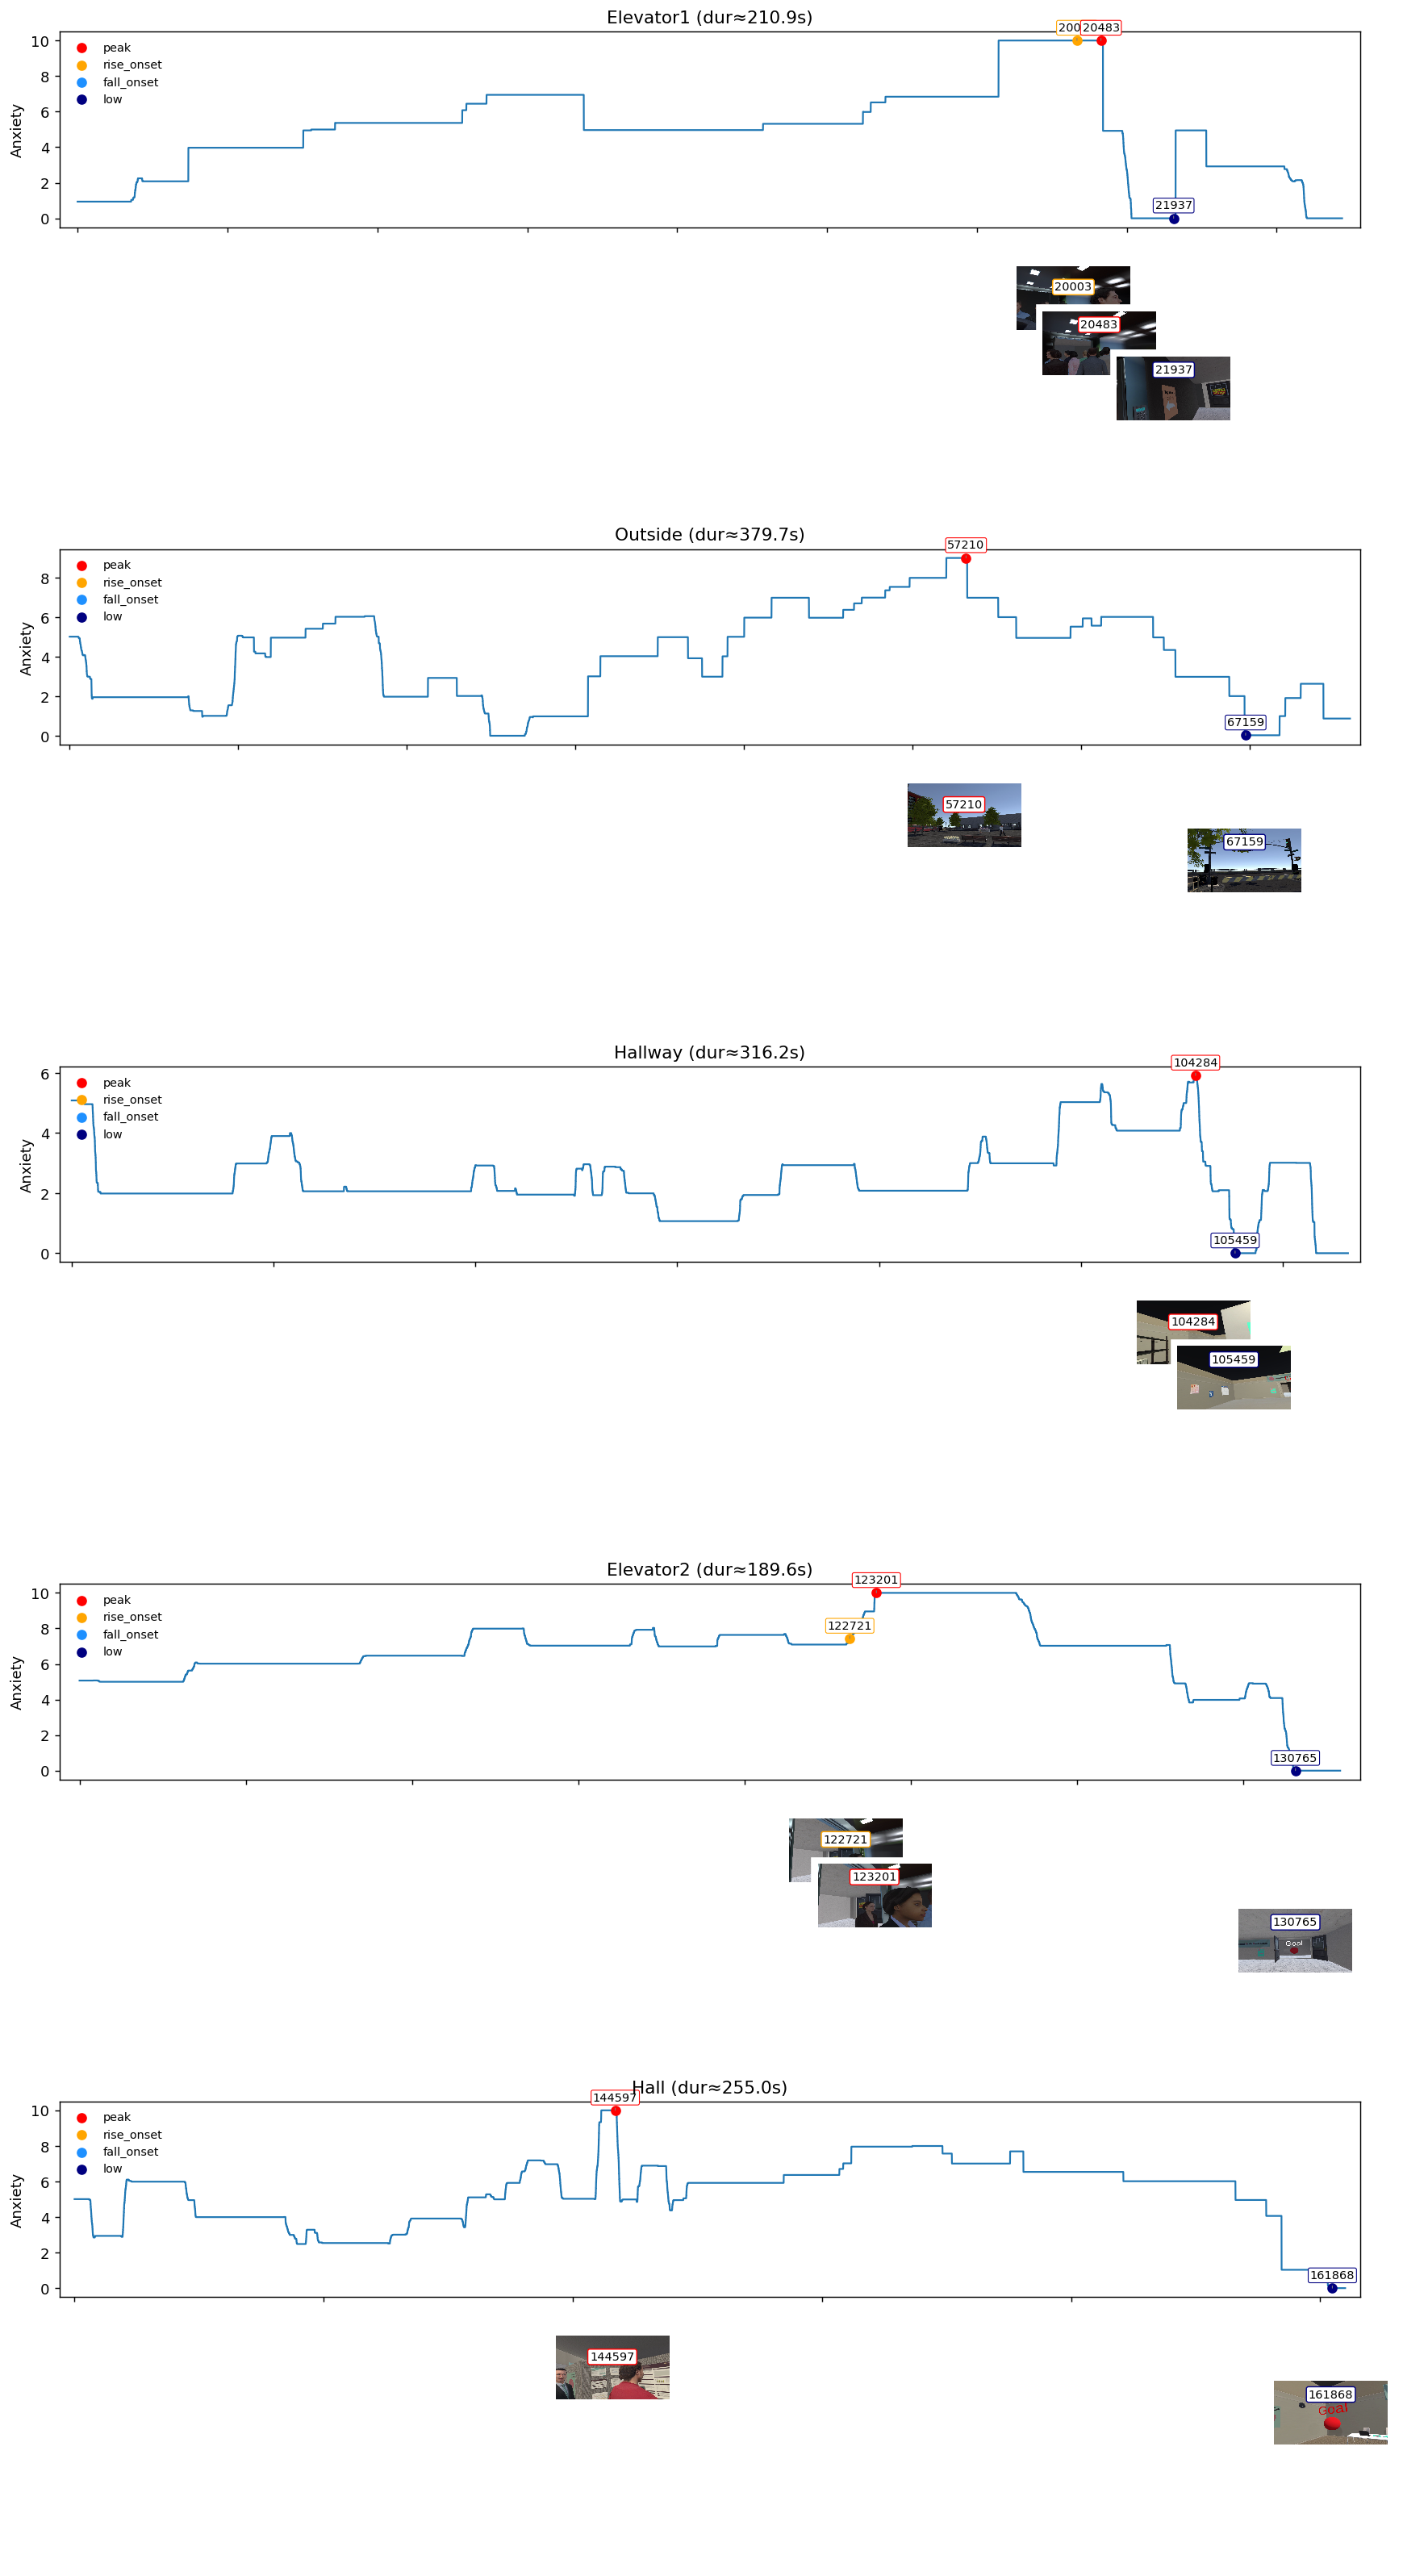


[Mapping] label ↔ (scene,event,t_scene,frame,time)
 label  mode     scene      event    t_scene  frame        time
 20003 frame Elevator1 rise_onset 166.691667  20003  166.691667
 20483 frame Elevator1       peak 170.691667  20483  170.691667
 21937 frame Elevator1        low 182.808333  21937  182.808333
122721 frame Elevator2 rise_onset 115.866667 122721 1022.675000
123201 frame Elevator2       peak 119.866667 123201 1026.675000
130765 frame Elevator2        low 182.900000 130765 1089.708333
144597 frame      Hall       peak 108.525000 144597 1204.975000
161868 frame      Hall        low 252.450000 161868 1348.900000
104284 frame   Hallway       peak 278.400000 104284  869.033333
105459 frame   Hallway        low 288.191667 105459  878.825000
 57210 frame   Outside       peak 265.825000  57210  476.750000
 67159 frame   Outside        low 348.733333  67159  559.658333


In [2]:
# ===== 사용자 설정 =====
FS = 120.0
FILE_PATH = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized\001_Main.pkl"
VIDEO_PATHS = {
    "Elevator1": "./VideoTest/001_Elevator1.mp4",
    "Outside":   "./VideoTest/001_Outside.mp4",
    "Hallway":   "./VideoTest/001_Hallway.mp4",
    "Elevator2": "./VideoTest/001_Elevator2.mp4",
    "Hall":      "./VideoTest/001_Hall.mp4",
}
OFFSET_BY_SCENE = {
    # "Hallway": 0.00,
}

# 로드
df = pd.read_pickle(FILE_PATH).copy()
if "time" not in df.columns:
    df["time"] = df.index / FS

# 1) 이벤트 검출
df_events = detect_events_pro(df, fs=FS)

# 2) 대표 이벤트 선택
df_sel = select_events_balanced(
    df_events, fs=FS,
    keep_types=("peak","rise_onset","fall_onset","low"),
    min_gap_s=1.5, bin_secs=8.0,
    max_per_scene=20, max_total=120
)
bank = VideoBank(VIDEO_PATHS, offset_by_scene=OFFSET_BY_SCENE)
def grab_rgb(scene, t_scene):
    ok, bgr = bank.read(scene, t_scene)
    if not ok or bgr is None: return None
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
df_sel["thumb"] = [grab_rgb(r.scene, r.t_scene) for r in df_sel.itertuples(index=False)]

# 플롯: 3줄 배치 + 번호 동기화 + 피크/로우 색상
scenes = ["Elevator1","Outside","Hallway","Elevator2","Hall"]
# 3) 플롯 (번호 = 프레임 인덱스)
plot_per_scene_with_strip_numbered(
    df, df_sel, bank,
    scenes_order=["Elevator1","Outside","Hallway","Elevator2","Hall"],
    thumb_width_secs=6.0,
    n_lanes=5,                          # 4 → 5 (필요시 4로 둬도 OK)
    strip_height_ratio=2.2,             # 2 → 2.2
    line_height_ratio=2,
    max_per_scene=20,
    numbering_mode="frame",
    figsize_per_scene=(16, 6.4),        # (16,6.2) → (16,6.4)
    dpi=130,
    save_path="per_scene_anxiety_thumbs.png"
)

[INFO] 전체 이벤트=3642, 선택된 피크=13
[SAVE] per_scene_anxiety_thumbs.png


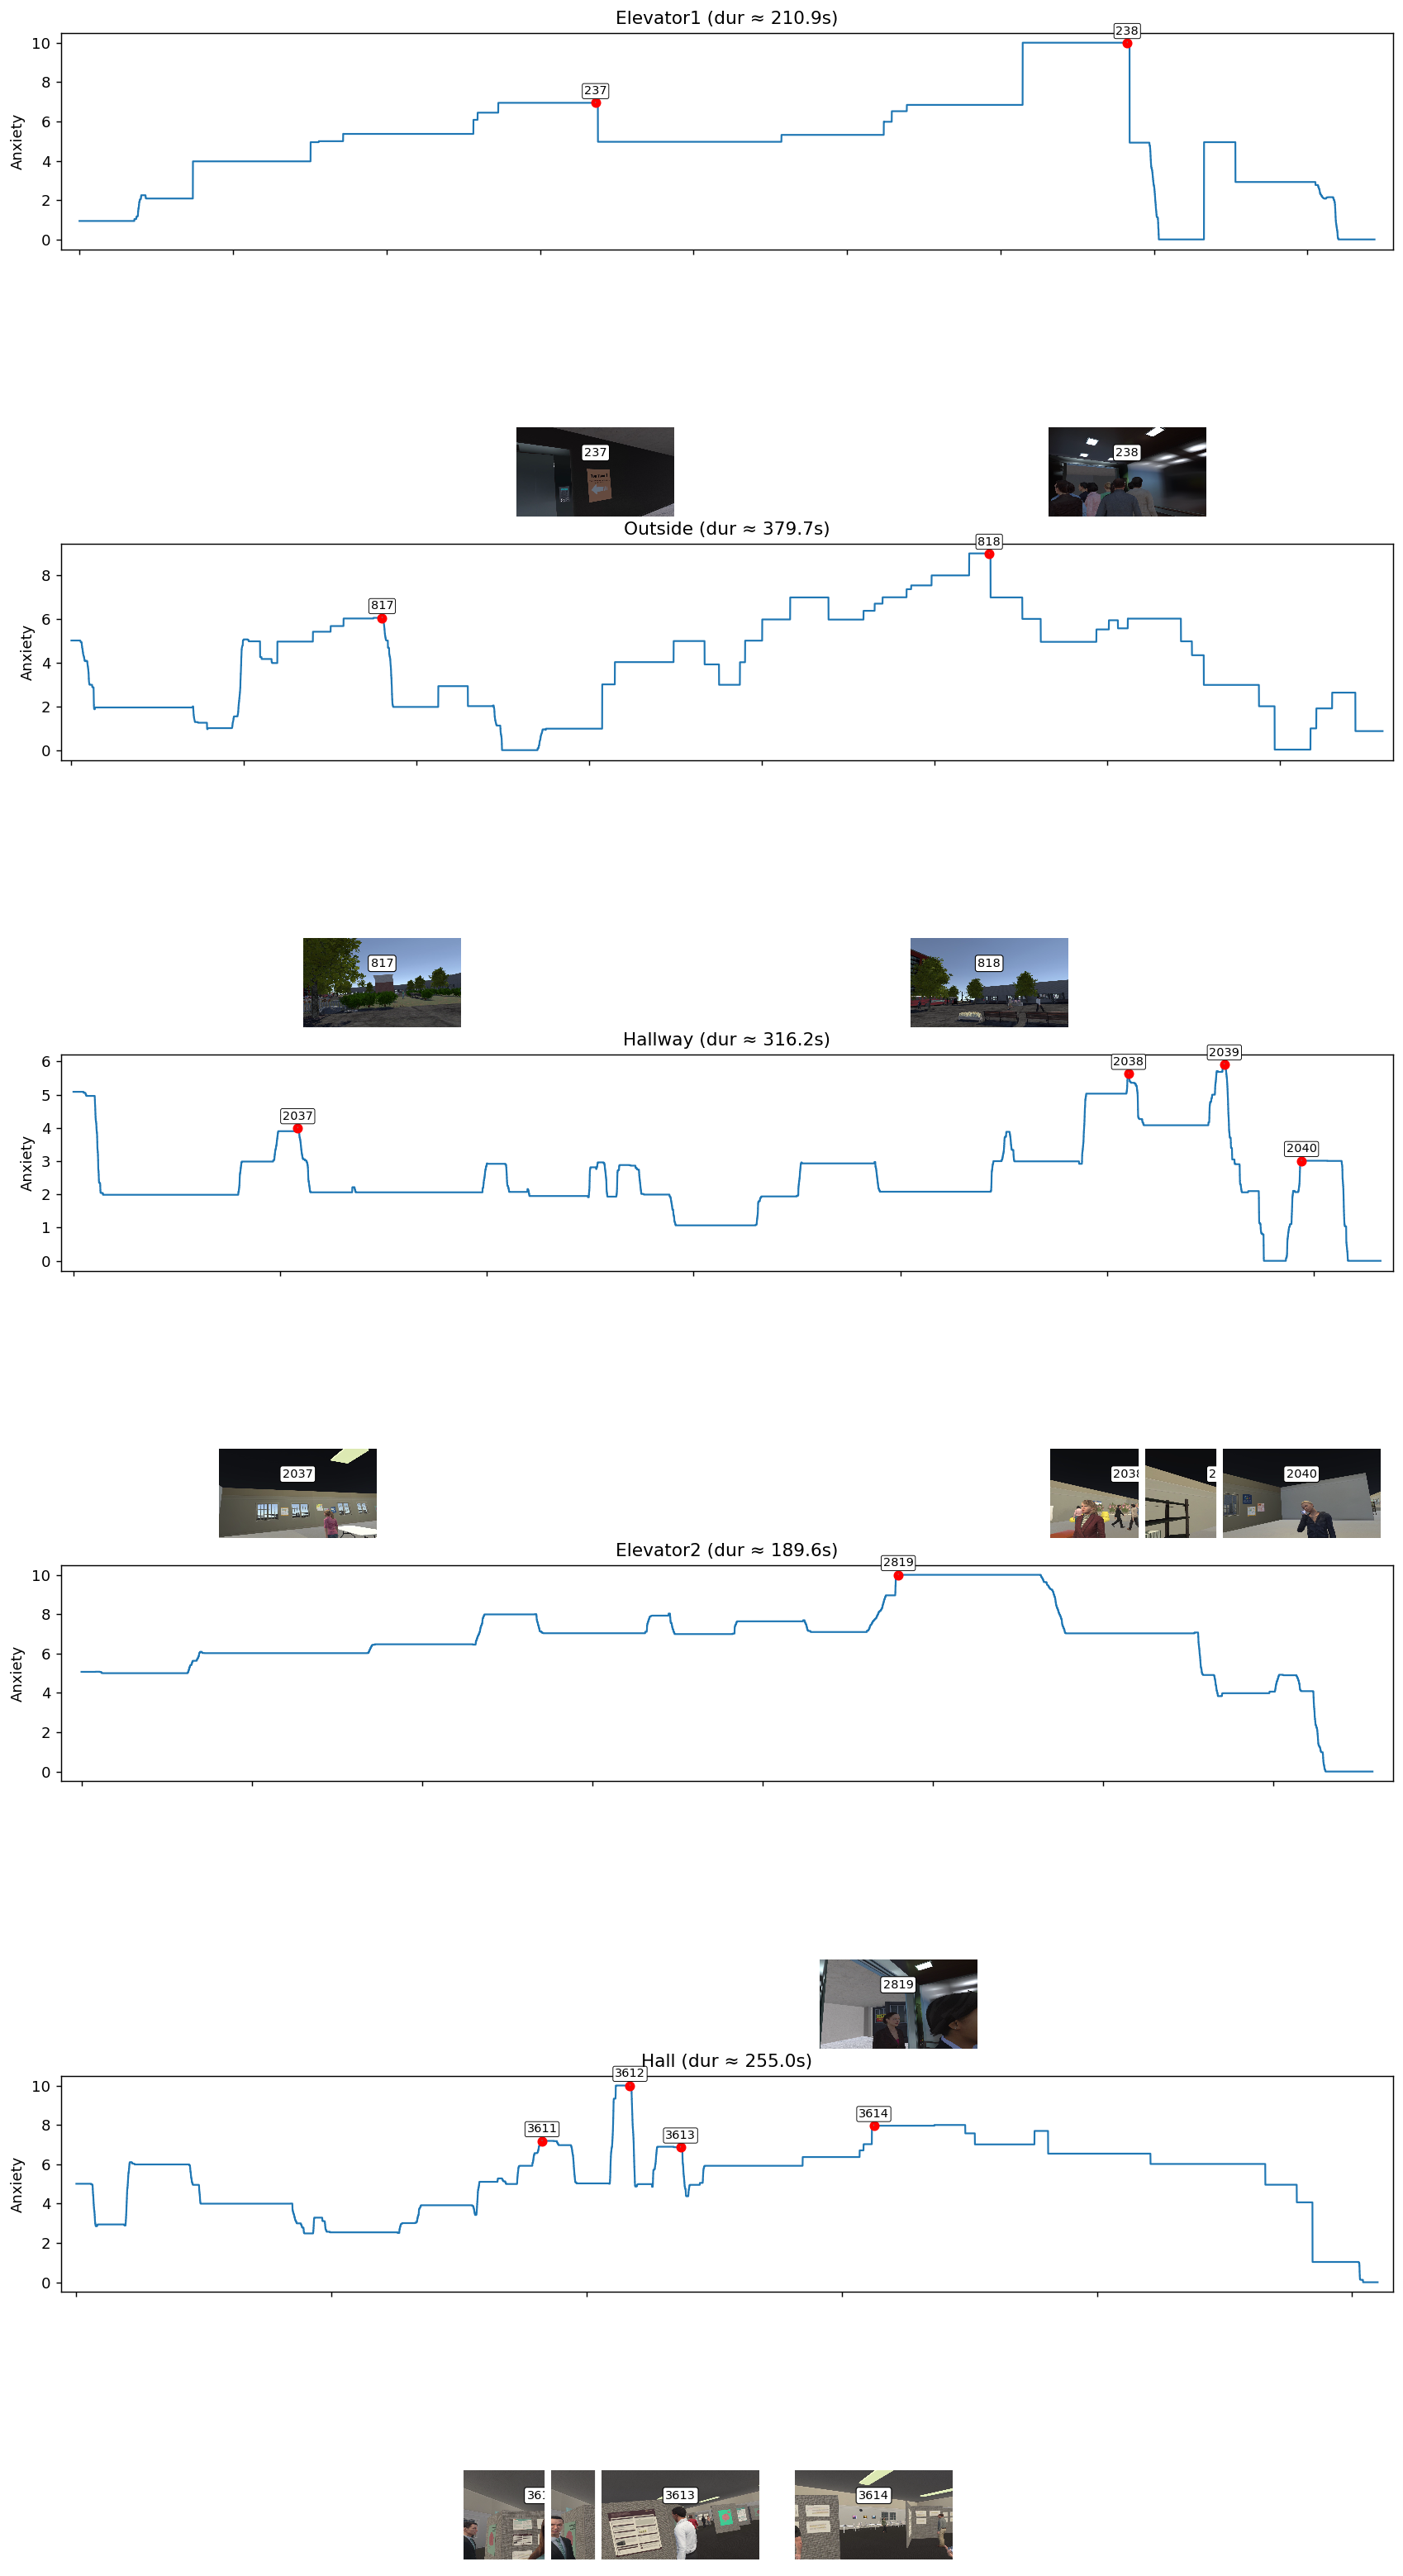


[ID Mapping: peak point ↔ thumbnail]
 eid     scene    t_scene        time   anxiety
 237 Elevator1  84.050000   84.050000  6.944444
 238 Elevator1 170.641667  170.641667 10.000000
2819 Elevator2 119.975000 1026.783333 10.000000
3611      Hall  91.266667 1187.716667  7.185185
3612      Hall 108.508333 1204.958333 10.000000
3613      Hall 118.408333 1214.858333  6.864198
3614      Hall 156.283333 1252.733333  7.956790
2037   Hallway  54.250000  644.883333  4.000000
2038   Hallway 255.216667  845.850000  5.635802
2039   Hallway 278.383333  869.016667  5.919753
2040   Hallway 297.041667  887.675000  3.012346
 817   Outside  89.975000  300.900000  6.049383
 818   Outside 265.775000  476.700000  8.993827


In [8]:
# ===== 사용자 설정 =====
FS = 120.0
FILE_PATH = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized\001_Main.pkl"
VIDEO_PATHS = {
    "Elevator1": "./VideoTest/001_Elevator1.mp4",
    "Outside":   "./VideoTest/001_Outside.mp4",
    "Hallway":   "./VideoTest/001_Hallway.mp4",
    "Elevator2": "./VideoTest/001_Elevator2.mp4",
    "Hall":      "./VideoTest/001_Hall.mp4",
}
OFFSET_BY_SCENE = {
    # "Hallway": 0.00,
}

# ===== 로드 =====
df = pd.read_pickle(FILE_PATH).copy()
if "time" not in df.columns:
    df["time"] = df.index / FS

# ===== 이벤트 검출: 고점 위주 =====
df_events = detect_events_adaptive_by_scene_strict(
    df, fs=FS,
    min_dist_s=0.8,
    height_pct=75.0,   # 더 고점만 원하면 80~90으로 올리세요
    z_min_prom=1.0,    # 너무 많이 찍히면 1.2~1.5로 올리기
    plateau_min_s=0.2,
    flat_thresh=0.02
)

# ===== 대표 이벤트 선택: 피크만, 더 균형있게 =====
df_sel = select_events_for_thumbs(
    df_events, fs=FS,
    min_gap_s=1.5,
    bin_secs=6.0,
    max_per_scene=20,
    max_total=80,
    only_event_types=("peak",)   # 썸네일은 피크만
)

print(f"[INFO] 전체 이벤트={len(df_events)}, 선택된 피크={len(df_sel)}")

# ===== 비디오 뱅크 & 썸네일 미리 캐시(선택) =====
bank = VideoBank(VIDEO_PATHS, offset_by_scene=OFFSET_BY_SCENE)
def grab_rgb(scene: str, t_scene: float):
    ok, bgr = bank.read(scene, t_scene)
    if not ok or bgr is None:
        print(f"[WARN] frame miss @ scene={scene}, t={t_scene:.2f}")
        return None
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

df_sel["thumb"] = [
    grab_rgb(row.scene, row.t_scene) if row.scene in VIDEO_PATHS else None
    for row in df_sel.itertuples(index=False)
]

# ===== 플로팅: 4줄 lanes, 번호 동기화 =====
scenes = ["Elevator1", "Outside", "Hallway", "Elevator2", "Hall"]
plot_per_scene_with_strip_numbered(
    df, df_sel, bank,
    scenes_order=scenes,
    thumb_width_secs=6.0,
    n_lanes=4,                       # ← 필요시 3/4로 조절
    strip_height_ratio=1,
    line_height_ratio=1,
    max_per_scene=20,
    figsize_per_scene=(16, 6.2),
    dpi=130,
    save_path="per_scene_anxiety_thumbs.png"
)


C:\Users\user\AppData\Local\Temp\ipykernel_20156\801288857.py:140: PeakPropertyWarning: some peaks have a prominence of 0
  pk_idx, pk_prop = find_peaks(z_s, prominence=prom_pk, height=z_height,
C:\Users\user\AppData\Local\Temp\ipykernel_20156\801288857.py:142: PeakPropertyWarning: some peaks have a prominence of 0
  vl_idx, vl_prop = find_peaks(-z_s, prominence=prom_low, height=z_height,


[INFO] 전체 이벤트 수=3629, 선택된 대표 이벤트 수=80
[SAVE] per_scene_anxiety_thumbs.png


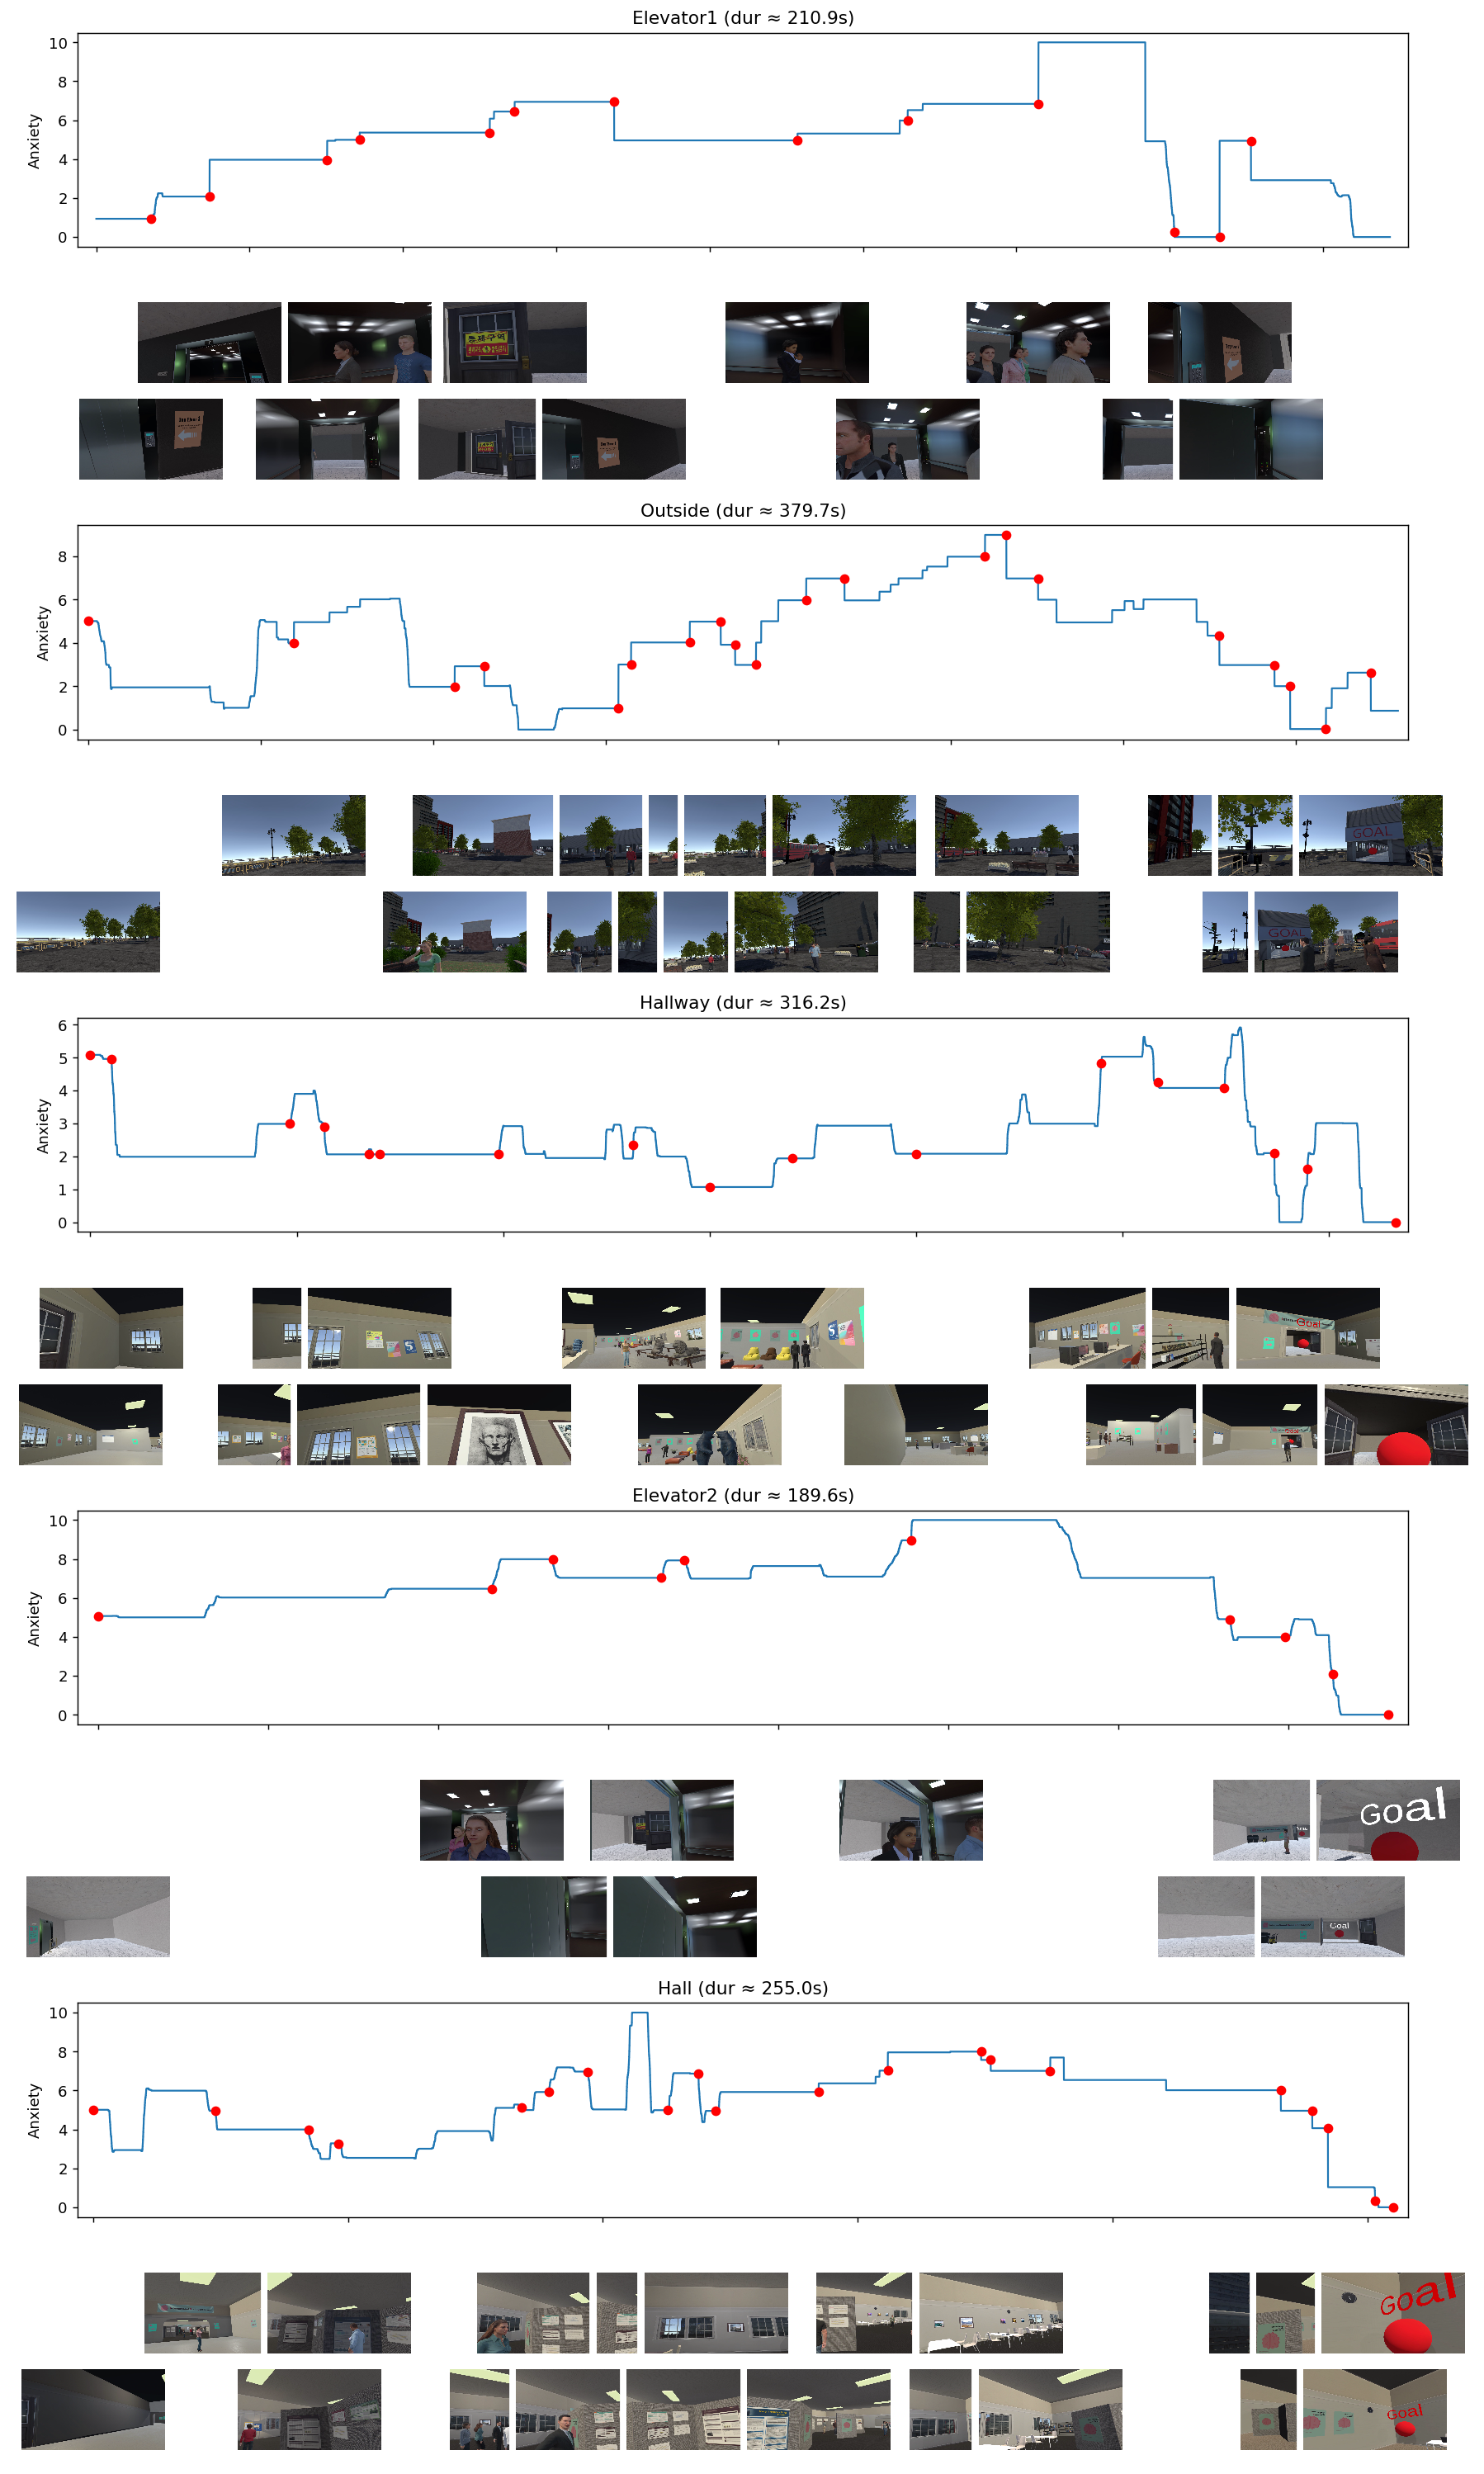

In [6]:
# =========================================================
#             Anxiety 이벤트 → 비디오 썸네일 파이프라인
#                   (120 Hz, scene별 파일)
# =========================================================
import os, math, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import find_peaks

# -------------------------------
# [사용자 설정]
# -------------------------------
FS = 120.0  # 샘플링 주파수(Hz)
FILE_PATH = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized\001_Main.pkl"  # df 경로
VIDEO_PATHS = {
    # 질문 예시대로 Hallway만 우선 지정 (다른 scene은 없으면 자동으로 스킵)
    "Hallway": "./VideoTest/001_Hallway.mp4",
    "Elevator1": "./VideoTest/001_Elevator1.mp4",
    "Outside": "./VideoTest/001_Outside.mp4",
    "Elevator2": "./VideoTest/001_Elevator2.mp4",
    "Hall": "./VideoTest/001_Hall.mp4",
}
# (필요시) 장면별 고정 오프셋(초) 보정
OFFSET_BY_SCENE = {
    # "Hallway": +0.00,
}

# 이벤트 검출/선정 파라미터 (데이터 스케일에 맞춰 조절)
PEAK_PROM   = 0.04     # 봉우리 선명도(peak)
DROP_PROM   = 0.08     # 봉우리 선명도(drop: -anxiety에 적용)
MIN_DIST_S  = 1.0      # 이벤트 간 최소 간격(초)
FLAT_WIN_S  = 30.0     # flat 판정 롤링 std 창(초)
FLAT_STD_THR= 0.01     # flat 표준편차 임계

# 대표 이벤트 선택(너무 많을 때 요약)
SEL_MIN_GAP_S   = 3.0     # 가까운 이벤트 병합 간격(초)
SEL_BIN_SECS    = 10.0    # 타임라인을 n초 빈으로 나눠 빈당 1개
SEL_MAX_PER_SC  = 8       # 장면당 최대 표시
SEL_MAX_TOTAL   = 30      # 전체 최대 표시

# 시각화
FIGSIZE = (16, 8)
THUMB_WIDTH_SECS = 10.0    # 아래 썸네일 한 장의 가로폭(초)
DPI = 120
OUT_PNG = "anxiety_events_with_thumbs.png"  # 저장 파일명 (원치 않으면 None로)


# -------------------------------
# 데이터 로드 & 시간 컬럼 준비
# -------------------------------
df = pd.read_pickle(FILE_PATH)
df = df.copy()
df["time"] = df.index / 120.0
df_events = detect_events_adaptive_by_scene(
    df, fs=FS,
    min_dist_s=0.8,
    z_prom=1.0,
    plateau_min_s=0.2,
    wlen_s=5.0,
    topk_per_scene=1
)

df_sel = select_events_for_thumbs(
    df_events, fs=FS,
    min_gap_s=1.5,     # 더 촘촘히 보려면 1.0~1.5
    bin_secs=6.0,      # 시간 균형을 더 촘촘히
    max_per_scene=20,
    max_total=80
)

print(f"[INFO] 전체 이벤트 수={len(df_events)}, 선택된 대표 이벤트 수={len(df_sel)}")

# -------------------------------
# 비디오 프레임 캡처(장면 상대시간 사용)
# -------------------------------
bank = VideoBank(VIDEO_PATHS, offset_by_scene=OFFSET_BY_SCENE)

def grab_rgb(scene: str, t_scene: float):
    ok, bgr = bank.read(scene, t_scene)
    if not ok or bgr is None:
        print(f"[WARN] frame miss @ scene={scene}, t={t_scene:.2f}s (video path missing or seek fail)")
        return None
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

df_sel["thumb"] = [
    grab_rgb(row.scene, row.t_scene) if row.scene in VIDEO_PATHS else None
    for row in df_sel.itertuples(index=False)
]


# 장면 순서 지정(원하시는 순서로)
scenes = ["Elevator1", "Outside", "Hallway", "Elevator2", "Hall"]

plot_per_scene_with_strip(
    df, df_sel, bank,
    scenes_order=scenes,
    thumb_width_secs=6.0,          # 가로폭 키움
    lanes_y=[0.05, 0.60],          # 스트립 내에서 더 크게
    strip_height_ratio=1,          # 아래 영역 비율(1→2로 키우면 스트립 더 두꺼움)
    line_height_ratio=1,           # 위 영역 비율
    max_per_scene=20,
    figsize_per_scene=(16, 6.0),   # 장면 블록 자체를 더 높게
    dpi=130,
    save_path="per_scene_anxiety_thumbs.png"
)


[SAVE] per_scene_anxiety_thumbs.png


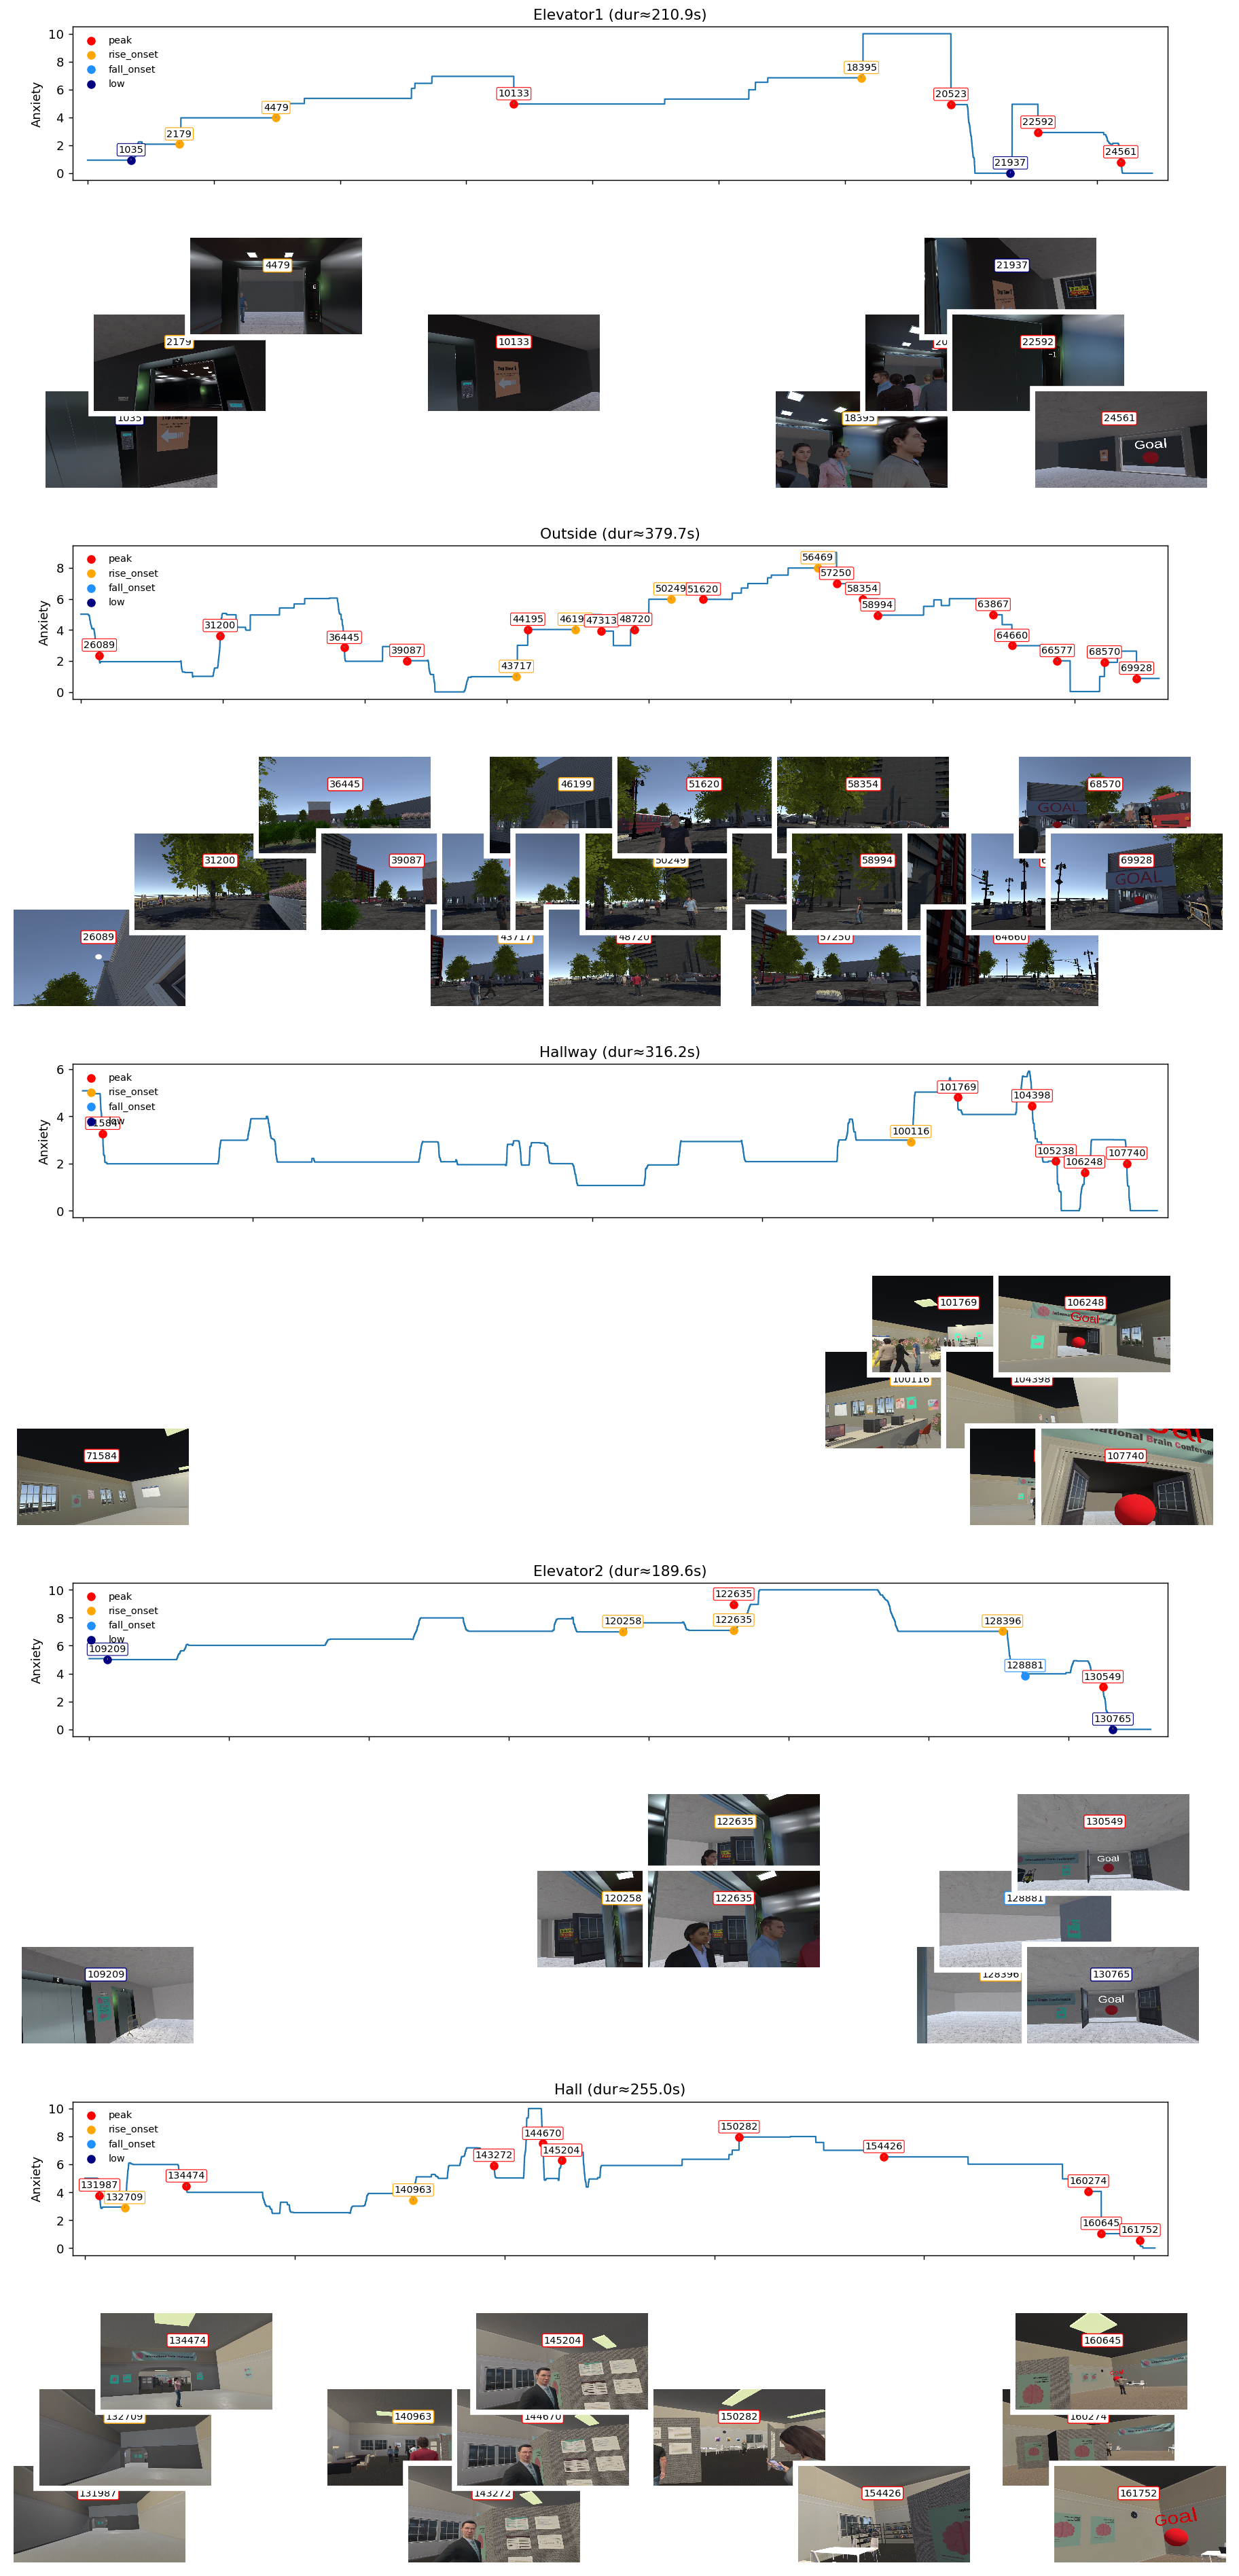


[Mapping] label ↔ (scene,event,t_scene,frame,time)
 label  mode     scene      event    t_scene  frame        time
  1035 frame Elevator1        low   8.625000   1035    8.625000
  2179 frame Elevator1 rise_onset  18.158333   2179   18.158333
  4479 frame Elevator1 rise_onset  37.325000   4479   37.325000
 10133 frame Elevator1       peak  84.441667  10133   84.441667
 18395 frame Elevator1 rise_onset 153.291667  18395  153.291667
 20523 frame Elevator1       peak 171.025000  20523  171.025000
 21937 frame Elevator1        low 182.808333  21937  182.808333
 22592 frame Elevator1       peak 188.266667  22592  188.266667
 24561 frame Elevator1       peak 204.675000  24561  204.675000
109209 frame Elevator2        low   3.266667 109209  910.075000
120258 frame Elevator2 rise_onset  95.341667 120258 1002.150000
122635 frame Elevator2 rise_onset 115.150000 122635 1021.958333
122635 frame Elevator2       peak 115.150000 122635 1025.958333
128396 frame Elevator2 rise_onset 163.158333 128396 

In [1]:
# ========================= PATCH START (full script) =========================
# 이벤트 검출 + 썸네일 배치(겹침 방지) + 실행부 통째로 교체
# ============================================================================

import os, math, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage import median_filter

# -------------------------------
# 설정
# -------------------------------
FS = 120.0
FILE_PATH = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized\001_Main.pkl"
VIDEO_PATHS = {
    "Elevator1": "./VideoTest/001_Elevator1.mp4",
    "Outside":   "./VideoTest/001_Outside.mp4",
    "Hallway":   "./VideoTest/001_Hallway.mp4",
    "Elevator2": "./VideoTest/001_Elevator2.mp4",
    "Hall":      "./VideoTest/001_Hall.mp4",
}
OFFSET_BY_SCENE = {
    # "Hallway": 0.00,
}

# -------------------------------
# 유틸: 비디오 리더
# -------------------------------
class SceneVideo:
    def __init__(self, path: str, pos="msec", offset: float = 0.0):
        self.path = path
        self.pos_mode = pos  # "msec" or "frame"
        self.offset = float(offset)
        self.cap = cv2.VideoCapture(path)
        if not self.cap.isOpened():
            raise RuntimeError(f"Cannot open video: {path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30.0
        self.nf  = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        self.dur = self.nf / self.fps if self.fps > 0 else None

    def __del__(self):
        try:
            if hasattr(self, "cap") and self.cap is not None:
                self.cap.release()
        except Exception:
            pass

    def _seek(self, t_sec: float) -> bool:
        if self.pos_mode == "msec":
            return self.cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, t_sec) * 1000.0)
        f_idx = int(round(max(0.0, t_sec) * self.fps))
        f_idx = min(max(0, f_idx), max(0, self.nf - 1))
        return self.cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx)

    def read_at(self, t_scene_sec: float, nearest_if_fail=True):
        if t_scene_sec is None or math.isnan(t_scene_sec):
            return False, None
        t_eff = t_scene_sec + self.offset
        if self.dur is not None:
            t_eff = min(max(0.0, t_eff), max(0.0, self.dur - 1e-3))
        self._seek(t_eff)
        ok, frame = self.cap.read()
        if not ok or frame is None:
            if not nearest_if_fail:
                return False, None
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, self.nf - 1))
            ok2, frame2 = self.cap.read()
            return ok2 and frame2 is not None, frame2
        return True, frame

class VideoBank:
    def __init__(self, scene_to_path: dict, offset_by_scene=None):
        self.items = {}
        self.offsets = offset_by_scene or {}
        for sc, p in scene_to_path.items():
            if not os.path.exists(p):
                continue
            self.items[sc] = SceneVideo(p, pos="msec", offset=float(self.offsets.get(sc, 0.0)))

    def read(self, scene: str, t_scene_sec: float):
        if scene not in self.items:
            return False, None
        return self.items[scene].read_at(t_scene_sec)

# -------------------------------
# 신호 전처리 / 이벤트 검출
# -------------------------------
def _robust_z(y):
    med = np.median(y)
    mad = np.median(np.abs(y - med)) + 1e-9
    return (y - med) / (1.4826 * mad)

def _smooth(x, fs, med_win_s=0.5, sg_win_s=1.0, sg_poly=2):
    med = int(max(1, round(med_win_s * fs)))
    sg  = int(max(3, round(sg_win_s * fs)) // 2 * 2 + 1)
    return savgol_filter(median_filter(x, med), sg, sg_poly)

def detect_events_pro(
    df: pd.DataFrame, fs: float=120.0,
    *,
    min_dist_s: float = 0.7,
    prom_z_min_peak: float = 0.5,      # base
    topk_peak: int = 8, topk_low: int = 4,
    med_win_s: float = 0.4, sg_win_s: float = 0.8, sg_poly: int = 2,
    plateau_min_s: float = 0.18,
    search_win_s: float = 4.0
):
    """
    - prominence: 퍼센타일 대신 robust absolute scale 사용 (평탄/계단형에서도 동작)
    - rise_onset: +γ(기울기) 히스테리시스 첫 진입점, 실패 시 직전 국소최저
    - fall_onset: -γ 히스테리시스 첫 진입점, 실패 시 음기울기 최댓점
    """
    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    rows = []
    eid = 1
    distance = max(1, int(round(min_dist_s * fs)))
    plateau_size = int(max(1, round(plateau_min_s * fs)))
    win = int(max(1, round(search_win_s * fs)))

    for sc, g in df.groupby("scene", sort=False):
        y   = g["anxiety"].astype(float).to_numpy()
        t   = g["time"].to_numpy()
        ts  = g["t_scene"].to_numpy()
        idx = g.index.to_numpy()

        z   = _robust_z(y)
        z_s = _smooth(z, fs, med_win_s, sg_win_s, sg_poly)
        dz  = np.gradient(z_s)

        # robust scale
        rob = 1.4826*np.median(np.abs(z_s - np.median(z_s))) + 1e-9
        prom_abs_pk = max(prom_z_min_peak, 0.8*rob)
        prom_abs_lo = max(0.4*prom_z_min_peak, 0.5*rob)

        # === REPLACE ONLY THIS BLOCK inside detect_events_pro(...) ====================
        # 기존 "# 1. peak / low" 섹션 전체를 아래로 교체

        # -------------------------------
        # 1. peak / low  (z, y, gradient 합성)
        # -------------------------------
        y_s  = _smooth(y, fs, med_win_s, sg_win_s, sg_poly)   # 원신호 기반 스무딩
        z    = _robust_z(y_s)                                 # 스무딩 후 z
        z_s  = z                                              # (이후 동일 변수명 사용)
        dz   = np.gradient(y_s)                               # 원신호 기울기
        ddz  = np.gradient(dz)                                # 2차 미분(곡률)

        # robust scale
        rob_z  = 1.4826*np.median(np.abs(z_s - np.median(z_s))) + 1e-9
        rob_y  = 1.4826*np.median(np.abs(y_s - np.median(y_s))) + 1e-9
        rob_dz = 1.4826*np.median(np.abs(dz - np.median(dz))) + 1e-9

        prom_z_abs = max(prom_z_min_peak, 0.8*rob_z)
        prom_y_abs = max(0.05*(np.percentile(y_s, 95)-np.percentile(y_s, 5)), 0.6*rob_y)

        # (A) z 기반
        pk_z, prop_z = find_peaks(z_s, prominence=prom_z_abs, distance=distance, plateau_size=plateau_size)
        # (B) y 기반
        pk_y, prop_y = find_peaks(y_s, prominence=prom_y_abs, distance=distance, plateau_size=plateau_size)
        # (C) 기울기 스파이크(양→음 전환 전후의 큰 봉우리) 후보: |dz| 피크
        pk_g, _      = find_peaks(np.abs(dz), prominence=max(0.8*rob_dz, 0.02), distance=distance)

        # 통합
        pk_idx = np.unique(np.concatenate([pk_z, pk_y, pk_g]))
        # 최소 개수 보장: 곡률 상위(top-k)
        if len(pk_idx) < topk_peak:
            topk_curv = np.argsort(np.abs(ddz))[::-1][:topk_peak]
            pk_idx = np.unique(np.concatenate([pk_idx, topk_curv]))
        pk_idx = np.sort(pk_idx)

        # low는 z 기준으로
        lo_idx, _ = find_peaks(-z_s, prominence=max(0.5*prom_z_abs, 0.5*rob_z),
                            distance=distance, plateau_size=plateau_size)
        if len(lo_idx) < topk_low:
            topk_lo = np.argsort(z_s)[:topk_low]
            lo_idx  = np.unique(np.concatenate([lo_idx, topk_lo]))


        # 기울기 히스테리시스 임계
        rob_dz = 1.4826*np.median(np.abs(dz - np.median(dz))) + 1e-9
        gamma  = max(0.2, 0.35*rob_dz)  # 0.2~0.4*rob_dz 권장

        # -------------------------------
        # 2. rise_onset / fall_onset
        # -------------------------------
        dz = np.gradient(z_s)  # z_s는 위에서 정의된 smoothing된 z-score 신호

        def add(event, i, prom=0.0, grad=0.0):
            nonlocal eid
            j = int(np.clip(i, 0, len(y)-1))
            rows.append({
                "eid": eid, "scene": str(sc), "event": event,
                "index": int(idx[j]), "frame": int(idx[j]),
                "time": float(t[j]), "t_scene": float(ts[j]),
                "anxiety": float(y[j]),
                "score_prom": float(prom),
                "score_grad": float(grad)
            })
            eid += 1

        gid = 1  # ← scene 내 그룹 id(peak-연계용)

        for i in np.sort(pk_idx):
            # peak 점수(대용): z, y, |dz| 조합
            prom = float(abs(z_s[i])) * 0.5 + float(abs(y_s[i])) * 0.3 + float(abs(dz[i])) * 0.2

            # ---- PEAK ----
            add("peak", i, prom=prom)             # peak row
            rows[-1]["gid"] = gid                 # ← 동일 gid 부여

            # ---- RISE_ONSET: +γ 첫 진입, 실패 시 직전 최저 ----
            L = max(0, i - win)
            if L < i:
                seg = slice(L, i)
                pos = np.where((dz[seg][1:] >= +gamma) & (dz[seg][:-1] < +gamma))[0]
                if len(pos):
                    j_rise = L + int(pos[0] + 1)
                else:
                    j_rise = L + int(np.argmin(z_s[L:i+1]))
                add("rise_onset", j_rise)
                rows[-1]["gid"] = gid

            # ---- FALL_ONSET: -γ 첫 진입, 실패 시 음기울기 최대, 그래도 없으면 오른쪽 최소 ----
            R = min(len(z_s)-1, i + win)
            if i < R:
                seg = slice(i, R)
                neg = np.where((dz[seg][1:] <= -gamma) & (dz[seg][:-1] > -gamma))[0]
                if len(neg):
                    j_fall = i + int(neg[0] + 1)
                else:
                    j_fall = i + int(np.argmax(-dz[seg]))
                    if j_fall == i:  # 여전히 못 찾았으면 오른쪽 최소로 대체
                        j_fall = i + int(np.argmin(z_s[i:R+1]))
                add("fall_onset", j_fall, grad=float(abs(dz[j_fall])))
                rows[-1]["gid"] = gid

            gid += 1  # 다음 peak 그룹

        # ---- LOW: 일반 + 엣지 보강(시작/끝 근처) ----
        for i in np.sort(lo_idx):
            add("low", i)

        # 엣지 보강: 시작/끝 10초 안에서 최저를 별도 후보로 추가
        edge_w = int(round(min(10.0, (t[-1]-t[0])) * fs))
        if edge_w > 5:
            i0 = int(np.argmin(z_s[:edge_w]))
            i1 = int(np.argmin(z_s[-edge_w:])) + (len(z_s)-edge_w)
            for j in [i0, i1]:
                # 이미 근처 low가 있으면 건너뜀
                if np.min(np.abs(lo_idx - j)) if len(lo_idx) else 1e9 > distance//2:
                    add("low", int(j))


        add("max_point", int(np.argmax(y)))
        add("min_point", int(np.argmin(y)))

    return pd.DataFrame(rows).sort_values(["scene","time"]).reset_index(drop=True)

# -------------------------------
# 이벤트 선택 (균형/밀집 제어)
# -------------------------------
def select_events_balanced(
    df_events: pd.DataFrame, fs: float,
    *,
    keep_types=("peak","rise_onset","fall_onset","low"),
    min_gap_s: float = 1.5,
    bin_secs: float  = 8.0,
    max_per_scene: int = 20,
    max_total: int = 120
):
    if df_events.empty: return df_events
    df = df_events[df_events["event"].isin(keep_types)].copy()
    if df.empty: return df

    prom = df.get("score_prom", 0.0)
    grad = df.get("score_grad", 0.0)
    # rise 비중을 약간 올려 peak偏을 완화
    df["score"] = (
        1.0*prom + 0.5*grad
        + df["event"].map({
            "rise_onset":0.18, "fall_onset":0.12,
            "peak":0.10, "low":0.05
        }).fillna(0.0)
    )
    # (1) scene별 시간 오름차순으로 보되 score 높은 것 우선, 최소 간격 적용
    keep = []
    for sc, g in df.sort_values(["scene","time","score"], ascending=[True,True,False]).groupby("scene"):
        last = -1e9
        for i,r in g.iterrows():
            if r["time"] - last >= min_gap_s:
                keep.append(i); last = r["time"]
    df = df.loc[keep].sort_values(["scene","time"])

    # (2) 균형 bin
    df["bin"] = (df["time"] // bin_secs).astype(int)
    pick = []
    for (sc,b), g in df.groupby(["scene","bin"]):
        pick.append(g["score"].idxmax())
    df = df.loc[pick]

    # (3) 상한
    outs = []
    for sc,g in df.groupby("scene"):
        outs.append(g.sort_values("score", ascending=False).head(max_per_scene))
    out = pd.concat(outs).sort_values(["scene","time"])
    if len(out) > max_total:
        out = out.sort_values("score", ascending=False).head(max_total).sort_values(["scene","time"])
    return out.drop(columns=["bin"], errors="ignore").reset_index(drop=True)

# -------------------------------
# 레이아웃/겹침 방지
# -------------------------------
def _auto_zoom(ax_strip, img_h_px: int, n_lanes: int, lane_margin: float = 0.25):
    """
    축(bbox) 픽셀 높이 기준으로 lane당 band 픽셀을 계산해 zoom 산출.
    fig.canvas.draw() 이후 호출되어야 정확함.
    """
    bbox = ax_strip.get_window_extent().transformed(ax_strip.figure.dpi_scale_trans.inverted())
    ax_h_px = max(1.0, bbox.height * ax_strip.figure.dpi)
    band_px = ax_h_px / max(1, n_lanes)
    target_px = band_px * (1.0 - lane_margin)
    z = target_px / max(1, img_h_px)
    return float(np.clip(z, 0.02, 0.08))

def _assign_lanes_interval(ev_sc, width_s: float, n_lanes: int, lane_y=None, sep=1.35, mode="zigzag"):
    """
    밀도 적응형 x-충돌 회피 + lane y 간격 확대(0.92~0.08)
    """
    if lane_y is None:
        lane_y = np.linspace(0.92, 0.08, n_lanes)
    last_end = np.full(n_lanes, -1e9, dtype=float)
    half = width_s/2.0

    def order_gen():
        if mode == "roundrobin":
            k=0
            while True: 
                yield k % n_lanes; k += 1
        else:
            order = list(range(n_lanes)) + list(range(n_lanes-2,0,-1))
            k=0
            while True:
                yield order[k % len(order)]; k += 1

    gen = order_gen()
    out=[]
    ts = ev_sc["t_scene"].to_numpy(dtype=float)

    def local_sep_factor(x, ts, base_sep, width_s):
        d = np.min(np.abs(ts - x) + 1e-9)
        f = np.clip((width_s / max(d, 1e-6)), 1.0, 2.0)  # 가까울수록 factor↑
        return base_sep * float(f)

    for r in ev_sc.itertuples(index=False):
        x = float(r.t_scene); placed=False
        need_i = local_sep_factor(x, ts, base_sep=sep, width_s=width_s) * width_s

        first = next(gen)
        cand=[first]+[i for i in range(n_lanes) if i!=first]
        for li in cand:
            if (x-half) >= (last_end[li] + (need_i-width_s)):
                out.append((x, lane_y[li])); last_end[li]=x+half; placed=True; break
        if not placed:
            li = int(np.argmin(last_end))
            out.append((x, lane_y[li])); last_end[li]=x+half
    return out, lane_y
# === PUT/REPLACE: helpers (파일 상단, import 아래 아무데나) =================

def _lane_positions_from_zoom(ax_strip, img_h_px, zoom, n_lanes,
                              min_gap_px=22, top_pad=0.04, bot_pad=0.04):
    """
    이미지 실제 세로(px)=img_h_px*zoom. lane간 gap을 px로 강제.
    필요하면 zoom을 더 낮추고, y(0..1) 좌표들을 반환.
    """
    fig = ax_strip.figure
    bbox = ax_strip.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_h_px = max(1.0, bbox.height * fig.dpi)

    need_px = img_h_px * zoom + min_gap_px
    # 총 필요 픽셀: (n_lanes * img + (n_lanes-1)*gap)
    total_px = n_lanes * (img_h_px * zoom) + (n_lanes - 1) * min_gap_px
    avail_px = ax_h_px * (1.0 - top_pad - bot_pad)

    if total_px > avail_px:
        # 겹치면 zoom 재조정
        zoom = max(0.02, (avail_px - (n_lanes - 1) * min_gap_px) / (n_lanes * img_h_px))
        need_px = img_h_px * zoom + min_gap_px
        total_px = n_lanes * (img_h_px * zoom) + (n_lanes - 1) * min_gap_px
    zoom = float(np.clip(zoom, 0.02, 0.075))
    start_px = (ax_h_px * bot_pad)
    ys = []
    for k in range(n_lanes):
        center_px = start_px + (img_h_px * zoom) / 2.0 + k * need_px
        ys.append(center_px / ax_h_px)  # axes 비율로 변환
    return np.array(ys), float(zoom)

# -------------------------------
# 플로팅
# -------------------------------
def plot_per_scene_with_strip_numbered(
    df, df_events, bank,
    scenes_order=None,
    *,
    thumb_width_secs=6.0,
    n_lanes=6,
    strip_height_ratio=3.2,        # ↑ 높임
    line_height_ratio=2.0,
    max_per_scene=20,
    figsize_per_scene=(16, 7.6),   # ↑ scene당 높이 약간 증가
    dpi=130,
    numbering_mode="frame",
    align_peak_to_onset=True,     # ✅ 추가
    save_path=None
):
    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    ev = df_events.copy()
    if "t_scene" not in ev.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        ev["t_scene"] = ev.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    if scenes_order is None:
        scenes_order = [s for s in df["scene"].astype(str).unique()]

    n = len(scenes_order)
    W,Hs = figsize_per_scene
    H = Hs * n
    fig = plt.figure(figsize=(W, H), dpi=dpi)
    gs = fig.add_gridspec(
        nrows=2*n, ncols=1,
        height_ratios=sum(([line_height_ratio, strip_height_ratio] for _ in range(n)), []),
        hspace=0.30
    )
    fig.canvas.draw()

    mapping=[]

    for idx, sc in enumerate(scenes_order):
        g = df[df["scene"].astype(str)==sc].copy()
        if g.empty: continue

        t = g["t_scene"].to_numpy(); y = g["anxiety"].to_numpy()
        t0, t1 = float(t.min()), float(t.max()); pad = thumb_width_secs/2.0

        ev_sc = ev[ev["scene"].astype(str)==sc].copy()
        key = "score" if "score" in ev_sc.columns else "anxiety"
        ev_sc = ev_sc.sort_values([key,"t_scene"], ascending=[False,True]).head(max_per_scene).sort_values("t_scene")
        # ----- peak을 onset(같은 gid의 rise_onset) 시각으로 정렬 -----
        if align_peak_to_onset and "gid" in ev_sc.columns:
            # gid별 rise_onset t_scene/frame 맵
            onset_map_t = (ev_sc[ev_sc["event"]=="rise_onset"]
                           .drop_duplicates("gid").set_index("gid")["t_scene"].to_dict())
            onset_map_f = (ev_sc[ev_sc["event"]=="rise_onset"]
                           .drop_duplicates("gid").set_index("gid")["frame"].to_dict())

            m_peak = ev_sc["event"].eq("peak") & ev_sc["gid"].isin(onset_map_t.keys())
            ev_sc.loc[m_peak, "t_scene"] = ev_sc.loc[m_peak, "gid"].map(onset_map_t)
            ev_sc.loc[m_peak, "frame"]   = ev_sc.loc[m_peak, "gid"].map(onset_map_f)
            # 점/썸네일/라벨 모두 onset 시각으로 이동

        ax_line  = fig.add_subplot(gs[2*idx,0])
        ax_strip = fig.add_subplot(gs[2*idx+1,0])
        trans_xy = mtransforms.blended_transform_factory(ax_strip.transData, ax_strip.transAxes)

        # 위: 시계열
        ax_line.plot(t, y, lw=1.2)
        ax_line.set_xlim(t0-pad, t1+pad)
        ax_line.set_ylabel("Anxiety")
        ax_line.set_title(f"{sc} (dur≈{t1-t0:.1f}s)")
        ax_line.set_xticklabels([])

        if not ev_sc.empty:
            c_map = {"peak":"red","rise_onset":"orange","fall_onset":"dodgerblue","low":"navy"}
            for evn, col in c_map.items():
                m = ev_sc["event"].eq(evn)
                ax_line.scatter(ev_sc.loc[m,"t_scene"], ev_sc.loc[m,"anxiety"], s=36, c=col, zorder=3, label=evn)
            ax_line.legend(loc="upper left", fontsize=8, frameon=False)

        # 아래: 스트립
        ax_strip.set_xlim(t0-pad, t1+pad); ax_strip.set_ylim(0,1); ax_strip.axis("off")
        fig.canvas.draw()

        # --- auto zoom(초기치) & lane y 계산을 '이미지 픽셀' 기준으로 ---
        sample_h = 240
        try:
            _tmp=None
            if len(ev_sc):
                ok,bgr = bank.read(ev_sc.iloc[0].scene, ev_sc.iloc[0].t_scene)
                if ok and bgr is not None: _tmp=bgr
            if _tmp is not None: sample_h=_tmp.shape[0]
        except Exception:
            pass

        # 초기 zoom은 느슨하게, 이후 lane간격으로 재보정
        def _rough_zoom(ax_strip, img_h_px, n_lanes):
            bbox = ax_strip.get_window_extent().transformed(ax_strip.figure.dpi_scale_trans.inverted())
            ax_h_px = max(1.0, bbox.height * ax_strip.figure.dpi)
            band_px = ax_h_px / max(1, n_lanes)
            return np.clip((band_px * 0.70) / max(1, img_h_px), 0.02, 0.08)

        z0 = _rough_zoom(ax_strip, sample_h, n_lanes)
        lane_y, zoom = _lane_positions_from_zoom(ax_strip, sample_h, z0, n_lanes,
                                                 min_gap_px=34, top_pad=0.08, bot_pad=0.08)

        places, _ = _assign_lanes_interval(ev_sc, thumb_width_secs, n_lanes,
                                           lane_y=lane_y, sep=1.35, mode="zigzag")

        for (row,(x,yf)) in zip(ev_sc.itertuples(index=False), places):
            img = getattr(row,"thumb",None)
            if img is None:
                ok,bgr = bank.read(row.scene, row.t_scene)
                if not ok or bgr is None: continue
                img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

            # lane별 미세 x-offset
            li = int(np.argmin(np.abs(yf - lane_y)))
            x_draw = x + (li - (n_lanes-1)/2.0) * (thumb_width_secs*0.05)

            ax_strip.add_artist(AnnotationBbox(
                OffsetImage(img, zoom=zoom),        # ← 재보정된 zoom 사용
                (x, yf), xycoords=trans_xy,
                box_alignment=(0.5,0.5), frameon=True,
                bboxprops=dict(edgecolor="white", linewidth=0.9)
            ))

            # 라벨
            if numbering_mode=="frame":
                label = f"{int(row.frame)}"
            elif numbering_mode=="time_s":
                label = f"{row.t_scene:.0f}s"
            else:
                label = f"{int(row.eid)}"

            edge = {"peak":"red","rise_onset":"orange","fall_onset":"dodgerblue","low":"navy"}.get(row.event,"black")
            ax_strip.text(x_draw, min(0.97, yf+0.085), label,
                          transform=trans_xy, ha="center", va="center", fontsize=8,
                          bbox=dict(facecolor="white", edgecolor=edge, linewidth=0.8, boxstyle="round,pad=0.18"))

            ax_line.annotate(label, xy=(row.t_scene,row.anxiety),
                             xytext=(row.t_scene, row.anxiety + 0.04*(np.nanmax(y)-np.nanmin(y)+1e-6)),
                             textcoords="data", ha="center", va="bottom", fontsize=8,
                             bbox=dict(facecolor="white", edgecolor=edge, linewidth=0.6, boxstyle="round,pad=0.15"),
                             arrowprops=dict(arrowstyle="-", lw=0.6, color="gray"))

            mapping.append({"label":label,"mode":numbering_mode,"scene":row.scene,
                            "event":row.event,"t_scene":float(row.t_scene),
                            "frame":int(row.frame),"time":float(row.time)})

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight", facecolor="white")
        print(f"[SAVE] {save_path}")
    plt.show()

    if mapping:
        md = pd.DataFrame(mapping).sort_values(["scene","t_scene"])
        print("\n[Mapping] label ↔ (scene,event,t_scene,frame,time)")
        print(md.to_string(index=False))

# -------------------------------
# 실행부
# -------------------------------
df = pd.read_pickle(FILE_PATH).copy()
if "time" not in df.columns:
    df["time"] = df.index / FS

df_events = detect_events_pro(df, fs=FS)

df_sel = select_events_balanced(
    df_events, fs=FS,
    keep_types=("peak","rise_onset","fall_onset","low"),
    min_gap_s=1.6, bin_secs=8.0,
    max_per_scene=20, max_total=120
)

bank = VideoBank(VIDEO_PATHS, offset_by_scene=OFFSET_BY_SCENE)

def grab_rgb(scene, t_scene):
    ok, bgr = bank.read(scene, t_scene)
    if not ok or bgr is None: return None
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

df_sel["thumb"] = [grab_rgb(r.scene, r.t_scene) for r in df_sel.itertuples(index=False)]

plot_per_scene_with_strip_numbered(
    df, df_sel, bank,
    scenes_order=["Elevator1","Outside","Hallway","Elevator2","Hall"],
    thumb_width_secs=6.0,
    n_lanes=3,                   # 개수는 그대로
    strip_height_ratio=3.2,      # ↑
    line_height_ratio=2.0,
    max_per_scene=20,
    numbering_mode="frame",
    figsize_per_scene=(16, 7.6), # ↑
    dpi=130,
    save_path="per_scene_anxiety_thumbs.png"
)
# ========================= PATCH END =========================


[SAVE] per_scene_anxiety_thumbs.png


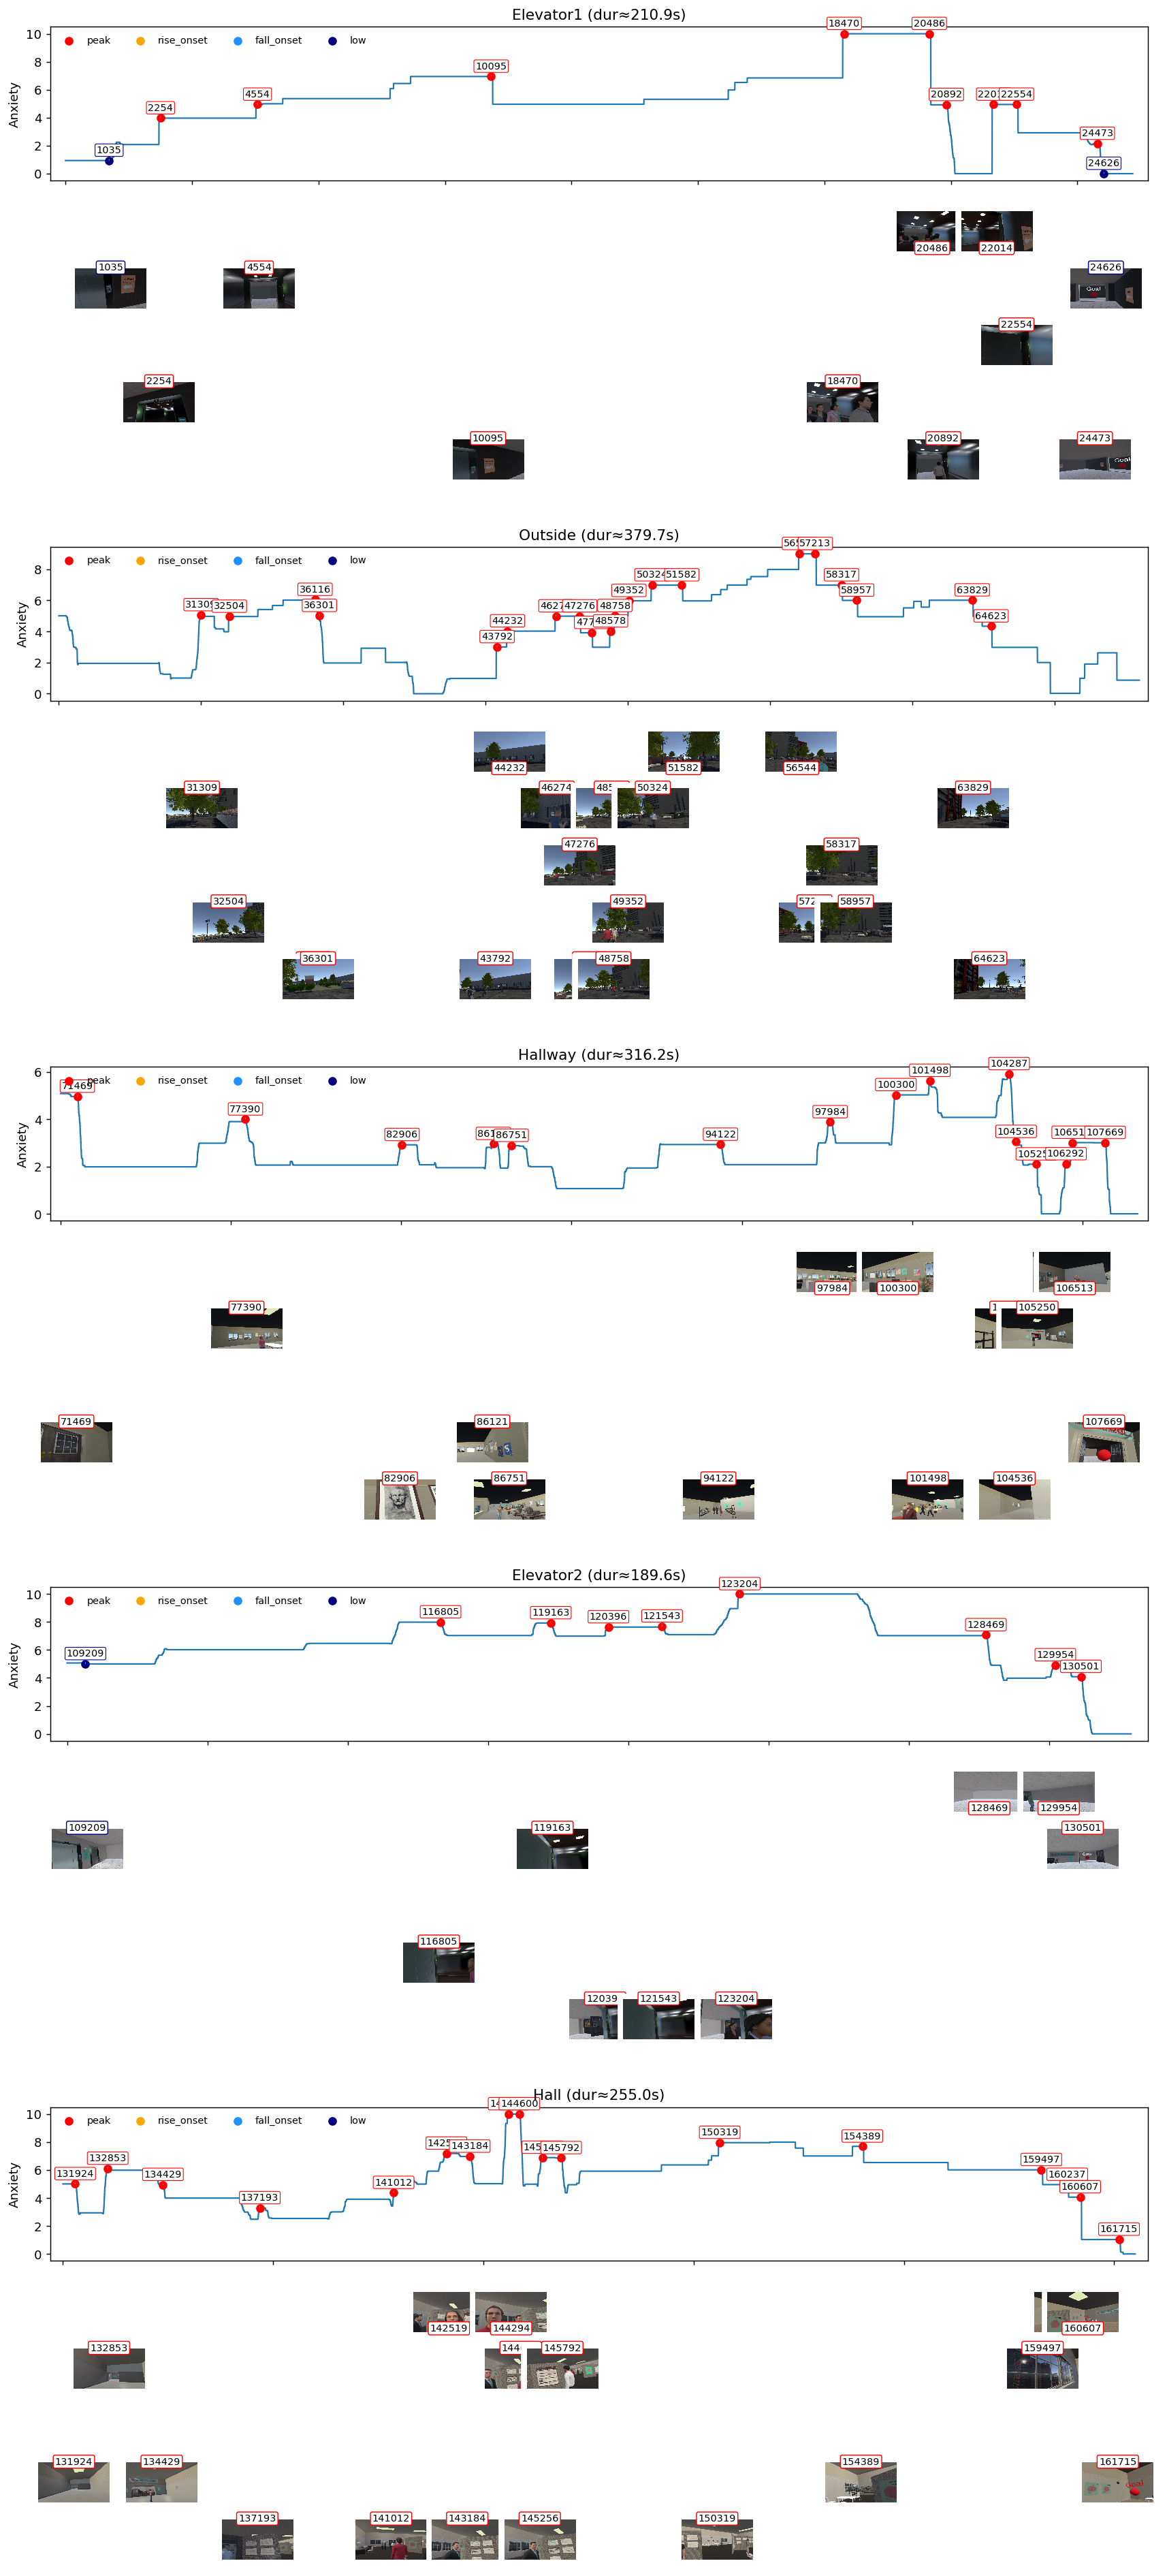


[Mapping] label ↔ (scene,event,gid,t_scene,frame,time)
 label     scene event  gid    t_scene  frame        time
  1035 Elevator1   low  NaN   8.625000   1035    8.625000
  2254 Elevator1  peak  1.0  18.783333   2254   18.783333
  4554 Elevator1  peak  2.0  37.950000   4554   37.950000
 10095 Elevator1  peak  3.0  84.125000  10095   84.125000
 18470 Elevator1  peak  4.0 153.916667  18470  153.916667
 20486 Elevator1  peak  7.0 170.716667  20486  170.716667
 20892 Elevator1  peak  9.0 174.100000  20892  174.100000
 22014 Elevator1  peak 10.0 183.450000  22014  183.450000
 22554 Elevator1  peak 12.0 187.950000  22554  187.950000
 24473 Elevator1  peak 15.0 203.941667  24473  203.941667
 24626 Elevator1   low  NaN 205.216667  24626  205.216667
109209 Elevator2   low  NaN   3.266667 109209  910.075000
116805 Elevator2  peak  1.0  66.566667 116805  973.375000
119163 Elevator2  peak  2.0  86.216667 119163  993.025000
120396 Elevator2  peak  3.0  96.491667 120396 1003.300000
121543 Elevator2

In [8]:
# ========================= NEW PIPELINE (clean) =========================
# Events (peak/rise/fall with gid) + Pair-preserving selection + Non-overlap strip
# =======================================================================

import os, math, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage import median_filter

# -------------------------------
# Video utils
# -------------------------------
class SceneVideo:
    def __init__(self, path: str, pos="msec", offset: float = 0.0):
        self.path = path
        self.pos_mode = pos
        self.offset = float(offset)
        self.cap = cv2.VideoCapture(path)
        if not self.cap.isOpened():
            raise RuntimeError(f"Cannot open video: {path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30.0
        self.nf  = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        self.dur = self.nf / self.fps if self.fps > 0 else None

    def __del__(self):
        try:
            if hasattr(self, "cap") and self.cap is not None:
                self.cap.release()
        except Exception:
            pass

    def _seek(self, t_sec: float) -> bool:
        if self.pos_mode == "msec":
            return self.cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, t_sec) * 1000.0)
        f_idx = int(round(max(0.0, t_sec) * self.fps))
        f_idx = min(max(0, f_idx), max(0, self.nf - 1))
        return self.cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx)

    def read_at(self, t_scene_sec: float, nearest_if_fail=True):
        if t_scene_sec is None or math.isnan(t_scene_sec):
            return False, None
        t_eff = t_scene_sec + self.offset
        if self.dur is not None:
            t_eff = min(max(0.0, t_eff), max(0.0, self.dur - 1e-3))
        self._seek(t_eff)
        ok, frame = self.cap.read()
        if not ok or frame is None:
            if not nearest_if_fail:
                return False, None
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, self.nf - 1))
            ok2, frame2 = self.cap.read()
            return ok2 and frame2 is not None, frame2
        return True, frame

class VideoBank:
    def __init__(self, scene_to_path: dict, offset_by_scene=None):
        self.items = {}
        self.offsets = offset_by_scene or {}
        for sc, p in scene_to_path.items():
            if not os.path.exists(p): continue
            self.items[sc] = SceneVideo(p, pos="msec", offset=float(self.offsets.get(sc, 0.0)))

    def read(self, scene: str, t_scene_sec: float):
        if scene not in self.items:
            return False, None
        return self.items[scene].read_at(t_scene_sec)

# -------------------------------
# Detect
# -------------------------------
def _robust_z(y):
    med = np.median(y)
    mad = np.median(np.abs(y - med)) + 1e-9
    return (y - med) / (1.4826 * mad)

def _smooth(x, fs, med_win_s=0.5, sg_win_s=1.0, sg_poly=2):
    med = int(max(1, round(med_win_s * fs)))
    sg  = int(max(3, round(sg_win_s * fs)) // 2 * 2 + 1)
    return savgol_filter(median_filter(x, med), sg, sg_poly)

def detect_events_v2(
    df: pd.DataFrame, fs: float=120.0,
    *,
    min_dist_s: float = 0.7,
    topk_peak: int = 12, topk_low: int = 6,
    med_win_s: float = 0.4, sg_win_s: float = 0.8, sg_poly: int = 2,
    plateau_min_s: float = 0.18,           # 유지(미세 평탄)
    search_win_s: float = 4.0,
    # ▼ 스펙 파라미터
    flat_win_s: float = 0.60,              # "n초간 flat일 때만" 판단에 쓰는 최소 평탄 길이
    peak_win_s: float = 2.0,               # peak 계산 윈도 길이(±)
    low_win_s:  float = 2.0,               # low 계산 윈도 길이(±)
    flat_slope_quantile: float = 0.15      # 평탄 판단 임계(절대기울기) = rob_dz * q
):

    """Return df_events with columns: scene, event, gid, frame, time, t_scene, anxiety, score_prom, score_grad"""
    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    rows = []
    distance = max(1, int(round(min_dist_s * fs)))
    plateau_size = int(max(1, round(plateau_min_s * fs)))
    win = int(max(1, round(search_win_s * fs)))

    for sc, g in df.groupby("scene", sort=False):
        y   = g["anxiety"].astype(float).to_numpy()
        t   = g["time"].to_numpy()
        ts  = g["t_scene"].to_numpy()
        idx = g.index.to_numpy()

        # smooth on y (not z), then z on smoothed y
        y_s  = _smooth(y, fs, med_win_s, sg_win_s, sg_poly)
        z_s  = _robust_z(y_s)
        dz   = np.gradient(y_s)
        ddz  = np.gradient(dz)
        # --- 평탄 구간(plateau) 탐지: |dz| <= thresh 인 연속 러닝
        flat_thr = max(1e-9, (1.4826*np.median(np.abs(dz - np.median(dz)))) * flat_slope_quantile)
        is_flat = np.abs(dz) <= flat_thr
        min_len = max(1, int(round(flat_win_s * fs)))

        # 연속 구간 인덱스 (start, end, center)
        flat_spans = []
        k = 0
        while k < len(is_flat):
            if is_flat[k]:
                s = k
                while k < len(is_flat) and is_flat[k]:
                    k += 1
                e = k - 1
                if (e - s + 1) >= min_len:
                    c = (s + e) // 2
                    flat_spans.append((s, e, c))
            else:
                k += 1

        def find_flat_span_containing(i):
            # i가 포함된 평탄 구간 반환(없으면 None)
            for (s,e,c) in flat_spans:
                if s <= i <= e:
                    return (s,e,c)
            return None

        # robust scales
        rob_z  = 1.4826*np.median(np.abs(z_s - np.median(z_s))) + 1e-9
        rob_y  = 1.4826*np.median(np.abs(y_s - np.median(y_s))) + 1e-9
        rob_dz = 1.4826*np.median(np.abs(dz - np.median(dz))) + 1e-9

        prom_z_abs = max(0.6*rob_z, 0.5)         # adaptive
        prom_y_abs = max(0.6*rob_y, 0.05*(np.percentile(y_s,95)-np.percentile(y_s,5)))

        # candidates: union of z, y, |dz|
        pk_z, _ = find_peaks(z_s, prominence=prom_z_abs, distance=distance, plateau_size=plateau_size)
        pk_y, _ = find_peaks(y_s, prominence=prom_y_abs, distance=distance, plateau_size=plateau_size)
        pk_g, _ = find_peaks(np.abs(dz), prominence=max(0.8*rob_dz, 0.02), distance=distance)
        pk_idx  = np.unique(np.concatenate([pk_z, pk_y, pk_g]))
        if len(pk_idx) < topk_peak:
            topk_curv = np.argsort(np.abs(ddz))[::-1][:topk_peak]
            pk_idx = np.unique(np.concatenate([pk_idx, topk_curv]))
        pk_idx = np.sort(pk_idx)
        # --- [INSERT] 멀티스케일: 더 짧은 창으로 micro-peak 추가 탐지 ---
        # 작은 변동을 살리기 위해 스무딩 창을 절반/1/3 수준으로 줄인 버전
        y_s_small  = _smooth(y, fs, med_win_s*0.25, sg_win_s*0.50, sg_poly)
        z_s_small  = _robust_z(y_s_small)
        # 전역 임계보다 낮은 로컬 임계
        prom_small = max(0.35*rob_y, 0.02*(np.percentile(y_s_small,95)-np.percentile(y_s_small,5)))
        dist_small = max(1, int(round(0.35 * fs)))   # 0.35s 간격이면 분리

        pk_small, _ = find_peaks(
            y_s_small, prominence=prom_small, distance=dist_small, plateau_size=1
        )
        # 기울기 절댓값이 아주 작지 않은(=순수 평탄 오검출 방지) 곳만 유지
        keep_small = np.where(np.abs(dz[pk_small]) >= 0.1*rob_dz)[0]
        pk_small   = pk_small[keep_small]

        # 통합 후 시간축 비중복화(가까운 봉우리는 값이 더 큰 쪽을 남김)
        cand = np.unique(np.concatenate([pk_idx, pk_small]))
        if len(cand):
            # non-max suppression by local value on y_s_small
            out = [int(cand[0])]
            for j in cand[1:]:
                if (j - out[-1]) <= dist_small:
                    # 더 높은 지점 남기기
                    if y_s_small[j] > y_s_small[out[-1]]:
                        out[-1] = int(j)
                else:
                    out.append(int(j))
            pk_idx = np.array(out, dtype=int)
        # --- [END INSERT] ---

        # lows (z-based) + edges
        lo_idx, _ = find_peaks(-z_s, prominence=max(0.5*prom_z_abs, 0.5*rob_z),
                               distance=distance, plateau_size=plateau_size)
        if len(lo_idx) < topk_low:
            topk_lo = np.argsort(z_s)[:topk_low]
            lo_idx  = np.unique(np.concatenate([lo_idx, topk_lo]))

        # hysteresis thresholds
        rob_dz2 = 1.4826*np.median(np.abs(dz - np.median(dz))) + 1e-9
        gamma   = max(0.2, 0.35*rob_dz2)  # slope threshold

        eid = 1
        gid = 1

        def add(event, i, prom=0.0, grad=0.0, gid_val=None):
            nonlocal eid
            j = int(np.clip(i, 0, len(y)-1))
            rows.append({
                "eid": eid, "scene": str(sc), "event": event, "gid": int(gid_val) if gid_val is not None else np.nan,
                "index": int(idx[j]), "frame": int(idx[j]),
                "time": float(t[j]), "t_scene": float(ts[j]),
                "anxiety": float(y[j]), "score_prom": float(prom), "score_grad": float(grad)
            })
            eid += 1

        # peak-centered set (스펙 준수)
        half_peak = max(1, int(round(min(peak_win_s, 1.2) * fs)))
        for i0 in pk_idx:
            # (a) ±peak_win_s 내 "진짜 피크" 재정의
            Lp = max(0, i0 - half_peak); Rp = min(len(y_s)-1, i0 + half_peak)
            i_peak = Lp + int(np.argmax(y_s[Lp:Rp+1]))

            # (b) i_peak가 평탄 구간에 속하면 중앙으로 스냅
            span = find_flat_span_containing(i_peak)
            rise_i = None; fall_i = None
            if span is not None:
                s,e,c = span
                i_peak = c  # 중앙 시점
                # 스펙: rise는 '직후', fall은 '직전'
                rise_i = min(e, s + 1)       # s 바로 다음(직후)
                fall_i = max(s, e - 1)       # e 바로 이전(직전)

            # prominence(가중합) 재계산
            prom = float(abs(z_s[i_peak])) * 0.5 + float(abs(y_s[i_peak])) * 0.3 + float(abs(dz[i_peak])) * 0.2

            # (c) add (평탄 아닐 때는 onset 생성 안 함)
            if rise_i is not None: add("rise_onset", rise_i, gid_val=gid)
            add("peak", i_peak, prom=prom, gid_val=gid)
            if fall_i is not None: add("fall_onset", fall_i, grad=float(abs(dz[fall_i])), gid_val=gid)
            gid += 1


        # lows (스펙: ±low_win_s 내 최저값, 평탄이면 중앙)
        half_low = max(1, int(round(min(low_win_s, 1.2) * fs)))
        used_fall = set()   # fall_onset 프레임 회피용
        # 현재 scene에서 방금 추가된 fall_onset index를 수집
        # rows에는 동일 scene의 직전 추가 내용이 들어있으므로 gather
        for r in rows[::-1]:
            if r["scene"] != str(sc): break
            if r["event"] == "fall_onset":
                used_fall.add(r["index"])

        for i0 in np.sort(lo_idx):
            Ll = max(0, i0 - half_low); Rl = min(len(y_s)-1, i0 + half_low)
            i_low = Ll + int(np.argmin(y_s[Ll:Rl+1]))

            span = find_flat_span_containing(i_low)
            if span is not None:
                s,e,c = span
                i_low = c  # 평탄 중앙

            # fall_onset과 충돌 시, 평탄이면 반대쪽으로 한 칸, 아니면 한 칸 이동
            if i_low in used_fall:
                if span is not None:
                    s,e,c = span
                    i_low = s if abs(s - i_low) >= abs(e - i_low) else e
                    i_low = np.clip(i_low, 0, len(y_s)-1)
                else:
                    i_low = int(np.clip(i_low+1, 0, len(y_s)-1))

            add("low", i_low)

        # edge lows (start/end 15s 유지)
        edge_w = int(round(min(15.0, (t[-1]-t[0])) * fs))
        if edge_w > 5:
            add("low", int(np.argmin(z_s[:edge_w])))
            add("low", int(np.argmin(z_s[-edge_w:])) + (len(z_s)-edge_w))


    ev = pd.DataFrame(rows).sort_values(["scene","time","event"]).reset_index(drop=True)
    return ev

# -------------------------------
# Select (pair-preserving)
# -------------------------------
def select_events_v2(
    df_events: pd.DataFrame, fs: float,
    *,
    keep_types=("peak","rise_onset","fall_onset","low"),
    min_gap_s: float = 1.5,
    bin_secs: float  = 8.0,
    max_per_scene: int = 20,
    max_total: int = 120
):
    if df_events.empty: return df_events
    df = df_events[df_events["event"].isin(keep_types)].copy()
    if df.empty: return df

    prom = df.get("score_prom", 0.0)
    grad = df.get("score_grad", 0.0)
    # favour onsets so they survive filtering
    df["score"] = (
        1.0*prom + 0.5*grad + df["event"].map({"rise_onset":0.20,"fall_onset":0.14,"peak":0.10,"low":0.06}).fillna(0.0)
    )

    # (1) bin-balanced first picks
    df["bin"] = (df["time"] // bin_secs).astype(int)
    picked = []
    for (sc,b), g in df.sort_values(["scene","time","score"], ascending=[True,True,False]).groupby(["scene","bin"]):
        picked.append(g["score"].idxmax())
    df_pick = df.loc[picked].copy()

    # (2) pair preserve: if any of rise/peak/fall in gid picked, include the rest (when available)
    if "gid" in df.columns:
        extra = []
        gids = set(df_pick.get("gid", pd.Series([], dtype=float)).dropna().astype(int).tolist())
        for g in gids:
            sub = df[(df["gid"]==g) & df["event"].isin(["rise_onset","peak","fall_onset"])]
            for i in sub.index:
                if i not in df_pick.index:
                    extra.append(i)
        if extra:
            df_pick = pd.concat([df_pick, df.loc[extra]], axis=0)

    # (3) min gap with exception for same gid
    keep=[]
    for sc, g in df_pick.sort_values(["scene","time","score"], ascending=[True,True,False]).groupby("scene"):
        last_t = -1e9; last_gid = None
        for i,r in g.iterrows():
            gid = r.get("gid", None)
            if (r["time"] - last_t) >= min_gap_s or (pd.notna(gid) and gid==last_gid):
                keep.append(i); last_t = r["time"]; last_gid = gid
    df_pick = df_pick.loc[keep].sort_values(["scene","time"])

    # (4) per-scene cap + total cap
    outs=[]
    for sc,g in df_pick.groupby("scene"):
        outs.append(g.sort_values("score", ascending=False).head(max_per_scene))
    out = pd.concat(outs).sort_values(["scene","time"])
    if len(out) > max_total:
        out = out.sort_values("score", ascending=False).head(max_total).sort_values(["scene","time"])
    return out.drop(columns=["bin"], errors="ignore").reset_index(drop=True)

# -------------------------------
# Plot (no-overlap lanes, peak aligned to onset)
# -------------------------------
def _lane_positions_from_zoom(ax_strip, img_h_px, zoom, n_lanes,
                              min_gap_px=30, top_pad=None, bot_pad=None,
                              label_pad_px=14):
    """
    이미지 실제 높이(img_h_px*zoom)에 라벨 여유(label_pad_px)를 더해
    lane 간 간격을 픽셀 기준으로 강제. lanes가 적으면 하단 패딩 자동 축소.
    """
    fig = ax_strip.figure
    bbox = ax_strip.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_h_px = max(1.0, bbox.height * fig.dpi)

    # 패딩을 lanes 수에 따라 동적으로
    if top_pad is None or bot_pad is None:
        top_pad = 0.06
        bot_pad = 0.06 if n_lanes >= 6 else (0.03 if n_lanes >= 4 else 0.02)

    eff_img_px = img_h_px * zoom + label_pad_px              # ← 라벨 공간 포함
    need_px = eff_img_px + min_gap_px
    total_px = n_lanes * eff_img_px + (n_lanes - 1) * min_gap_px
    avail_px = ax_h_px * (1.0 - top_pad - bot_pad)

    if total_px > avail_px:
        zoom = max(0.02, (avail_px - (n_lanes - 1) * min_gap_px - n_lanes*label_pad_px) / (n_lanes * img_h_px))

    # lanes가 적을수록 더 낮은 상한을 적용해 과대 확대 방지
    zoom_cap = 0.07 if n_lanes >= 6 else (0.065 if n_lanes >= 4 else 0.06)
    zoom = float(np.clip(zoom, 0.02, zoom_cap))

    ys = []
    start_px = (ax_h_px * bot_pad)
    for k in range(n_lanes):
        center_px = start_px + eff_img_px/2.0 + k * (eff_img_px + min_gap_px)
        ys.append(center_px / ax_h_px)
    return np.array(ys), zoom


def plot_events_v2(
    df, df_events_sel, bank,
    scenes_order=None,
    *,
    df_events_full=None,               # for aligning peak to onset
    thumb_width_secs=6.0,
    n_lanes=6,
    strip_height_ratio=3.2,
    line_height_ratio=2.0,
    max_per_scene=20,
    figsize_per_scene=(16, 7.6),
    dpi=130,
    numbering_mode="frame",            # {"frame","time_s","eid"}
    align_peak_to_onset=True,
    save_path=None
):
    df = df.copy()
    if "t_scene" not in df.columns:
        t0 = df.groupby("scene")["time"].min().to_dict()
        df["t_scene"] = df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

    if scenes_order is None:
        scenes_order = [s for s in df["scene"].astype(str).unique()]

    n = len(scenes_order)
    W,Hs = figsize_per_scene; H = Hs * n
    fig = plt.figure(figsize=(W, H), dpi=dpi)
    gs = fig.add_gridspec(
        nrows=2*n, ncols=1,
        height_ratios=sum(([line_height_ratio, strip_height_ratio] for _ in range(n)), []),
        hspace=0.30
    )
    fig.canvas.draw()

    mapping=[]
    for idx, sc in enumerate(scenes_order):
        g = df[df["scene"].astype(str)==str(sc)].copy()
        if g.empty: continue

        t = g["t_scene"].to_numpy(); y = g["anxiety"].to_numpy()
        t0, t1 = float(t.min()), float(t.max()); pad = thumb_width_secs/2.0

        ev_sc = df_events_sel[df_events_sel["scene"].astype(str)==str(sc)].copy()
        key = "score" if "score" in ev_sc.columns else "anxiety"
        ev_sc = ev_sc.sort_values([key,"t_scene"], ascending=[False,True]).head(max_per_scene).sort_values("t_scene")

        # align peak marker to rise_onset time using full events (not only selected)
        if align_peak_to_onset and df_events_full is not None:
            src = df_events_full[df_events_full["scene"].astype(str)==str(sc)]
            if "gid" in src.columns:
                onset_map_t = (src[src["event"]=="rise_onset"].drop_duplicates("gid")
                               .set_index("gid")["t_scene"].to_dict())
                onset_map_f = (src[src["event"]=="rise_onset"].drop_duplicates("gid")
                               .set_index("gid")["frame"].to_dict())
                m_peak = ev_sc["event"].eq("peak") & ev_sc["gid"].isin(onset_map_t.keys())
                ev_sc.loc[m_peak, "t_scene"] = ev_sc.loc[m_peak, "gid"].map(onset_map_t)
                ev_sc.loc[m_peak, "frame"]   = ev_sc.loc[m_peak, "gid"].map(onset_map_f)
                ev_sc = ev_sc.sort_values("t_scene")

        # axes
        ax_line  = fig.add_subplot(gs[2*idx,0])
        ax_strip = fig.add_subplot(gs[2*idx+1,0])
        trans_xy = mtransforms.blended_transform_factory(ax_strip.transData, ax_strip.transAxes)

        # line
        ax_line.plot(t, y, lw=1.2)
        ax_line.set_xlim(t0-pad, t1+pad)
        ax_line.set_ylabel("Anxiety"); ax_line.set_title(f"{sc} (dur≈{t1-t0:.1f}s)")
        ax_line.set_xticklabels([])

        if not ev_sc.empty:
            # ❶ 이벤트 시각의 y값을 곡선에서 재샘플(보간) → 떠있는 점 제거
            y_at = np.interp(ev_sc["t_scene"].to_numpy(), t, y)
            ev_sc["y_plot"] = y_at
            

            c_map = {"peak":"red","rise_onset":"orange","fall_onset":"dodgerblue","low":"navy"}
            for evn, col in c_map.items():
                m = ev_sc["event"].eq(evn)
                ax_line.scatter(ev_sc.loc[m,"t_scene"], ev_sc.loc[m,"y_plot"], s=36, c=col, zorder=3, label=evn)
            
            ax_line.legend(loc="upper left", fontsize=8, frameon=False, ncol=4)  # ← ✅ 색 라벨 복구


        # strip
        ax_strip.set_xlim(t0-pad, t1+pad); ax_strip.set_ylim(0,1); ax_strip.axis("off")
        fig.canvas.draw()

        # zoom & lane positions (pixel-based)
        sample_h = 240
        try:
            _tmp=None
            if len(ev_sc):
                ok,bgr = bank.read(ev_sc.iloc[0].scene, ev_sc.iloc[0].t_scene)
                if ok and bgr is not None: _tmp=bgr
            if _tmp is not None: sample_h=_tmp.shape[0]
        except Exception: pass

        # initial rough zoom then adjust by lane spacing
        def _rough_zoom(ax_strip, img_h_px, n_lanes):
            bbox = ax_strip.get_window_extent().transformed(ax_strip.figure.dpi_scale_trans.inverted())
            ax_h_px = max(1.0, bbox.height * ax_strip.figure.dpi)
            band_px = ax_h_px / max(1, n_lanes)
            return np.clip((band_px * 0.70) / max(1, img_h_px), 0.02, 0.08)

        z0 = _rough_zoom(ax_strip, sample_h, n_lanes) * 0.9
        lane_y, zoom = _lane_positions_from_zoom(
            ax_strip, sample_h, z0, n_lanes,
            min_gap_px=28 if n_lanes >= 6 else 24,   # lanes 적으면 간격 조금 줄여 하단 갭 축소
            top_pad=None, bot_pad=None,              # 동적 패딩 사용
            label_pad_px=14
        )

        # place thumbnails
        if not ev_sc.empty:
            ts_all = ev_sc["t_scene"].to_numpy()
            for row in ev_sc.itertuples(index=False):
                x = float(row.t_scene)
                img = getattr(row, "thumb", None)
                if img is None:
                    ok,bgr = bank.read(row.scene, row.t_scene)
                    if not ok or bgr is None: continue
                    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

                # lane index by nearest y
                yf = lane_y[(hash((row.gid, row.event)) % len(lane_y))]
                # density-based x shift (spread horizontally when crowded)
                density = np.sum(np.abs(ts_all - x) < (thumb_width_secs*0.40))
                lane_i = int(np.argmin(np.abs(lane_y - yf)))
                x_shift = (lane_i - (n_lanes-1)/2.0) * (thumb_width_secs*0.05) + (density-1)*0.12
                x_draw = x + x_shift

                ax_strip.add_artist(AnnotationBbox(
                    OffsetImage(img, zoom=zoom),
                    (x_draw, yf), xycoords=trans_xy,
                    box_alignment=(0.5,0.5), frameon=True,
                    bboxprops=dict(edgecolor="white", linewidth=0.9)
                ))

                # label
                if numbering_mode=="frame": label = f"{int(row.frame)}"
                elif numbering_mode=="time_s": label = f"{row.t_scene:.0f}s"
                else: label = f"{int(row.eid)}"

                edge = {"peak":"red","rise_onset":"orange","fall_onset":"dodgerblue","low":"navy"}.get(row.event,"black")
                ax_strip.text(x_draw, min(0.97, yf+0.085), label, transform=trans_xy,
                              ha="center", va="center", fontsize=8,
                              bbox=dict(facecolor="white", edgecolor=edge, linewidth=0.8, boxstyle="round,pad=0.18"))
                y_row = float(np.interp(row.t_scene, t, y))
                ax_line.annotate(label, xy=(row.t_scene,y_row),
                                 xytext=(row.t_scene, y_row + 0.04*(np.nanmax(y)-np.nanmin(y)+1e-6)),
                                 textcoords="data", ha="center", va="bottom", fontsize=8,
                                 bbox=dict(facecolor="white", edgecolor=edge, linewidth=0.6, boxstyle="round,pad=0.15"),
                                 arrowprops=dict(arrowstyle="-", lw=0.6, color="gray"))

                mapping.append({"label":label,"scene":row.scene,"event":row.event,"gid":getattr(row,"gid",np.nan),
                                "t_scene":float(row.t_scene),"frame":int(row.frame),"time":float(row.time)})

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight", facecolor="white")
        print(f"[SAVE] {save_path}")
    plt.show()

    if mapping:
        md = pd.DataFrame(mapping).sort_values(["scene","t_scene","event"])
        print("\n[Mapping] label ↔ (scene,event,gid,t_scene,frame,time)")
        print(md.to_string(index=False))

# ========================= RUN (edit your paths below) =========================
if __name__ == "__main__":
    FS = 120.0
    FILE_PATH = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized\001_Main.pkl"
    VIDEO_PATHS = {
        "Elevator1": "./VideoTest/001_Elevator1.mp4",
        "Outside":   "./VideoTest/001_Outside.mp4",
        "Hallway":   "./VideoTest/001_Hallway.mp4",
        "Elevator2": "./VideoTest/001_Elevator2.mp4",
        "Hall":      "./VideoTest/001_Hall.mp4",
    }
    OFFSET_BY_SCENE = {}

    df = pd.read_pickle(FILE_PATH).copy()
    if "time" not in df.columns:
        df["time"] = df.index / FS

    df_events_full = detect_events_v2(df, fs=FS)
    df_sel = select_events_v2(
        df_events_full, fs=FS,
        keep_types=("peak","rise_onset","fall_onset","low"),
        min_gap_s=1.2, bin_secs=6.0,
        max_per_scene=24, max_total=120
    )

    bank = VideoBank(VIDEO_PATHS, offset_by_scene=OFFSET_BY_SCENE)

    plot_events_v2(
        df, df_sel, bank,
        scenes_order=["Elevator1","Outside","Hallway","Elevator2","Hall"],
        thumb_width_secs=6.0,
        n_lanes=5,
        strip_height_ratio=3.2,
        line_height_ratio=2.0,
        max_per_scene=20,
        figsize_per_scene=(16, 7.6),
        dpi=130,
        numbering_mode="frame",
        align_peak_to_onset=True,
        df_events_full=df_events_full,
        save_path="per_scene_anxiety_thumbs.png"
    )
# =======================================================================


In [2]:
!pip install ipympl

     ------------------------------------- 511.6/511.6 kB 31.3 MB/s eta 0:00:00


In [ ]:
%matplotlib widget
# ========= interactive_ts_video.py =========
import os, math, cv2
import numpy as np
import pandas as pd
import matplotlib
# 주피터가 아니면 기본 TkAgg, 주피터면 "%matplotlib widget" 추천
if matplotlib.get_backend().lower() == "agg":
    matplotlib.use("TkAgg")
import matplotlib.pyplot as plt

# ---------------- Video ----------------
class SceneVideo:
    def __init__(self, path: str, pos="msec", offset: float = 0.0):
        self.path = path
        self.pos_mode = pos
        self.offset = float(offset)
        self.cap = cv2.VideoCapture(path)
        if not self.cap.isOpened():
            raise RuntimeError(f"Cannot open video: {path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30.0
        self.nf  = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        self.dur = self.nf / self.fps if self.fps > 0 else None

    def __del__(self):
        try:
            if hasattr(self, "cap") and self.cap is not None:
                self.cap.release()
        except Exception:
            pass

    def _seek(self, t_sec: float) -> bool:
        if self.pos_mode == "msec":
            return self.cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, t_sec) * 1000.0)
        f_idx = int(round(max(0.0, t_sec) * self.fps))
        f_idx = min(max(0, f_idx), max(0, self.nf - 1))
        return self.cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx)

    def read_at(self, t_scene_sec: float, nearest_if_fail=True):
        if t_scene_sec is None or math.isnan(t_scene_sec):
            return False, None
        t_eff = t_scene_sec + self.offset
        if self.dur is not None:
            t_eff = min(max(0.0, t_eff), max(0.0, self.dur - 1e-3))
        self._seek(t_eff)
        ok, frame = self.cap.read()
        if not ok or frame is None:
            if not nearest_if_fail:
                return False, None
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, self.nf - 1))
            ok2, frame2 = self.cap.read()
            return ok2 and frame2 is not None, frame2
        return True, frame

class VideoBank:
    def __init__(self, scene_to_path: dict, offset_by_scene=None):
        self.items = {}
        self.offsets = offset_by_scene or {}
        for sc, p in scene_to_path.items():
            if os.path.exists(p):
                self.items[str(sc)] = SceneVideo(p, pos="msec", offset=float(self.offsets.get(sc, 0.0)))

    def read(self, scene: str, t_scene_sec: float):
        if str(scene) not in self.items:
            return False, None
        return self.items[str(scene)].read_at(t_scene_sec)

# ------------- Interactive Viewer -------------
class InteractiveTSViewer:
    def __init__(self, df, bank: VideoBank, scenes_order=None, fs=120.0):
        self.df = df.copy()
        self.bank = bank
        self.fs = fs

        if "time" not in self.df.columns:
            self.df["time"] = self.df.index / fs
        if "t_scene" not in self.df.columns:
            t0 = self.df.groupby("scene")["time"].min().to_dict()
            self.df["t_scene"] = self.df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

        self.scenes = scenes_order or [str(s) for s in self.df["scene"].astype(str).unique()]
        self.si = 0  # scene index

        self.fig = plt.figure(figsize=(14, 5.0), layout="constrained")
        gs = self.fig.add_gridspec(1, 2, width_ratios=[1.0, 1.30])  # ← 우측 30% 더 넓게
        self.ax_ts  = self.fig.add_subplot(gs[0, 0])
        self.ax_img = self.fig.add_subplot(gs[0, 1])
        self.vline = None
        self.img_artist = None
        self.note = None

        self.cid_click = self.fig.canvas.mpl_connect("button_press_event", self.on_click)
        self.cid_key   = self.fig.canvas.mpl_connect("key_press_event", self.on_key)

        self.draw_scene()

    # ---- scene drawing ----
    def draw_scene(self):
        sc = self.scenes[self.si]
        g = self.df[self.df["scene"].astype(str)==str(sc)]
        self.t = g["t_scene"].to_numpy()
        self.y = g["anxiety"].to_numpy()

        self.ax_ts.clear(); self.ax_img.clear()
        self.ax_ts.plot(self.t, self.y, lw=1.4)
        self.ax_ts.set_title(f"{sc} (dur ≈ {self.t.max()-self.t.min():.1f}s) — click anywhere to preview")
        self.ax_ts.set_xlabel("t_scene (s)"); self.ax_ts.set_ylabel("Anxiety")
        self.ax_img.set_axis_off()
        self.vline = None
        self.img_artist = None
        self.note = None
        self.fig.canvas.draw_idle()
        self.ax_ts.margins(x=0.02, y=0.05)

    # ---- click handler ----
    def on_click(self, event):
        if event.inaxes != self.ax_ts: 
            return
        x = float(event.xdata)
        # 화면 범위 클립
        x = float(np.clip(x, self.t.min(), self.t.max()))
        # 수직선 업데이트
        if self.vline is None:
            self.vline = self.ax_ts.axvline(x, color="tab:red", lw=1.2, ls="--")
        else:
            self.vline.set_xdata([x, x])

        # 프레임 읽기
        sc = self.scenes[self.si]
        ok, bgr = self.bank.read(sc, x)
        self.ax_img.clear(); self.ax_img.set_axis_off()
        if ok and bgr is not None:
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            self.img_artist = self.ax_img.imshow(rgb)
            self.ax_img.set_title(f"{sc} @ {x:.2f}s")
            # 영상 종횡비 고정: 그래프 쪽 레이아웃 변화가 와도 이미지가 눌리거나 침범되지 않게
            h, w = rgb.shape[:2]
            try:
                # Matplotlib 3.3+: 축 박스 종횡비를 이미지 비율로 고정
                self.ax_img.set_box_aspect(h / float(w))
            except Exception:
                pass
        else:
            self.ax_img.text(0.5, 0.5, "No frame", ha="center", va="center", fontsize=12)

        # 간단한 텍스트 안내(상단)
        yx = float(np.interp(x, self.t, self.y))
        if self.note is not None:
            self.note.remove()
        self.note = self.ax_ts.annotate(f"{x:.2f}s, y={yx:.2f}", xy=(x, yx), xytext=(x, yx+0.05*(self.y.max()-self.y.min()+1e-6)),
                                        ha="center", va="bottom", fontsize=9,
                                        bbox=dict(facecolor="white", edgecolor="gray", linewidth=0.6, boxstyle="round,pad=0.15"))
        self.fig.canvas.draw_idle()

    # ---- keyboard scene switch ----
    def on_key(self, event):
        if event.key in ("right", "d"):
            self.si = (self.si + 1) % len(self.scenes); self.draw_scene()
        elif event.key in ("left", "a"):
            self.si = (self.si - 1) % len(self.scenes); self.draw_scene()

    def show(self):
        plt.show()

# ---------------- Run ----------------
if __name__ == "__main__":
    FS = 120.0
    FILE_PATH = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized\001_Main.pkl"
    VIDEO_PATHS = {
        "Elevator1": "./VideoTest/001_Elevator1.mp4",
        "Outside":   "./VideoTest/001_Outside.mp4",
        "Hallway":   "./VideoTest/001_Hallway.mp4",
        "Elevator2": "./VideoTest/001_Elevator2.mp4",
        "Hall":      "./VideoTest/001_Hall.mp4",
    }
    OFFSET_BY_SCENE = {}  # 필요하면 초 단위 오프셋

    df = pd.read_pickle(FILE_PATH)
    bank = VideoBank(VIDEO_PATHS, offset_by_scene=OFFSET_BY_SCENE)

    viewer = InteractiveTSViewer(df, bank, scenes_order=["Elevator1","Outside","Hallway","Elevator2","Hall"], fs=FS)
    viewer.show()
# =====================================


ValueError: [mapping.csv] 익명ID/원래ID 컬럼 자동인식 실패. columns=['Original_ID', 'Anonymized_ID']

[INFO] 003 ↔ raw_id=jsj0109
[INFO] VIDEO_PATHS: {'Elevator1': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\03_Elevator1.mp4', 'Outside': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\04_Outside.mp4', 'Hallway': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\05_Hallway.mp4', 'Elevator2': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\06_Elevator2.mp4', 'Hall': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\07_Hall.mp4'}
[INFO] VIDEO_PATHS: {'Elevator1': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\03_Elevator1.mp4', 'Outside': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\04_Outside.mp4', 'Hallway': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\05_Hallway.mp4', 'Elevator2': 'D:\\OneDrive\\HubRoom\\Projects\\SD physiology\\Data\\Main\\raw\\jsj0109\\06_Elevator2

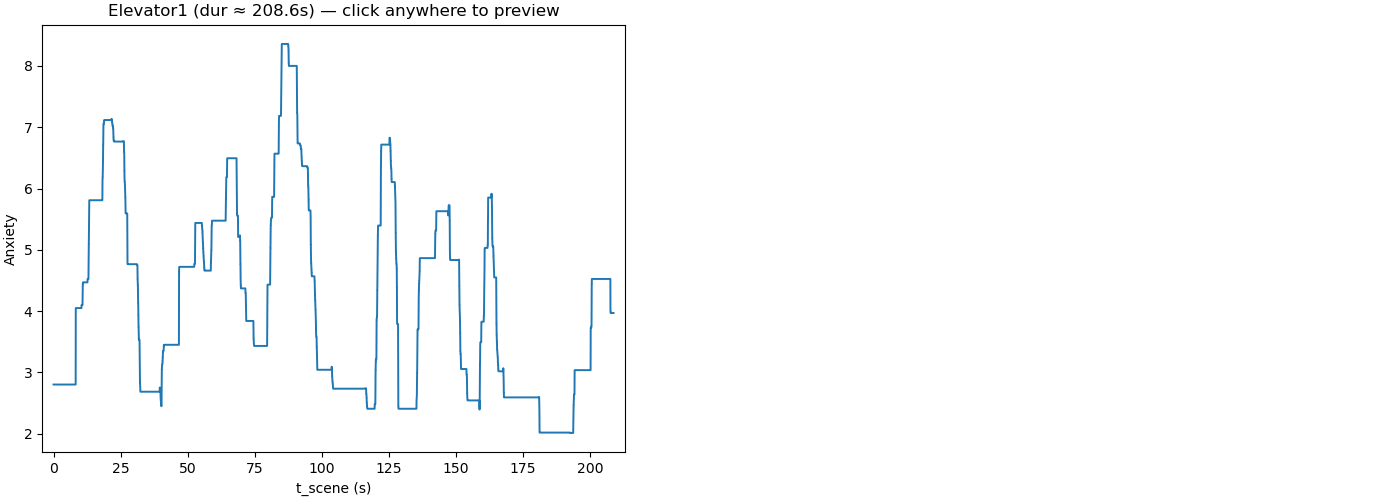

In [ ]:
# %% [markdown]
# %matplotlib widget
# ========= interactive_ts_video.py (ID만 바꿔 바로 원본 폴더에서 읽기) =========
import os, math, glob, cv2
import numpy as np
import pandas as pd
import matplotlib
# 주피터가 아니면 기본 TkAgg, 주피터면 "%matplotlib widget" 추천
if matplotlib.get_backend().lower() == "agg":
    matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from pathlib import Path

def build_video_paths(raw_root: str, raw_id: str, verbose: bool = True) -> dict:
    """
    raw_root/raw_id 폴더에서 장면별 비디오 파일 경로를 자동 탐색해 dict로 반환.
    - 파일명은 '03_Elevator1.*' 같은 접두어 규칙을 따르는 것으로 가정.
    - 같은 접두어로 여러 파일이 있으면 **가장 큰 파일**을 선택.
    """
    base = os.path.join(raw_root, raw_id)
    if not os.path.isdir(base):
        raise FileNotFoundError(f"[raw] 원본 폴더가 없어요: {base}")

    scene_to_path = {}
    for stem, scene in SCENE_STEMS.items():
        # 정확히 'stem + 확장자' 또는 'stem + (중간문자) + 확장자' 모두 허용
        hits = []
        for ext in VIDEO_EXTS:
            # 정확히 일치
            hits += glob.glob(os.path.join(base, stem + ext))
            # 중간에 인코딩/내보내기 접미어가 붙은 경우(e.g., 03_Elevator1_v2.mp4)
            hits += glob.glob(os.path.join(base, stem + "*" + ext))

        if hits:
            hits.sort(key=lambda p: os.path.getsize(p), reverse=True)
            scene_to_path[scene] = hits[0]
        else:
            if verbose:
                print(f"[WARN] 비디오 없음: {stem} (dir={base})")

    if verbose:
        print("[INFO] VIDEO_PATHS:", scene_to_path)
    return scene_to_path

# ---------------- 매핑 유틸 ----------------
def detect_columns(df, anon_pref=None, raw_pref=None):
    # 1) 사용자가 지정한 컬럼명이 우선
    if anon_pref and raw_pref and (anon_pref in df.columns) and (raw_pref in df.columns):
        return anon_pref, raw_pref

    # 2) 자동 감지(확장)
    lower_map = {c.lower(): c for c in df.columns}

    # 익명 ID 후보 키워드 (확장: anonymized_id 포함)
    anon_keys_exact = ["id", "anon_id", "anonymous_id", "anonymized_id", "anon", "pid"]
    # 원래 ID 후보 키워드 (확장: original_id 포함)
    raw_keys_exact  = ["raw_id", "orig_id", "original_id"]
    raw_keys_contains = ["raw", "bhk", "folder", "original", "orig", "participant", "name"]

    # exact 매칭 우선
    anon_col = None
    for k in anon_keys_exact:
        if k in lower_map:
            anon_col = lower_map[k]; break
    if anon_col is None:
        # contains로 보조 탐색
        for c in df.columns:
            cl = c.lower()
            if any(k in cl for k in ["anon", "anonym", "pid", "id"]):
                anon_col = c; break

    raw_col = None
    for k in raw_keys_exact:
        if k in lower_map:
            raw_col = lower_map[k]; break
    if raw_col is None:
        for c in df.columns:
            cl = c.lower()
            if any(k in cl for k in raw_keys_contains):
                raw_col = c; break

    if not anon_col or not raw_col:
        raise ValueError(f"[mapping.csv] 익명ID/원래ID 컬럼 자동인식 실패. columns={list(df.columns)}")

    return anon_col, raw_col

def anon_to_raw_id(mapping_csv, anon_id: str):
    # robust load
    try:
        df = pd.read_csv(mapping_csv)
    except Exception:
        df = pd.read_csv(mapping_csv, encoding="utf-8-sig")

    # ← 여기서 사용자가 지정한 컬럼명 우선 적용
    anon_col, raw_col = detect_columns(df, anon_pref=ANON_COL, raw_pref=RAW_COL)

    # "001" / "01" / "1" 모두 대응
    target3 = str(anon_id).zfill(3)
    series_3 = df[anon_col].astype(str).str.zfill(3)
    cands = df[series_3.eq(target3)]
    if cands.empty:
        key = anon_id if not str(anon_id).isdigit() else str(int(anon_id))  # "001"→"1"
        cands = df[df[anon_col].astype(str) == key]

    if cands.empty:
        raise KeyError(f"[mapping.csv] {anon_id=}에 해당하는 행을 찾지 못했습니다. (사용 컬럼: {anon_col}, {raw_col})")

    raw_id = str(cands.iloc[0][raw_col]).strip()
    return raw_id

# ---------------- Video ----------------
class SceneVideo:
    def __init__(self, path: str, pos="msec", offset: float = 0.0):
        self.path = path
        self.pos_mode = pos
        self.offset = float(offset)
        self.cap = cv2.VideoCapture(path)
        if not self.cap.isOpened():
            raise RuntimeError(f"Cannot open video: {path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30.0
        self.nf  = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        self.dur = self.nf / self.fps if self.fps > 0 else None

    def __del__(self):
        try:
            if hasattr(self, "cap") and self.cap is not None:
                self.cap.release()
        except Exception:
            pass

    def _seek(self, t_sec: float) -> bool:
        if self.pos_mode == "msec":
            return self.cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, t_sec) * 1000.0)
        f_idx = int(round(max(0.0, t_sec) * self.fps))
        f_idx = min(max(0, f_idx), max(0, self.nf - 1))
        return self.cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx)

    def read_at(self, t_scene_sec: float, nearest_if_fail=True):
        if t_scene_sec is None or math.isnan(t_scene_sec):
            return False, None
        t_eff = t_scene_sec + self.offset
        if self.dur is not None:
            t_eff = min(max(0.0, t_eff), max(0.0, self.dur - 1e-3))
        self._seek(t_eff)
        ok, frame = self.cap.read()
        if not ok or frame is None:
            if not nearest_if_fail:
                return False, None
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, self.nf - 1))
            ok2, frame2 = self.cap.read()
            return ok2 and frame2 is not None, frame2
        return True, frame

class VideoBank:
    def __init__(self, scene_to_path: dict, offset_by_scene=None):
        self.items = {}
        self.offsets = offset_by_scene or {}
        for sc, p in scene_to_path.items():
            if os.path.exists(p):
                self.items[str(sc)] = SceneVideo(p, pos="msec", offset=float(self.offsets.get(sc, 0.0)))

    def read(self, scene: str, t_scene_sec: float):
        if str(scene) not in self.items:
            return False, None
        return self.items[str(scene)].read_at(t_scene_sec)

# ------------- Interactive Viewer -------------
class InteractiveTSViewer:
    def __init__(self, df, bank: VideoBank, scenes_order=None, fs=120.0):
        self.df = df.copy()
        self.bank = bank
        self.fs = fs

        if "time" not in self.df.columns:
            self.df["time"] = self.df.index / fs
        if "t_scene" not in self.df.columns:
            t0 = self.df.groupby("scene")["time"].min().to_dict()
            self.df["t_scene"] = self.df.apply(lambda r: r["time"] - t0.get(str(r["scene"]), 0.0), axis=1)

        scenes_present = [s for s in (scenes_order or self.df["scene"].astype(str).unique().tolist())
                          if str(s) in self.df["scene"].astype(str).unique()]
        self.scenes = scenes_present
        self.si = 0  # scene index

        self.fig = plt.figure(figsize=(14, 5.0), layout="constrained")
        gs = self.fig.add_gridspec(1, 2, width_ratios=[1.0, 1.30])  # ← 우측 30% 더 넓게
        self.ax_ts  = self.fig.add_subplot(gs[0, 0])
        self.ax_img = self.fig.add_subplot(gs[0, 1])
        self.vline = None
        self.img_artist = None
        self.note = None

        self.cid_click = self.fig.canvas.mpl_connect("button_press_event", self.on_click)
        self.cid_key   = self.fig.canvas.mpl_connect("key_press_event", self.on_key)

        self.draw_scene()

    def draw_scene(self):
        sc = self.scenes[self.si]
        g = self.df[self.df["scene"].astype(str)==str(sc)]
        self.t = g["t_scene"].to_numpy()
        self.y = g["anxiety"].to_numpy()

        self.ax_ts.clear(); self.ax_img.clear()
        self.ax_ts.plot(self.t, self.y, lw=1.4)
        dur = float(self.t.max()-self.t.min()) if len(self.t) else 0.0
        self.ax_ts.set_title(f"{sc} (dur ≈ {dur:.1f}s) — click anywhere to preview")
        self.ax_ts.set_xlabel("t_scene (s)"); self.ax_ts.set_ylabel("Anxiety")
        self.ax_img.set_axis_off()
        self.vline = None
        self.img_artist = None
        self.note = None
        self.ax_ts.margins(x=0.02, y=0.05)
        self.fig.canvas.draw_idle()

    def on_click(self, event):
        if event.inaxes != self.ax_ts or not len(self.t):
            return
        x = float(np.clip(float(event.xdata), self.t.min(), self.t.max()))
        if self.vline is None:
            self.vline = self.ax_ts.axvline(x, color="tab:red", lw=1.2, ls="--")
        else:
            self.vline.set_xdata([x, x])

        sc = self.scenes[self.si]
        ok, bgr = self.bank.read(sc, x)
        self.ax_img.clear(); self.ax_img.set_axis_off()
        if ok and bgr is not None:
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            self.img_artist = self.ax_img.imshow(rgb)
            self.ax_img.set_title(f"{sc} @ {x:.2f}s")
            h, w = rgb.shape[:2]
            try:
                self.ax_img.set_box_aspect(h / float(w))
            except Exception:
                pass
        else:
            self.ax_img.text(0.5, 0.5, "No frame", ha="center", va="center", fontsize=12)

        yx = float(np.interp(x, self.t, self.y))
        if self.note is not None:
            self.note.remove()
        rng = (self.y.max()-self.y.min()+1e-6)
        self.note = self.ax_ts.annotate(f"{x:.2f}s, y={yx:.2f}", xy=(x, yx),
                                        xytext=(x, yx+0.05*rng),
                                        ha="center", va="bottom", fontsize=9,
                                        bbox=dict(facecolor="white", edgecolor="gray", linewidth=0.6, boxstyle="round,pad=0.15"))
        self.fig.canvas.draw_idle()

    def on_key(self, event):
        if event.key in ("right", "d"):
            self.si = (self.si + 1) % len(self.scenes); self.draw_scene()
        elif event.key in ("left", "a"):
            self.si = (self.si - 1) % len(self.scenes); self.draw_scene()

    def show(self):
        plt.show()

# ---------------- 사용자 설정 (여기만 보통 바꾸면 됩니다) ----------------
ANON_ID     = "013"   # ←←← 여기만 바꾸면 됨: "001", "002", ...

ANON_COL    = "Anonymized_ID"
RAW_COL     = "Original_ID"

MAPPING_CSV = r"D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\mapping.csv"
RAW_ROOT    = r"D:\OneDrive\HubRoom\Projects\SD physiology\Data\Main\raw"
PKL_DIR     = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized"
FS          = 120.0
SCENES_ORDER = ["Elevator1","Outside","Hallway","Elevator2","Hall"]
# 필요시 장면별 오프셋(초)
OFFSET_BY_SCENE = {
    # "Elevator1": 0.0,
    # "Outside": 0.0,
    # "Hallway": 0.0,
    # "Elevator2": 0.0,
    # "Hall": 0.0,
}

# 원본 폴더 내 파일명 접두어 → 장면명 매핑
SCENE_STEMS = {
    "03_Elevator1": "Elevator1",
    "04_Outside":   "Outside",
    "05_Hallway":   "Hallway",
    "06_Elevator2": "Elevator2",
    "07_Hall":      "Hall",
}
VIDEO_EXTS = ("*.mp4","*.avi","*.mkv","*.mov","*.wmv")

# ---------------- 실행부 ----------------
if __name__ == "__main__":
    # 1) ID → 원래 폴더명(raw_id) 찾기
    raw_id = anon_to_raw_id(MAPPING_CSV, ANON_ID)
    print(f"[INFO] {ANON_ID} ↔ raw_id={raw_id}")

    # 2) 원래 폴더에서 비디오 경로 자동 구성
    VIDEO_PATHS = build_video_paths(RAW_ROOT, raw_id)
    print("[INFO] VIDEO_PATHS:", VIDEO_PATHS)

    # 3) 라벨/생리 데이터 로드
    pkl_path = os.path.join(PKL_DIR, f"{str(ANON_ID).zfill(3)}_Main.pkl")
    if not os.path.isfile(pkl_path):
        raise FileNotFoundError(f"[pkl] 파일이 없어요: {pkl_path}")
    df = pd.read_pickle(pkl_path)

    # 4) 뷰어 구동
    bank = VideoBank(VIDEO_PATHS, offset_by_scene=OFFSET_BY_SCENE)
    viewer = InteractiveTSViewer(df, bank, scenes_order=SCENES_ORDER, fs=FS)
    viewer.show()
# =====================================
